In [ ]:
# pip install pygam

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression, fetch_california_housing, load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from pygam import LinearGAM, s
import scipy.sparse

import time

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Helper Functions for Visualization

In [3]:
def mean_ci(data, confidence=0.95):
   data = np.array(data)
   mean = np.mean(data)
   sd = stats.sem(data)
   h = sd * stats.t.ppf((1 + confidence) / 2.0, len(data) - 1)
   return mean, h

def compute_ci_stats(mse_data):
   means, cis = [], []
   for mses in mse_data:
      mean, ci = mean_ci(mses)
      means.append(mean)
      cis.append(ci)
   return np.array(means), np.array(cis)

Multiple variations of the spline tree model are designed, tested and compared using simulation data.

### MODEL 1

This is the base model which fits a regular decision tree (with the usual lowest distance to mean criterion) to the data. Secondly, fits a polynomial (with degree d) to the data points that end in each leaf. In the mentioned polynomial all the features are used for the fitting.

In [4]:
class TreeSpline:
  def __init__(self, random_state = 22, poly_degree = 1):
    self.random_state = random_state
    self.linear_models = {}
    self.tree = None
    self.poly_degree = poly_degree

    return

  def fit(self, X_train, y_train):
    self.tree = DecisionTreeRegressor(min_samples_leaf = int(X_train.shape[0]*0.1), random_state = self.random_state)
    self.tree.fit(X_train, y_train)

    leaf_nodes = self.tree.apply(X_train)

    feature_columns = [f"Feature_{i+1}" for i in range(X_train.shape[1])]
    df_train = pd.DataFrame(X_train, columns=feature_columns)
    df_train["Target"] = y_train
    df_train["Leaf Node"] = leaf_nodes

    grouped_samples = df_train.groupby("Leaf Node")

    for leaf, group in grouped_samples:

      model = make_pipeline(PolynomialFeatures(degree=self.poly_degree), LinearRegression())

      model.fit(group[[f"Feature_{i+1}" for i in range(X_train.shape[1])]].values, group["Target"].values)
      self.linear_models[leaf] = model

    return

  def predict(self, X_test):
    test_leafs = self.tree.apply(X_test)

    feature_columns = [f"Feature_{i+1}" for i in range(X_test.shape[1])]
    df_test = pd.DataFrame(X_test, columns=feature_columns)
    df_test["Target"] = y_test
    df_test["Leaf Node"] = test_leafs

    y_pred = []

    for sample in df_test.values:
      leaf = sample[-1]
      model = self.linear_models[leaf]
      prediction = model.predict(sample[:-2].reshape((1, -1)))
      y_pred.append(prediction[0])

    return y_pred

  def score(self, X_test, y_test):
    y_pred = self.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    return mse

  def get_leaf_count(self):
    return len(self.linear_models)

### MODEL 2

In this variation the criterion is different from the base decision tree used for regression. Except distance from the mean, for choosing the optimal split, we first fit a polynomial and check which one gives us the least MSE. Obviously, this approach is much slower.

In [5]:
class CustomTreeNode:
    def __init__(self, depth=0, max_depth=None):
        self.left = None
        self.right = None
        self.split_feature = None
        self.split_threshold = None
        self.model = None
        self.depth = depth
        self.max_depth = max_depth

    def is_leaf(self):
        return self.left is None and self.right is None


class CustomTreeSpline:
    def __init__(self, max_depth=5, poly_degree=1):
        self.root = None
        self.max_depth = max_depth
        self.min_samples_leaf = None
        self.poly_degree = poly_degree

    def fit(self, X, y):
        self.min_samples_leaf = int(X.shape[0] * 0.1)
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        if len(y) <= self.min_samples_leaf or (self.max_depth is not None and depth >= self.max_depth):
            return self._create_leaf_node(X, y, depth)

        best_mse = float('inf')
        best_split = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue

                mse = self._polynomial_split_mse(
                    X[left_mask], y[left_mask],
                    X[right_mask], y[right_mask]
                )

                if mse < best_mse:
                    best_mse = mse
                    best_split = (feature, threshold, left_mask, right_mask)

        if best_split is None:
            return self._create_leaf_node(X, y, depth)

        feature, threshold, left_mask, right_mask = best_split
        node = CustomTreeNode(depth)
        node.split_feature = feature
        node.split_threshold = threshold
        node.left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        node.right = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return node

    def _create_leaf_node(self, X, y, depth):
        node = CustomTreeNode(depth)
        model = make_pipeline(PolynomialFeatures(self.poly_degree), LinearRegression())
        model.fit(X, y)
        node.model = model
        return node

    def _polynomial_split_mse(self, X_left, y_left, X_right, y_right):
        model_left = make_pipeline(PolynomialFeatures(self.poly_degree), LinearRegression())
        model_left.fit(X_left, y_left)
        mse_left = mean_squared_error(y_left, model_left.predict(X_left))

        model_right = make_pipeline(PolynomialFeatures(self.poly_degree), LinearRegression())
        model_right.fit(X_right, y_right)
        mse_right = mean_squared_error(y_right, model_right.predict(X_right))

        n_left, n_right = len(y_left), len(y_right)
        total_mse = (n_left * mse_left + n_right * mse_right) / (n_left + n_right)

        return total_mse

    def _predict_sample(self, x, node):
        if node.is_leaf():
            return node.model.predict(x.reshape(1, -1))[0]
        if x[node.split_feature] <= node.split_threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict(self, X):
        return np.array([self._predict_sample(x, self.root) for x in X])

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        return mse

    def get_leaf_count(self):
        return self._count_leaves(self.root)

    def _count_leaves(self, node):
        if node.is_leaf():
            return 1
        return self._count_leaves(node.left) + self._count_leaves(node.right)

Models 3 and 4 combine model 1 and 2 with different approaches.

### MODEL 3

In this approach for each split, we first apply the base criterion. Then, we take the top k splits with the lowest errors. For these k splits, we basically apply the polynomial criterion; fitting a polynomial and looking for the splits that minimize the MSE.

In [6]:
class Node:
   def __init__(self, depth):
      self.left = None
      self.right = None
      self.split_feature = None
      self.split_threshold = None
      self.model = None
      self.depth = depth

   def is_leaf(self):
      return self.left is None and self.right is None

In [7]:
class TreeSpline3:
   def __init__(self, random_state=22, poly_degree=1, max_depth=None, top_k=5):
      self.random_state = random_state
      self.poly_degree = poly_degree
      self.max_depth = max_depth
      self.top_k = top_k
      self.min_samples_leaf = None
      self.tree = None
      self.linear_models = {}
      self._leaf_count = 0

   def fit(self, X, y):
      self.min_samples_leaf = int(X.shape[0] * 0.1)
      self._leaf_count = 0
      self.tree = self._build_tree(X, y, depth=0)

   def _build_tree(self, X, y, depth):
      if len(y) <= self.min_samples_leaf or (self.max_depth is not None and depth >= self.max_depth):
         return self._create_leaf_node(X, y, depth)

      best_splits = []
      for feature in range(X.shape[1]):
         thresholds = np.percentile(X[:, feature], np.linspace(0, 100, 20))
         for t in np.unique(thresholds):
               left_mask = X[:, feature] <= t
               right_mask = ~left_mask
               if left_mask.sum() < self.min_samples_leaf or right_mask.sum() < self.min_samples_leaf:
                  continue

               mse = np.var(y[left_mask]) * len(y[left_mask]) + np.var(y[right_mask]) * len(y[right_mask])
               best_splits.append((mse, feature, t, left_mask, right_mask))

      if not best_splits:
         return self._create_leaf_node(X, y, depth)

      best_splits.sort(key=lambda x: x[0])
      top_candidates = best_splits[:self.top_k]

      best_split = min(top_candidates, key=lambda tup: self._polynomial_split_mse(
         X[tup[3]], y[tup[3]], X[tup[4]], y[tup[4]]))

      _, feature, t, left_mask, right_mask = best_split
      node = Node(depth)
      node.split_feature = feature
      node.split_threshold = t
      node.left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
      node.right = self._build_tree(X[right_mask], y[right_mask], depth + 1)

      return node

   def _create_leaf_node(self, X, y, depth):
      node = Node(depth)
      model = make_pipeline(PolynomialFeatures(self.poly_degree), LinearRegression())
      model.fit(X, y)
      node.model = model
      self.linear_models[id(node)] = model
      self._leaf_count += 1
      return node

   def _polynomial_split_mse(self, X_left, y_left, X_right, y_right):
      model_left = make_pipeline(PolynomialFeatures(self.poly_degree), LinearRegression())
      model_left.fit(X_left, y_left)
      mse_left = mean_squared_error(y_left, model_left.predict(X_left))

      model_right = make_pipeline(PolynomialFeatures(self.poly_degree), LinearRegression())
      model_right.fit(X_right, y_right)
      mse_right = mean_squared_error(y_right, model_right.predict(X_right))

      n_left, n_right = len(y_left), len(y_right)
      total_mse = (n_left * mse_left + n_right * mse_right) / (n_left + n_right)

      return total_mse

   def _predict_sample(self, x, node):
      if node.is_leaf():
         return node.model.predict(x.reshape(1, -1))[0]
      if x[node.split_feature] <= node.split_threshold:
         return self._predict_sample(x, node.left)
      else:
         return self._predict_sample(x, node.right)

   def predict(self, X):
      return np.array([self._predict_sample(x, self.tree) for x in X])

   def score(self, X, y):
      y_pred = self.predict(X)
      return mean_squared_error(y, y_pred)

   def get_leaf_count(self):
      return self._leaf_count

### MODEL 4

In this model we apply the base criterion for the decision tree until the "hybrid_depth". After that, for more refined splits, we apply the polynomial criterion.

In [8]:
class TreeSpline4:
   def __init__(self, random_state=22, poly_degree=1, max_depth=None, hybrid_depth=2):
      self.random_state = random_state
      self.poly_degree = poly_degree
      self.max_depth = max_depth
      self.hybrid_depth = hybrid_depth
      self.min_samples_leaf = None
      self.tree = None
      self.linear_models = {}
      self._leaf_count = 0

   def fit(self, X, y):
      self.min_samples_leaf = int(X.shape[0] * 0.1)
      self._leaf_count = 0
      self.tree = self._build_tree(X, y, depth=0)

   def _build_tree(self, X, y, depth):
      if len(y) <= self.min_samples_leaf or (self.max_depth is not None and depth >= self.max_depth):
         return self._create_leaf_node(X, y, depth)

      best_mse = float('inf')
      best_split = None

      for feature in range(X.shape[1]):
         thresholds = np.percentile(X[:, feature], np.linspace(0, 100, 20))
         for t in np.unique(thresholds):
               left_mask = X[:, feature] <= t
               right_mask = ~left_mask
               if left_mask.sum() < self.min_samples_leaf or right_mask.sum() < self.min_samples_leaf:
                  continue

               if depth < self.hybrid_depth:
                  mse = np.var(y[left_mask]) * len(y[left_mask]) + np.var(y[right_mask]) * len(y[right_mask])
               else:
                  mse = self._polynomial_split_mse(
                     X[left_mask], y[left_mask], X[right_mask], y[right_mask])

               if mse < best_mse:
                  best_mse = mse
                  best_split = (feature, t, left_mask, right_mask)

      if best_split is None:
         return self._create_leaf_node(X, y, depth)

      feature, t, left_mask, right_mask = best_split
      node = Node(depth)
      node.split_feature = feature
      node.split_threshold = t
      node.left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
      node.right = self._build_tree(X[right_mask], y[right_mask], depth + 1)

      return node

   def _create_leaf_node(self, X, y, depth):
      node = Node(depth)
      model = make_pipeline(PolynomialFeatures(self.poly_degree), LinearRegression())
      model.fit(X, y)
      node.model = model
      self.linear_models[id(node)] = model
      self._leaf_count += 1
      return node

   def _polynomial_split_mse(self, X_left, y_left, X_right, y_right):
      model_left = make_pipeline(PolynomialFeatures(self.poly_degree), LinearRegression())
      model_left.fit(X_left, y_left)
      mse_left = mean_squared_error(y_left, model_left.predict(X_left))

      model_right = make_pipeline(PolynomialFeatures(self.poly_degree), LinearRegression())
      model_right.fit(X_right, y_right)
      mse_right = mean_squared_error(y_right, model_right.predict(X_right))

      n_left, n_right = len(y_left), len(y_right)
      total_mse = (n_left * mse_left + n_right * mse_right) / (n_left + n_right)

      return total_mse

   def _predict_sample(self, x, node):
      if node.is_leaf():
         return node.model.predict(x.reshape(1, -1))[0]
      if x[node.split_feature] <= node.split_threshold:
         return self._predict_sample(x, node.left)
      else:
         return self._predict_sample(x, node.right)

   def predict(self, X):
      return np.array([self._predict_sample(x, self.tree) for x in X])

   def score(self, X, y):
      y_pred = self.predict(X)
      return mean_squared_error(y, y_pred)

   def get_leaf_count(self):
      return self._leaf_count


In the following variations, we use statistical tests for choosing the optimal splits.

### MODEL 5

In this variation, the "F test" is used for comparing different splits.

In [10]:
from scipy.stats import f

In [11]:
class TreeSpline5(TreeSpline):
    def __init__(self, random_state=22, poly_degree=1, alpha=0.05):
        super().__init__(random_state, poly_degree)
        self.alpha = alpha

    def fit(self, X_train, y_train):
        super().fit(X_train, y_train)
        self._prune_tree_f_test(X_train, y_train)

    def _prune_tree_f_test(self, X_train, y_train):
        tree = self.tree.tree_
        stack = [(0, -1)]  # (node_id, parent_id)

        while stack:
            node_id, parent_id = stack.pop()
            left_id = tree.children_left[node_id]
            right_id = tree.children_right[node_id]

            if left_id == right_id:  # Leaf node
                continue

            stack.append((left_id, node_id))
            stack.append((right_id, node_id))

            # Check if both children are leaves
            if tree.children_left[left_id] == tree.children_right[left_id] and \
               tree.children_left[right_id] == tree.children_right[right_id]:

                parent_mask = self.tree.apply(X_train) == node_id
                left_mask = self.tree.apply(X_train) == left_id
                right_mask = self.tree.apply(X_train) == right_id

                X_parent, y_parent = X_train[parent_mask], y_train[parent_mask]
                X_left, y_left = X_train[left_mask], y_train[left_mask]
                X_right, y_right = X_train[right_mask], y_train[right_mask]

                if len(y_parent) < 2 or len(y_left) < 2 or len(y_right) < 2:
                  continue

                model_parent = make_pipeline(PolynomialFeatures(degree=self.poly_degree), LinearRegression())
                model_parent.fit(X_parent, y_parent)
                rss_parent = np.sum((y_parent - model_parent.predict(X_parent)) ** 2)
                df_parent = len(y_parent) - (X_train.shape[1] * self.poly_degree + 1)

                model_left = self.linear_models[left_id]
                model_right = self.linear_models[right_id]
                rss_left = np.sum((y_left - model_left.predict(X_left)) ** 2)
                rss_right = np.sum((y_right - model_right.predict(X_right)) ** 2)
                df_left = len(y_left) - (X_train.shape[1] * self.poly_degree + 1)
                df_right = len(y_right) - (X_train.shape[1] * self.poly_degree + 1)

                rss_children = rss_left + rss_right
                df_children = df_left + df_right

                if df_children == 0 or df_parent == 0:
                    continue

                f_value = ((rss_parent - rss_children) / (df_parent - df_children)) / (rss_children / df_children)
                p_value = 1 - f.cdf(f_value, df_parent - df_children, df_children)

                if p_value >= self.alpha:
                    # Prune
                    tree.children_left[node_id] = tree.children_right[node_id] = -1
                    model = make_pipeline(PolynomialFeatures(degree=self.poly_degree), LinearRegression())
                    model.fit(X_parent, y_parent)
                    self.linear_models[node_id] = model
                    del self.linear_models[left_id]
                    del self.linear_models[right_id]

    def get_leaf_count(self):
        return len(self.linear_models)

### MODEL 6

For this variation, the "random permutation test" is used for comparing the splits.

In [12]:
from sklearn.utils import resample

In [13]:
class TreeSpline6(TreeSpline):
    def __init__(self, random_state=22, poly_degree=1, n_permutations=1000, alpha=0.05):
        super().__init__(random_state, poly_degree)
        self.alpha = alpha
        self.n_permutations = n_permutations

    def fit(self, X_train, y_train):
        super().fit(X_train, y_train)
        self._prune_tree_permutation(X_train, y_train)

    def _prune_tree_permutation(self, X_train, y_train):
        tree = self.tree.tree_
        stack = [(0, -1)]  # (node_id, parent_id)

        while stack:
            node_id, parent_id = stack.pop()
            left_id = tree.children_left[node_id]
            right_id = tree.children_right[node_id]

            if left_id == right_id:  # Leaf node
                continue

            stack.append((left_id, node_id))
            stack.append((right_id, node_id))

            # Check if both children are leaves
            if tree.children_left[left_id] == tree.children_right[left_id] and \
               tree.children_left[right_id] == tree.children_right[right_id]:

                parent_mask = self.tree.apply(X_train) == node_id
                left_mask = self.tree.apply(X_train) == left_id
                right_mask = self.tree.apply(X_train) == right_id

                X_parent, y_parent = X_train[parent_mask], y_train[parent_mask]
                X_left, y_left = X_train[left_mask], y_train[left_mask]
                X_right, y_right = X_train[right_mask], y_train[right_mask]

                if len(y_parent) < 2 or len(y_left) < 2 or len(y_right) < 2:
                  continue

                model_parent = make_pipeline(PolynomialFeatures(degree=self.poly_degree), LinearRegression())
                model_parent.fit(X_parent, y_parent)
                y_pred_parent = model_parent.predict(X_parent)
                mse_parent = mean_squared_error(y_parent, y_pred_parent)

                model_left = self.linear_models[left_id]
                model_right = self.linear_models[right_id]

                mse_children = (mean_squared_error(y_left, model_left.predict(X_left)) * len(y_left) +
                                mean_squared_error(y_right, model_right.predict(X_right)) * len(y_right)) / len(y_parent)

                observed_diff = mse_parent - mse_children

                combined = np.concatenate([y_left, y_right])
                count = 0
                for _ in range(self.n_permutations):
                    np.random.shuffle(combined)
                    y_left_perm = combined[:len(y_left)]
                    y_right_perm = combined[len(y_left):]

                    model_left_perm = make_pipeline(PolynomialFeatures(degree=self.poly_degree), LinearRegression())
                    model_right_perm = make_pipeline(PolynomialFeatures(degree=self.poly_degree), LinearRegression())
                    model_left_perm.fit(X_left, y_left_perm)
                    model_right_perm.fit(X_right, y_right_perm)

                    mse_perm = (mean_squared_error(y_left_perm, model_left_perm.predict(X_left)) * len(y_left) +
                                mean_squared_error(y_right_perm, model_right_perm.predict(X_right)) * len(y_right)) / len(y_parent)

                    if mse_parent - mse_perm >= observed_diff:
                        count += 1

                p_value = count / self.n_permutations

                if p_value >= self.alpha:
                    # Prune
                    tree.children_left[node_id] = tree.children_right[node_id] = -1
                    model = make_pipeline(PolynomialFeatures(degree=self.poly_degree), LinearRegression())
                    model.fit(X_parent, y_parent)
                    self.linear_models[node_id] = model
                    del self.linear_models[left_id]
                    del self.linear_models[right_id]

    def get_leaf_count(self):
        return len(self.linear_models)

### MODEL 7

In this variation, the two-sample T-test is used.

In [14]:
from scipy import stats

In [15]:
class TreeSpline7(TreeSpline):
    def __init__(self, random_state=22, poly_degree=1, alpha=0.05, n_permutations=1000):
        super().__init__(random_state, poly_degree)
        self.alpha = alpha
        self.n_permutations = n_permutations

    def fit(self, X_train, y_train):
        super().fit(X_train, y_train)
        self._prune_tree_permutation(X_train, y_train)

    def _prune_tree_permutation(self, X_train, y_train):
        tree = self.tree.tree_
        stack = [(0, -1)]  # (node_id, parent_id)

        while stack:
            node_id, parent_id = stack.pop()
            left_id = tree.children_left[node_id]
            right_id = tree.children_right[node_id]

            if left_id == right_id:  # Leaf node
                continue

            stack.append((left_id, node_id))
            stack.append((right_id, node_id))

            # Check if both children are leaves
            if tree.children_left[left_id] == tree.children_right[left_id] and \
               tree.children_left[right_id] == tree.children_right[right_id]:

                parent_mask = self.tree.apply(X_train) == node_id
                left_mask = self.tree.apply(X_train) == left_id
                right_mask = self.tree.apply(X_train) == right_id

                X_parent, y_parent = X_train[parent_mask], y_train[parent_mask]
                X_left, y_left = X_train[left_mask], y_train[left_mask]
                X_right, y_right = X_train[right_mask], y_train[right_mask]

                if len(y_parent) < 2 or len(y_left) < 2 or len(y_right) < 2:
                    continue

                model_parent = make_pipeline(PolynomialFeatures(degree=self.poly_degree), LinearRegression())
                model_parent.fit(X_parent, y_parent)
                rss_parent = np.sum((y_parent - model_parent.predict(X_parent)) ** 2)

                model_left = self.linear_models[left_id]
                model_right = self.linear_models[right_id]
                rss_left = np.sum((y_left - model_left.predict(X_left)) ** 2)
                rss_right = np.sum((y_right - model_right.predict(X_right)) ** 2)
                rss_children = rss_left + rss_right

                observed_diff = rss_parent - rss_children

                combined_residuals = np.concatenate([
                    y_parent - model_parent.predict(X_parent)
                ])
                perm_diffs = []
                for _ in range(self.n_permutations):
                    permuted = np.random.permutation(combined_residuals)
                    y_perm = model_parent.predict(X_parent) + permuted
                  
                    rss_left_perm = np.sum((y_left - model_left.predict(X_left)) ** 2)
                    rss_right_perm = np.sum((y_right - model_right.predict(X_right)) ** 2)
                    perm_diffs.append(rss_parent - (rss_left_perm + rss_right_perm))

                p_value = np.mean(np.array(perm_diffs) >= observed_diff)

                if p_value >= self.alpha:
                    tree.children_left[node_id] = tree.children_right[node_id] = -1
                    model = make_pipeline(PolynomialFeatures(degree=self.poly_degree), LinearRegression())
                    model.fit(X_parent, y_parent)
                    self.linear_models[node_id] = model
                    del self.linear_models[left_id]
                    del self.linear_models[right_id]

    def get_leaf_count(self):
        return len(self.linear_models)

### Data with interaction

A simple data simulation procedure for capturing interaction among features.

In [11]:
def generate_interactive_data(n_samples, delta):

   X = np.random.uniform(0, 10, (n_samples, 2))
   X1, X2 = X.T
   y = np.zeros(n_samples)

   mask0 = X1 <= 5
   mask1 = X1 > 5

   beta0, beta1 = 1, 1

   y[mask0] = beta0 + beta1 * X2[mask0] + np.random.normal(0, 0.5, (mask0).sum())
   y[mask1] = beta0 + (beta1 + delta) * X2[mask1] + np.random.normal(0, 0.5, (mask1).sum())

   return X, y


### Uncorrelated features

For each number of features, using 4 different methods, simulation data is generated. The methods were designed to get harder to model as we go from method i to method i+1.

In [12]:
def generate_data(n_samples, method, n_features=2):

  # np.random.seed(22)

  if n_features == 2:

    X = np.random.uniform(0, 10, (n_samples, 2))
    X1, X2 = X.T
    y = np.zeros(n_samples)

    if method == 1:

      groups = np.random.choice([0, 1, 2], size=n_samples, p=[0.3, 0.5, 0.2])

      y[groups == 0] = 5 + X1[groups == 0]**3 + np.random.normal(0, 1, (groups == 0).sum())
      y[groups == 1] = np.log(X2[groups == 1] + 1) * 4 + np.random.normal(0, 1, (groups == 1).sum())
      y[groups == 2] = X1[groups == 2] + 3 * X2[groups == 2]**2 + np.random.normal(0, 1, (groups == 2).sum())

    elif method == 2:

      mask0 = X1 <= 3
      mask1 = (X1 > 3) & (X1 <= 7)
      mask2 = X1 > 7

      y[mask0] = 5 + X1[mask0]**3 + np.random.normal(0, 1, (mask0).sum())
      y[mask1] = np.log(X2[mask1] + 1) * 4 + np.random.normal(0, 1, (mask1).sum())
      y[mask2] = X1[mask2] + 3 * X2[mask2]**2 + np.random.normal(0, 1, (mask2).sum())

    elif method == 3:

      mask0 = (X1 <= 5) & (X2 <= 5)
      mask1 = (X1 > 5) & (X2 <= 5)
      mask2 = X2 > 5

      y[mask0] = 5 + X1[mask0]**3 + np.random.normal(0, 1, (mask0).sum())
      y[mask1] = np.log(X2[mask1] + 1) * 4 + np.random.normal(0, 1, (mask1).sum())
      y[mask2] = X1[mask2] + 3 * X2[mask2]**2 + np.random.normal(0, 1, (mask2).sum())

    elif method == 4:

      mask1 = (X1 <= 5) & (X2 <= 5)
      mask2 = (X1 > 5) & (X2 <= 5)
      mask3 = X2 > 5

      y[mask1] = 2 * X1[mask1] * X2[mask1]**2 + np.random.normal(0, 1, mask1.sum())
      y[mask2] = 3 * X1[mask2] * X2[mask2] + 2 * X2[mask2] + 5 + np.random.normal(0, 1, mask2.sum())
      y[mask3] = np.sin(X1[mask3] * X2[mask3]) * 5 + np.random.normal(0, 1, mask3.sum())


  elif n_features == 5:

    X = np.random.uniform(0, 10, (n_samples, 5))
    X1, X2, X3, X4, X5 = X.T
    y = np.zeros(n_samples)

    if method == 1:
        groups = np.random.choice([0, 1, 2, 3], size=n_samples, p=[0.2, 0.3, 0.2, 0.3])

        y[groups == 0] = 5 + X1[groups == 0]**2 + X3[groups == 0] + np.random.normal(0, 1, (groups == 0).sum())
        y[groups == 1] = np.log(X2[groups == 1] + 1) * 4 + X4[groups == 1] + np.random.normal(0, 1, (groups == 1).sum())
        y[groups == 2] = 2 * X1[groups == 2] + 3 * X2[groups == 2]**3 + 0.5 * X5[groups == 2] + np.random.normal(0, 1, (groups == 2).sum())
        y[groups == 3] = X4[groups == 3] + 3 * X2[groups == 3] + 2 * X5[groups == 3] + np.random.normal(0, 1, (groups == 3).sum())

    elif method == 2:

        mask0 = X4 <= 3
        mask1 = (X4 > 3) & (X4 <= 5)
        mask2 = (X4 > 5) & (X4 <= 7)
        mask3 = X4 > 7

        y[mask0] = 5 + X1[mask0]**2 + X3[mask0] + np.random.normal(0, 1, (mask0).sum())
        y[mask1] = np.log(X2[mask1] + 1) * 4 + X4[mask1] + np.random.normal(0, 1, (mask1).sum())
        y[mask2] = 2 * X1[mask2] + 3 * X2[mask2]**3 + 0.5 * X5[mask2] + np.random.normal(0, 1, (mask2).sum())
        y[mask3] = X4[mask3] + 3 * X2[mask3] + 2 * X5[mask3] + np.random.normal(0, 1, (mask3).sum())

    elif method == 3:

        mask0 = (X1 <= 5) & (X3 <= 5) & (X5 <= 4)
        mask1 = (X1 > 5) & (X3 <= 5) & (X5 <= 4)
        mask2 = (X3 > 5) & (X5 <= 4)
        mask3 = X5 > 4

        y[mask0] = 5 + X1[mask0]**2 + X3[mask0] + np.random.normal(0, 1, (mask0).sum())
        y[mask1] = np.log(X2[mask1] + 1) * 4 + X4[mask1] + np.random.normal(0, 1, (mask1).sum())
        y[mask2] = 2 * X1[mask2] + 3 * X2[mask2]**3 + 0.5 * X5[mask2] + np.random.normal(0, 1, (mask2).sum())
        y[mask3] = X4[mask3] + 3 * X2[mask3] + 2 * X5[mask3] + np.random.normal(0, 1, (mask3).sum())

    elif method == 4:

        mask1 = (X1 <= 5) & (X3 <= 5) & (X5 <= 4)
        mask2 = (X1 > 5) & (X3 <= 5) & (X5 <= 4)
        mask3 = (X3 > 5) & (X5 <= 4)
        mask4 = X5 > 4

        y[mask1] = 2 * X1[mask1] * X2[mask1] + X3[mask1] + np.random.normal(0, 1, mask1.sum())
        y[mask2] = 3 * X1[mask2] * X2[mask2] + 2 * X2[mask2] + 0.5 * X4[mask2] + 5 + np.random.normal(0, 1, mask2.sum())
        y[mask3] = np.sin(X1[mask3] * X2[mask3]) * 5 + X5[mask3] + np.random.normal(0, 1, mask3.sum())
        y[mask4] = 3 * X1[mask4] + 2 * X3[mask4] + 2 * X4[mask4] * X5[mask4] + np.random.normal(0, 1, mask4.sum())

  else: # n_features = 10

    X = np.random.uniform(0, 10, (n_samples, 10))
    X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 = X.T
    y = np.zeros(n_samples)

    if method == 1:
        groups = np.random.choice([0, 1, 2, 3, 4], size=n_samples, p=[0.1, 0.2, 0.2, 0.3, 0.2])

        y[groups == 0] = 5 + X1[groups == 0] + X3[groups == 0]**2 + X6[groups == 0] + np.random.normal(0, 1, (groups == 0).sum())
        y[groups == 1] = np.log(X2[groups == 1] + 1) * 4 + X4[groups == 1] + X7[groups == 1] + np.random.normal(0, 1, (groups == 1).sum())
        y[groups == 2] = X1[groups == 2] + 3 * X2[groups == 2] + 0.5 * X5[groups == 2] + X8[groups == 2] + np.random.normal(0, 1, (groups == 2).sum())
        y[groups == 3] = 2 * X9[groups == 3] + 3 * X8[groups == 3] + 2 * X5[groups == 3]**3 + np.random.normal(0, 1, (groups == 3).sum())
        y[groups == 4] = X10[groups == 4] + 2 * X3[groups == 4] + np.random.normal(0, 1, (groups == 4).sum())


    elif method == 2:

        mask0 = X7 <= 3
        mask1 = (X7 > 3) & (X7 <= 5)
        mask2 = (X7 > 5) & (X7 <= 7)
        mask3 = (X7 > 7) & (X10 <= 4)
        mask4 = X10 > 4

        y[mask0] = 5 + X1[mask0] + X3[mask0]**2 + X6[mask0] + np.random.normal(0, 1, (mask0).sum())
        y[mask1] = np.log(X2[mask1] + 1) * 4 + X4[mask1] + X7[mask1] + np.random.normal(0, 1, (mask1).sum())
        y[mask2] = X1[mask2] + 3 * X2[mask2] + 0.5 * X5[mask2] + X8[mask2] + np.random.normal(0, 1, (mask2).sum())
        y[mask3] = 2 * X9[mask3] + 3 * X8[mask3] + 2 * X5[mask3]**3 + np.random.normal(0, 1, (mask3).sum())
        y[mask4] = X10[mask4] + 2 * X3[mask4] + np.random.normal(0, 1, (mask4).sum())

    elif method == 3:

        mask0 = (X1 <= 5) & (X2 <= 5) & (X8 <= 5) & (X10 >= 4)
        mask1 = (X1 > 5) & (X2 <= 5) & (X8 <= 5) & (X10 >= 4)
        mask2 = (X2 > 5) & (X8 <= 5) & (X10 >= 4)
        mask3 = (X8 > 5) & (X10 >= 4)
        mask4 = X10 < 4

        y[mask0] = 5 + X1[mask0] + X3[mask0]**2 + X6[mask0] + np.random.normal(0, 1, (mask0).sum())
        y[mask1] = np.log(X2[mask1] + 1) * 4 + X4[mask1] + X7[mask1] + np.random.normal(0, 1, (mask1).sum())
        y[mask2] = X1[mask2] + 3 * X2[mask2] + 0.5 * X5[mask2] + X8[mask2] + np.random.normal(0, 1, (mask2).sum())
        y[mask3] = 2 * X9[mask3] + 3 * X8[mask3] + 2 * X5[mask3]**3 + np.random.normal(0, 1, (mask3).sum())
        y[mask4] = X10[mask4] + 2 * X3[mask4] + np.random.normal(0, 1, (mask4).sum())

    elif method == 4:

        mask1 = (X1 <= 5) & (X2 <= 5) & (X8 <= 5) & (X10 >= 4)
        mask2 = (X1 > 5) & (X2 <= 5) & (X8 <= 5) & (X10 >= 4)
        mask3 = (X2 > 5) & (X8 <= 5) & (X10 >= 4)
        mask4 = (X8 > 5) & (X10 >= 4)
        mask5 = X10 < 4

        y[mask1] = 2 * X1[mask1] * X2[mask1] * X3[mask1] +  3 * X6[mask1] + np.random.normal(0, 1, mask1.sum())
        y[mask2] = 3 * X1[mask2] * X2[mask2] + 2 * X2[mask2] + 0.5 * X4[mask2] + X8[mask2] + 5 + np.random.normal(0, 1, mask2.sum())
        y[mask3] = np.sin(X1[mask3] * X2[mask3]) * 5 + X5[mask3] + X9[mask3] + np.random.normal(0, 1, mask3.sum())
        y[mask4] = 3 * X9[mask4] * X2[mask4] + 2 * X3[mask4] + np.random.normal(0, 1, mask4.sum())
        y[mask5] = 3 * X4[mask5] * X5[mask5] * X7[mask5] + X9[mask5]**2 + np.random.normal(0, 1, mask5.sum())


  return X, y

### Correlated features

In [13]:
def generate_correlated_data(n_samples, method, rho, n_features=2):

  # np.random.seed(22)
  mean = np.random.uniform(5, 15, n_features)

  cov = np.full((n_features, n_features), rho)
  np.fill_diagonal(cov, 1.0)

  rng = np.random.default_rng()
  X = rng.multivariate_normal(mean, cov, size=n_samples)

  if n_features == 2:

    X1, X2 = X.T

    y = np.zeros(n_samples)

    if method == 1:

      groups = np.random.choice([0, 1, 2], size=n_samples, p=[0.3, 0.5, 0.2])

      y[groups == 0] = 5 + X1[groups == 0]**3 + np.random.normal(0, 1, (groups == 0).sum())
      y[groups == 1] = np.log(X2[groups == 1] + 1) * 4 + np.random.normal(0, 1, (groups == 1).sum())
      y[groups == 2] = X1[groups == 2] + 3 * X2[groups == 2]**2 + np.random.normal(0, 1, (groups == 2).sum())

    elif method == 2:

      mask0 = X1 <= 3
      mask1 = (X1 > 3) & (X1 <= 7)
      mask2 = X1 > 7

      y[mask0] = 5 + X1[mask0]**3 + np.random.normal(0, 1, (mask0).sum())
      y[mask1] = np.log(X2[mask1] + 1) * 4 + np.random.normal(0, 1, (mask1).sum())
      y[mask2] = X1[mask2] + 3 * X2[mask2]**2 + np.random.normal(0, 1, (mask2).sum())

    elif method == 3:

      mask0 = (X1 <= 5) & (X2 <= 5)
      mask1 = (X1 > 5) & (X2 <= 5)
      mask2 = X2 > 5

      y[mask0] = 5 + X1[mask0]**3 + np.random.normal(0, 1, (mask0).sum())
      y[mask1] = np.log(X2[mask1] + 1) * 4 + np.random.normal(0, 1, (mask1).sum())
      y[mask2] = X1[mask2] + 3 * X2[mask2]**2 + np.random.normal(0, 1, (mask2).sum())

    elif method == 4:

      mask1 = (X1 <= 5) & (X2 <= 5)
      mask2 = (X1 > 5) & (X2 <= 5)
      mask3 = X2 > 5

      y[mask1] = 2 * X1[mask1] * X2[mask1]**2 + np.random.normal(0, 1, mask1.sum())
      y[mask2] = 3 * X1[mask2] * X2[mask2] + 2 * X2[mask2] + 5 + np.random.normal(0, 1, mask2.sum())
      y[mask3] = np.sin(X1[mask3] * X2[mask3]) * 5 + np.random.normal(0, 1, mask3.sum())


  elif n_features == 5:

    # mean = np.random.uniform(5, 15, 5)
    # A = np.random.rand(5, 5)
    # cov = np.dot(A, A.T)

    # X = np.random.multivariate_normal(mean, cov, size=n_samples)
    X1, X2, X3, X4, X5 = X.T

    y = np.zeros(n_samples)

    X = np.random.uniform(0, 10, (n_samples, 5))
    X1, X2, X3, X4, X5 = X.T
    y = np.zeros(n_samples)

    if method == 1:
        groups = np.random.choice([0, 1, 2, 3], size=n_samples, p=[0.2, 0.3, 0.2, 0.3])

        y[groups == 0] = 5 + X1[groups == 0]**2 + X3[groups == 0] + np.random.normal(0, 1, (groups == 0).sum())
        y[groups == 1] = np.log(X2[groups == 1] + 1) * 4 + X4[groups == 1] + np.random.normal(0, 1, (groups == 1).sum())
        y[groups == 2] = 2 * X1[groups == 2] + 3 * X2[groups == 2]**3 + 0.5 * X5[groups == 2] + np.random.normal(0, 1, (groups == 2).sum())
        y[groups == 3] = X4[groups == 3] + 3 * X2[groups == 3] + 2 * X5[groups == 3] + np.random.normal(0, 1, (groups == 3).sum())

    elif method == 2:

        mask0 = X4 <= 3
        mask1 = (X4 > 3) & (X4 <= 5)
        mask2 = (X4 > 5) & (X4 <= 7)
        mask3 = X4 > 7

        y[mask0] = 5 + X1[mask0]**2 + X3[mask0] + np.random.normal(0, 1, (mask0).sum())
        y[mask1] = np.log(X2[mask1] + 1) * 4 + X4[mask1] + np.random.normal(0, 1, (mask1).sum())
        y[mask2] = 2 * X1[mask2] + 3 * X2[mask2]**3 + 0.5 * X5[mask2] + np.random.normal(0, 1, (mask2).sum())
        y[mask3] = X4[mask3] + 3 * X2[mask3] + 2 * X5[mask3] + np.random.normal(0, 1, (mask3).sum())

    elif method == 3:

        mask0 = (X1 <= 5) & (X3 <= 5) & (X5 <= 4)
        mask1 = (X1 > 5) & (X3 <= 5) & (X5 <= 4)
        mask2 = (X3 > 5) & (X5 <= 4)
        mask3 = X5 > 4

        y[mask0] = 5 + X1[mask0]**2 + X3[mask0] + np.random.normal(0, 1, (mask0).sum())
        y[mask1] = np.log(X2[mask1] + 1) * 4 + X4[mask1] + np.random.normal(0, 1, (mask1).sum())
        y[mask2] = 2 * X1[mask2] + 3 * X2[mask2]**3 + 0.5 * X5[mask2] + np.random.normal(0, 1, (mask2).sum())
        y[mask3] = X4[mask3] + 3 * X2[mask3] + 2 * X5[mask3] + np.random.normal(0, 1, (mask3).sum())

    elif method == 4:

        mask1 = (X1 <= 5) & (X3 <= 5) & (X5 <= 4)
        mask2 = (X1 > 5) & (X3 <= 5) & (X5 <= 4)
        mask3 = (X3 > 5) & (X5 <= 4)
        mask4 = X5 > 4

        y[mask1] = 2 * X1[mask1] * X2[mask1] + X3[mask1] + np.random.normal(0, 1, mask1.sum())
        y[mask2] = 3 * X1[mask2] * X2[mask2] + 2 * X2[mask2] + 0.5 * X4[mask2] + 5 + np.random.normal(0, 1, mask2.sum())
        y[mask3] = np.sin(X1[mask3] * X2[mask3]) * 5 + X5[mask3] + np.random.normal(0, 1, mask3.sum())
        y[mask4] = 3 * X1[mask4] + 2 * X3[mask4] + 2 * X4[mask4] * X5[mask4] + np.random.normal(0, 1, mask4.sum())

  else: # n_features = 10

    # mean = np.random.uniform(5, 15, 10)
    # A = np.random.rand(10, 10)
    # cov = np.dot(A, A.T)

    # X = np.random.multivariate_normal(mean, cov, size=n_samples)
    X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 = X.T


    y = np.zeros(n_samples)

    if method == 1:
        groups = np.random.choice([0, 1, 2, 3, 4], size=n_samples, p=[0.1, 0.2, 0.2, 0.3, 0.2])

        y[groups == 0] = 5 + X1[groups == 0] + X3[groups == 0]**2 + X6[groups == 0] + np.random.normal(0, 1, (groups == 0).sum())
        y[groups == 1] = np.log(X2[groups == 1] + 1) * 4 + X4[groups == 1] + X7[groups == 1] + np.random.normal(0, 1, (groups == 1).sum())
        y[groups == 2] = X1[groups == 2] + 3 * X2[groups == 2] + 0.5 * X5[groups == 2] + X8[groups == 2] + np.random.normal(0, 1, (groups == 2).sum())
        y[groups == 3] = 2 * X9[groups == 3] + 3 * X8[groups == 3] + 2 * X5[groups == 3]**3 + np.random.normal(0, 1, (groups == 3).sum())
        y[groups == 4] = X10[groups == 4] + 2 * X3[groups == 4] + np.random.normal(0, 1, (groups == 4).sum())


    elif method == 2:

        mask0 = X7 <= 3
        mask1 = (X7 > 3) & (X7 <= 5)
        mask2 = (X7 > 5) & (X7 <= 7)
        mask3 = (X7 > 7) & (X10 <= 4)
        mask4 = X10 > 4

        y[mask0] = 5 + X1[mask0] + X3[mask0]**2 + X6[mask0] + np.random.normal(0, 1, (mask0).sum())
        y[mask1] = np.log(X2[mask1] + 1) * 4 + X4[mask1] + X7[mask1] + np.random.normal(0, 1, (mask1).sum())
        y[mask2] = X1[mask2] + 3 * X2[mask2] + 0.5 * X5[mask2] + X8[mask2] + np.random.normal(0, 1, (mask2).sum())
        y[mask3] = 2 * X9[mask3] + 3 * X8[mask3] + 2 * X5[mask3]**3 + np.random.normal(0, 1, (mask3).sum())
        y[mask4] = X10[mask4] + 2 * X3[mask4] + np.random.normal(0, 1, (mask4).sum())

    elif method == 3:

        mask0 = (X1 <= 5) & (X2 <= 5) & (X8 <= 5) & (X10 >= 4)
        mask1 = (X1 > 5) & (X2 <= 5) & (X8 <= 5) & (X10 >= 4)
        mask2 = (X2 > 5) & (X8 <= 5) & (X10 >= 4)
        mask3 = (X8 > 5) & (X10 >= 4)
        mask4 = X10 < 4

        y[mask0] = 5 + X1[mask0] + X3[mask0]**2 + X6[mask0] + np.random.normal(0, 1, (mask0).sum())
        y[mask1] = np.log(X2[mask1] + 1) * 4 + X4[mask1] + X7[mask1] + np.random.normal(0, 1, (mask1).sum())
        y[mask2] = X1[mask2] + 3 * X2[mask2] + 0.5 * X5[mask2] + X8[mask2] + np.random.normal(0, 1, (mask2).sum())
        y[mask3] = 2 * X9[mask3] + 3 * X8[mask3] + 2 * X5[mask3]**3 + np.random.normal(0, 1, (mask3).sum())
        y[mask4] = X10[mask4] + 2 * X3[mask4] + np.random.normal(0, 1, (mask4).sum())

    elif method == 4:

        mask1 = (X1 <= 5) & (X2 <= 5) & (X8 <= 5) & (X10 >= 4)
        mask2 = (X1 > 5) & (X2 <= 5) & (X8 <= 5) & (X10 >= 4)
        mask3 = (X2 > 5) & (X8 <= 5) & (X10 >= 4)
        mask4 = (X8 > 5) & (X10 >= 4)
        mask5 = X10 < 4

        y[mask1] = 2 * X1[mask1] * X2[mask1] * X3[mask1] +  3 * X6[mask1] + np.random.normal(0, 1, mask1.sum())
        y[mask2] = 3 * X1[mask2] * X2[mask2] + 2 * X2[mask2] + 0.5 * X4[mask2] + X8[mask2] + 5 + np.random.normal(0, 1, mask2.sum())
        y[mask3] = np.sin(X1[mask3] * X2[mask3]) * 5 + X5[mask3] + X9[mask3] + np.random.normal(0, 1, mask3.sum())
        y[mask4] = 3 * X9[mask4] * X2[mask4] + 2 * X3[mask4] + np.random.normal(0, 1, mask4.sum())
        y[mask5] = 3 * X4[mask5] * X5[mask5] * X7[mask5] + X9[mask5]**2 + np.random.normal(0, 1, mask5.sum())

  return X, y

In [14]:
scipy.sparse.csr_matrix.A = property(lambda self: self.toarray())

# Testing with different sample sizes

## N = 50

In [20]:
n_samples = 50
repeats = 100

gam_mse_hist50 = np.zeros((4, repeats))
gam_time_hist50 = np.zeros((4, repeats))

leaf_hist50 = np.zeros((4, repeats))
tree_mse_hist50 = np.zeros((4, repeats))
tree_time_hist50 = np.zeros((4, repeats))

tree3_mse_hist50 = np.zeros((4, repeats))
tree3_time_hist50 = np.zeros((4, repeats))
leaf3_hist50 = np.zeros((4, repeats))

tree4_mse_hist50 = np.zeros((4, repeats))
tree4_time_hist50 = np.zeros((4, repeats))
leaf4_hist50 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_data(n_samples, i)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_hist50[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_hist50[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_hist50[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_hist50[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_hist50[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_hist50[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_hist50[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_hist50[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_hist50[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_hist50[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_hist50[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 1 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 4 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 5 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 6 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 7 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 10 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 12 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 14 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 15 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 16 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 17 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 18 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 19 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 20 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 23 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 24 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 25 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 26 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 27 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 28 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 29 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 33 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 34 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 35 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 37 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 39 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 40 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 44 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 45 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 46 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 49 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 51 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 52 done! ---



 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 53 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 54 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 55 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 56 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 58 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 59 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 60 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 61 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 63 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 67 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 68 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 69 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 71 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 72 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 74 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 76 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 77 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 78 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 80 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 81 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 82 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 83 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 87 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 88 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 89 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 90 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 91 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 92 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 94 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 95 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 96 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 97 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 99 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



## N = 200

In [21]:
n_samples = 200
repeats = 100

gam_mse_hist200 = np.zeros((4, repeats))
gam_time_hist200 = np.zeros((4, repeats))

leaf_hist200 = np.zeros((4, repeats))
tree_mse_hist200 = np.zeros((4, repeats))
tree_time_hist200 = np.zeros((4, repeats))

tree3_mse_hist200 = np.zeros((4, repeats))
tree3_time_hist200 = np.zeros((4, repeats))
leaf3_hist200 = np.zeros((4, repeats))

tree4_mse_hist200 = np.zeros((4, repeats))
tree4_time_hist200 = np.zeros((4, repeats))
leaf4_hist200 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_data(n_samples, i)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_hist200[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_hist200[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_hist200[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_hist200[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_hist200[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_hist200[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_hist200[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_hist200[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_hist200[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_hist200[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_hist200[i-1, j] = model4.get_leaf_count()  

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |#######################


--- Repetition no. 1 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 2 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 5 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 6 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 8 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 10 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 12 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 13 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 18 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 19 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 20 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 21 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 25 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 26 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 27 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 28 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 29 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 31 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 32 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 34 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 35 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 36 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 39 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 40 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 42 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 45 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 47 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 48 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 52 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 54 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 55 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 56 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 57 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 63 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 64 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 65 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 66 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 67 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 68 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 69 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 70 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 71 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 73 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 74 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 75 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 77 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 78 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 79 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 81 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 82 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 84 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 85 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 86 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 87 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 88 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 90 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 92 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 93 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 94 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 96 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 97 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 98 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



## N = 1000

In [22]:
n_samples = 1000
repeats = 100

leaf_hist1000 = np.zeros((4, repeats))
tree_mse_hist1000 = np.zeros((4, repeats))
gam_mse_hist1000 = np.zeros((4, repeats))
tree_time_hist1000 = np.zeros((4, repeats))
gam_time_hist1000 = np.zeros((4, repeats))

tree3_mse_hist1000 = np.zeros((4, repeats))
tree3_time_hist1000 = np.zeros((4, repeats))
leaf3_hist1000 = np.zeros((4, repeats))

tree4_mse_hist1000 = np.zeros((4, repeats))
tree4_time_hist1000 = np.zeros((4, repeats))
leaf4_hist1000 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_data(n_samples, i)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_hist1000[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_hist1000[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_hist1000[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_hist1000[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_hist1000[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_hist1000[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_hist1000[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_hist1000[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_hist1000[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_hist1000[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_hist1000[i-1, j] = model4.get_leaf_count()   

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 98 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



## N = 10000

In [23]:
n_samples = 10000
repeats = 100

leaf_hist10000 = np.zeros((4, repeats))
tree_mse_hist10000 = np.zeros((4, repeats))
gam_mse_hist10000 = np.zeros((4, repeats))
tree_time_hist10000 = np.zeros((4, repeats))
gam_time_hist10000 = np.zeros((4, repeats))

tree3_mse_hist10000 = np.zeros((4, repeats))
tree3_time_hist10000 = np.zeros((4, repeats))
leaf3_hist10000 = np.zeros((4, repeats))

tree4_mse_hist10000 = np.zeros((4, repeats))
tree4_time_hist10000 = np.zeros((4, repeats))
leaf4_hist10000 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_data(n_samples, i)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_hist10000[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_hist10000[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_hist10000[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_hist10000[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_hist10000[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_hist10000[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_hist10000[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_hist10000[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_hist10000[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_hist10000[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_hist10000[i-1, j] = model4.get_leaf_count()  

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################  


--- Repetition no. 1 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 2 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 3 done! ---



 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 4 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 5 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 6 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 7 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 8 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 9 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 10 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 11 done! ---



 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################      


--- Repetition no. 12 done! ---



 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                  


--- Repetition no. 13 done! ---



 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########             


--- Repetition no. 14 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 15 done! ---



 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 16 done! ---



 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 17 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 18 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################  


--- Repetition no. 19 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################  


--- Repetition no. 20 done! ---



 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################      


--- Repetition no. 21 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 22 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################  


--- Repetition no. 23 done! ---



 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 24 done! ---



 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 25 done! ---



 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################      


--- Repetition no. 26 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 27 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################    


--- Repetition no. 28 done! ---



 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############         


--- Repetition no. 29 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 30 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 31 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 32 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 33 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 34 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 35 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 36 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 37 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 38 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 39 done! ---



 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 40 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 41 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 42 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 43 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 44 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 45 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 46 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 47 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 48 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 49 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 50 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 51 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 52 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 53 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                      


--- Repetition no. 54 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 55 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 56 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 57 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 58 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 59 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 60 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 61 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 62 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 63 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 64 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 65 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 66 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 67 done! ---



 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 68 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 69 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 70 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 71 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 72 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 73 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 74 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 75 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 76 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 77 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 78 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 79 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 80 done! ---



 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 81 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 82 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 83 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 84 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 85 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 86 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 87 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 88 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 89 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 90 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 91 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 92 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 93 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 94 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 95 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 96 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 97 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 98 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 99 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 100 done! ---



## Saving, Loading and Plotting

In [24]:
for size in [50, 200, 1000, 10000]:
    np.save(f'./nparrs/tree_time_hist{size}.npy', globals()[f'tree_time_hist{size}'])
    np.save(f'./nparrs/tree_mse_hist{size}.npy', globals()[f'tree_mse_hist{size}'])
    np.save(f'./nparrs/leaf_hist{size}.npy', globals()[f'leaf_hist{size}'])

    np.save(f'./nparrs/gam_time_hist{size}.npy', globals()[f'gam_time_hist{size}'])
    np.save(f'./nparrs/gam_mse_hist{size}.npy', globals()[f'gam_mse_hist{size}'])

    np.save(f'./nparrs/tree3_time_hist{size}.npy', globals()[f'tree3_time_hist{size}'])
    np.save(f'./nparrs/tree3_mse_hist{size}.npy', globals()[f'tree3_mse_hist{size}'])
    np.save(f'./nparrs/leaf3_hist{size}.npy', globals()[f'leaf3_hist{size}'])

    np.save(f'./nparrs/tree4_time_hist{size}.npy', globals()[f'tree4_time_hist{size}'])
    np.save(f'./nparrs/tree4_mse_hist{size}.npy', globals()[f'tree4_mse_hist{size}'])
    np.save(f'./nparrs/leaf4_hist{size}.npy', globals()[f'leaf4_hist{size}'])

In [6]:
for size in [50, 200, 1000, 10000]:
    globals()[f'tree_time_hist{size}'] = np.load(f'./nparrs/tree_time_hist{size}.npy', allow_pickle=True)
    globals()[f'tree_mse_hist{size}'] = np.load(f'./nparrs/tree_mse_hist{size}.npy', allow_pickle=True)
    globals()[f'leaf_hist{size}'] = np.load(f'./nparrs/leaf_hist{size}.npy', allow_pickle=True)

    globals()[f'gam_time_hist{size}'] = np.load(f'./nparrs/gam_time_hist{size}.npy', allow_pickle=True)
    globals()[f'gam_mse_hist{size}'] = np.load(f'./nparrs/gam_mse_hist{size}.npy', allow_pickle=True)

    globals()[f'tree3_time_hist{size}'] = np.load(f'./nparrs/tree3_time_hist{size}.npy', allow_pickle=True)
    globals()[f'tree3_mse_hist{size}'] = np.load(f'./nparrs/tree3_mse_hist{size}.npy', allow_pickle=True)
    globals()[f'leaf3_hist{size}'] = np.load(f'./nparrs/leaf3_hist{size}.npy', allow_pickle=True)

    globals()[f'tree4_time_hist{size}'] = np.load(f'./nparrs/tree4_time_hist{size}.npy', allow_pickle=True)
    globals()[f'tree4_mse_hist{size}'] = np.load(f'./nparrs/tree4_mse_hist{size}.npy', allow_pickle=True)
    globals()[f'leaf4_hist{size}'] = np.load(f'./nparrs/leaf4_hist{size}.npy', allow_pickle=True)

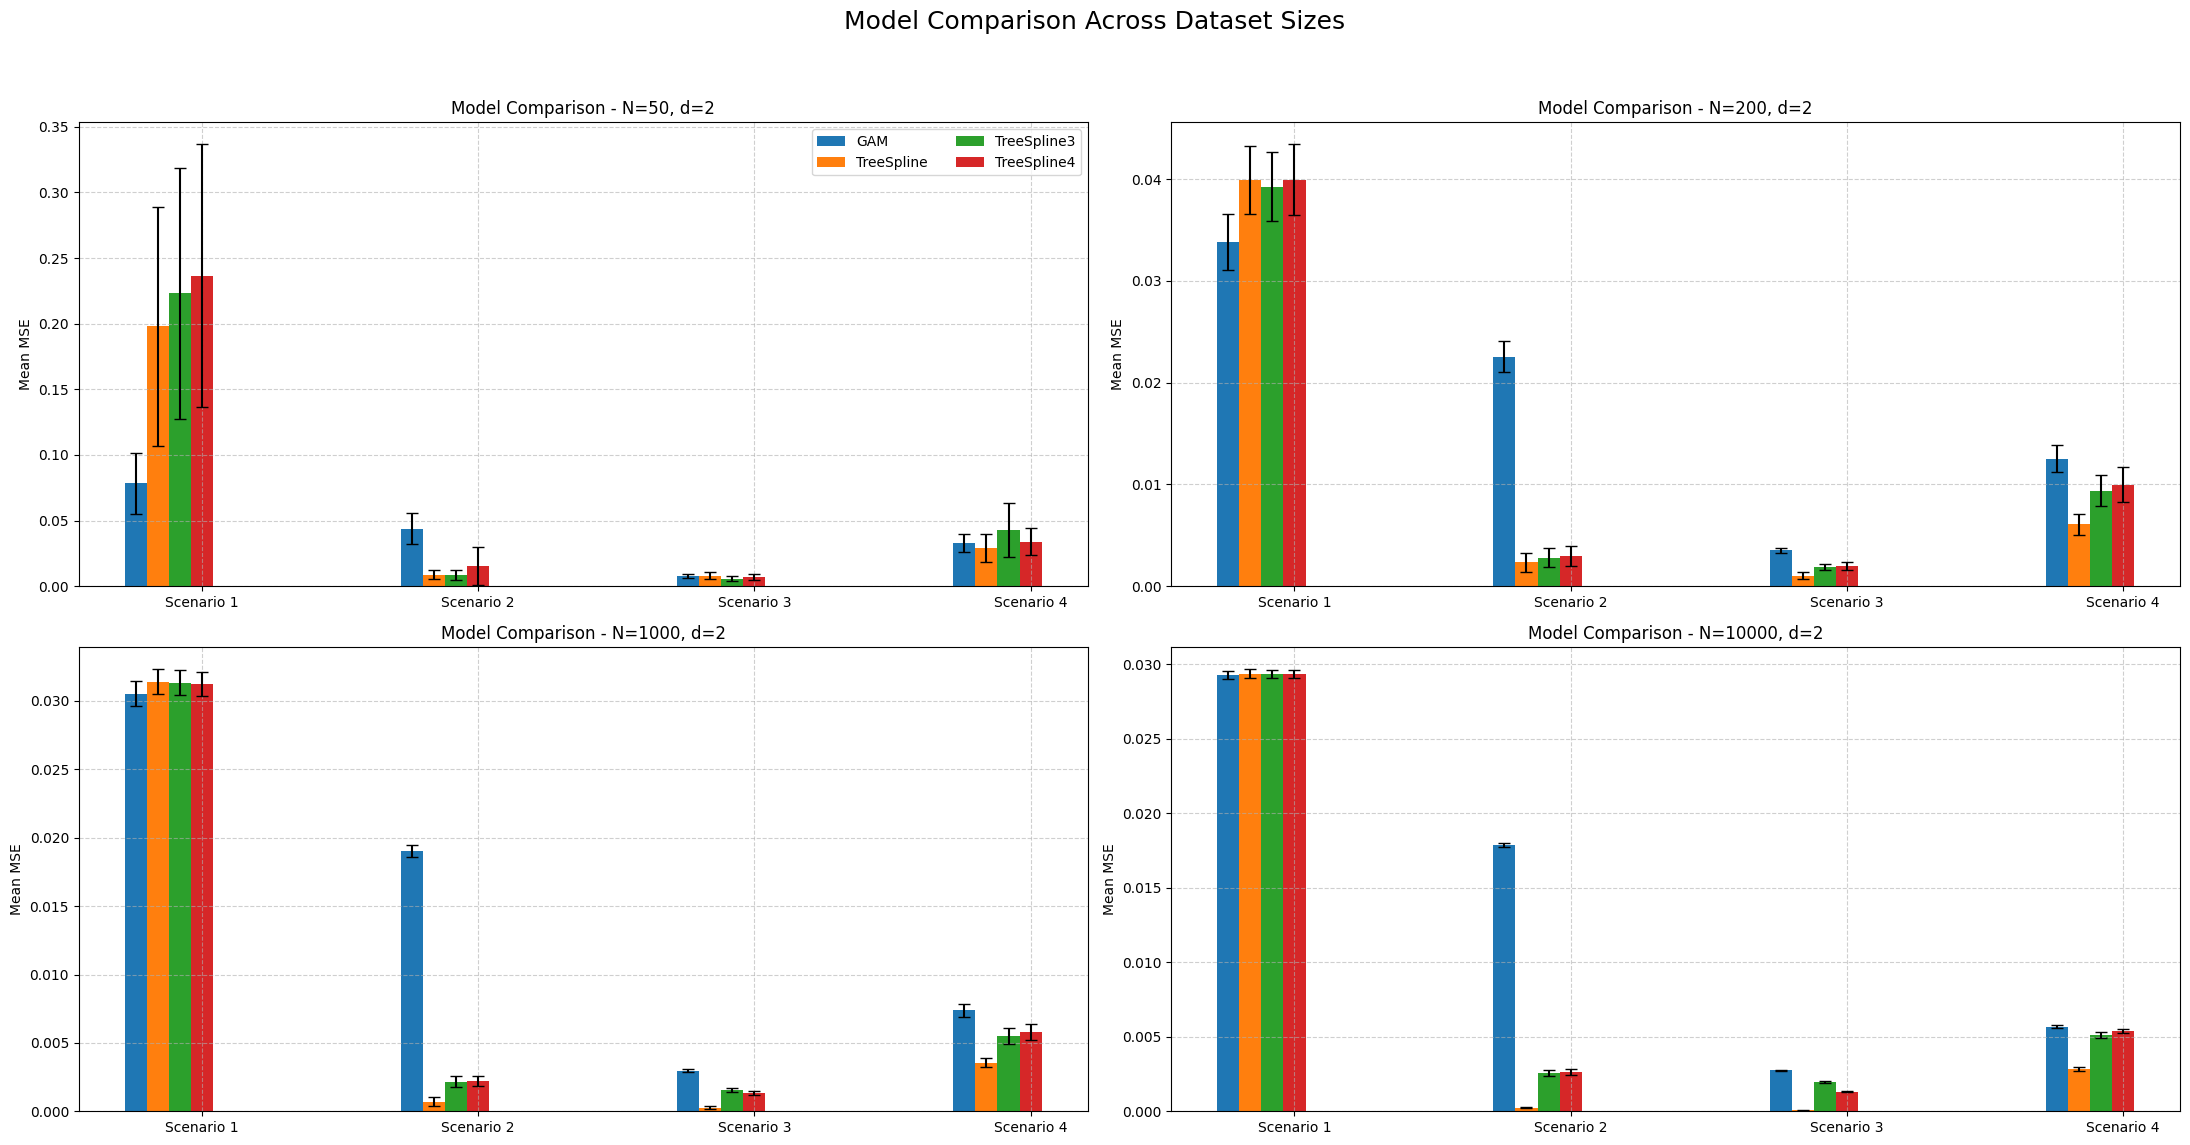

In [26]:
scenarios = ['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4']
x = np.arange(len(scenarios))
width = 0.08

titles = [
    'N=50, d=2',
    'N=200, d=2',
    'N=1000, d=2',
    'N=10000, d=2'
]

def summarize_ci(data_array):
    """Compute mean and 95% CI along repetitions for each scenario."""
    means = np.mean(data_array, axis=1)
    n_repeats = data_array.shape[1]
    cis = 1.96 * np.std(data_array, axis=1, ddof=1) / np.sqrt(n_repeats)
    return means, cis

model_data = {
    "GAM":      [gam_mse_hist50, gam_mse_hist200, gam_mse_hist1000, gam_mse_hist10000],
    "Tree1":    [tree_mse_hist50, tree_mse_hist200, tree_mse_hist1000, tree_mse_hist10000],
    "Tree3":    [tree3_mse_hist50, tree3_mse_hist200, tree3_mse_hist1000, tree3_mse_hist10000],
    "Tree4":    [tree4_mse_hist50, tree4_mse_hist200, tree4_mse_hist1000, tree4_mse_hist10000],
}

offsets = np.linspace(-3.0 * width, 3.0 * width, 7)
model_labels = [
    'GAM',
    'TreeSpline',
    'TreeSpline3',
    'TreeSpline4',
]

fig, axs = plt.subplots(2, 2, figsize=(22, 12))

for i, ax in enumerate(axs.flat):
    for j, model_name in enumerate(model_data.keys()):
        data_array = model_data[model_name][i]
        means, cis = summarize_ci(data_array)
        ax.bar(x + offsets[j], means, width, yerr=cis, capsize=4,
               label=model_labels[j] if i == 0 else None)

    ax.set_title(f'Model Comparison - {titles[i]}')
    ax.set_ylabel('Mean MSE')
    ax.set_xticks(x)
    ax.set_xticklabels(scenarios)
    ax.grid(True, linestyle='--', alpha=0.6)

    if i == 0:
        ax.legend(ncol=2, fontsize=10)

fig.suptitle("Model Comparison Across Dataset Sizes", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

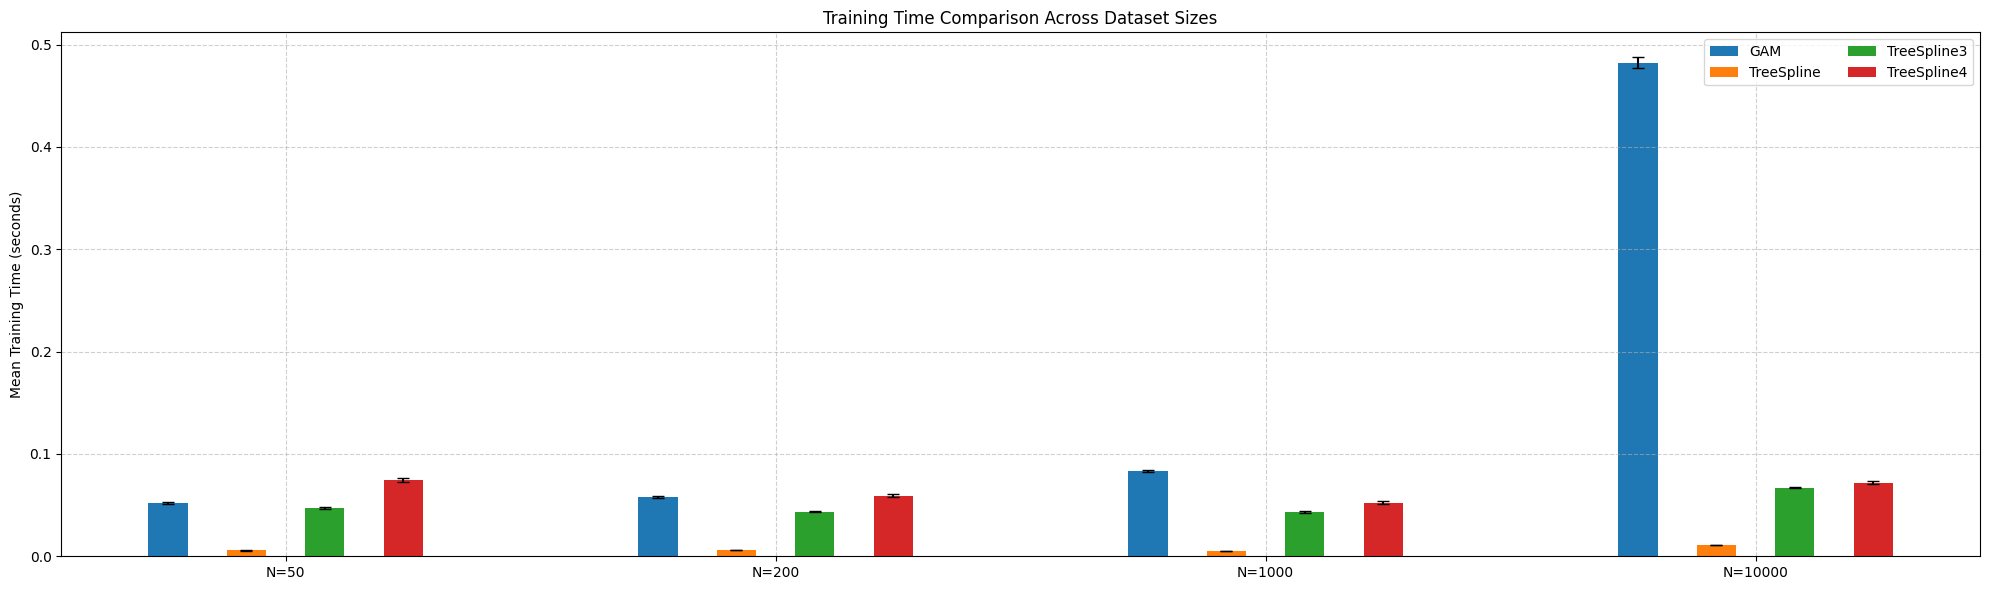

In [27]:
sample_sizes = ['N=50', 'N=200', 'N=1000', 'N=10000']
x = np.arange(len(sample_sizes))
width = 0.08

model_labels = [
    'GAM',
    'TreeSpline',
    'TreeSpline3',
    'TreeSpline4',
]

time_var_names = [
    "gam_time_hist{}",
    "tree_time_hist{}",
    "tree3_time_hist{}",
    "tree4_time_hist{}",
]

means_all = [[] for _ in range(len(model_labels))]
cis_all   = [[] for _ in range(len(model_labels))]

def mean_ci(arr, alpha=0.05):
    arr = np.array(arr)
    mean = np.mean(arr)
    ci = 1.96 * np.std(arr, ddof=1) / np.sqrt(len(arr))
    return mean, ci

# Compute means and CIs for all models and sample sizes
for size in [50, 200, 1000, 10000]:
    for i, var_template in enumerate(time_var_names):
        flat = np.concatenate(globals()[var_template.format(size)])
        mean, ci = mean_ci(flat)
        means_all[i].append(mean)
        cis_all[i].append(ci)

# Convert to arrays
means_all = list(map(np.array, means_all))
cis_all   = list(map(np.array, cis_all))

# Offsets for each model
offsets = np.linspace(-3.0 * width, 3.0 * width, len(model_labels))

# === Plot ===
fig, ax = plt.subplots(figsize=(20, 6))

for i in range(len(model_labels)):
    ax.bar(x + offsets[i], means_all[i], width, yerr=cis_all[i], capsize=4, label=model_labels[i])

ax.set_xticks(x)
ax.set_xticklabels(sample_sizes)
ax.set_ylabel('Mean Training Time (seconds)')
ax.set_title('Training Time Comparison Across Dataset Sizes')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(ncol=2, fontsize=10)

plt.tight_layout()
plt.show()

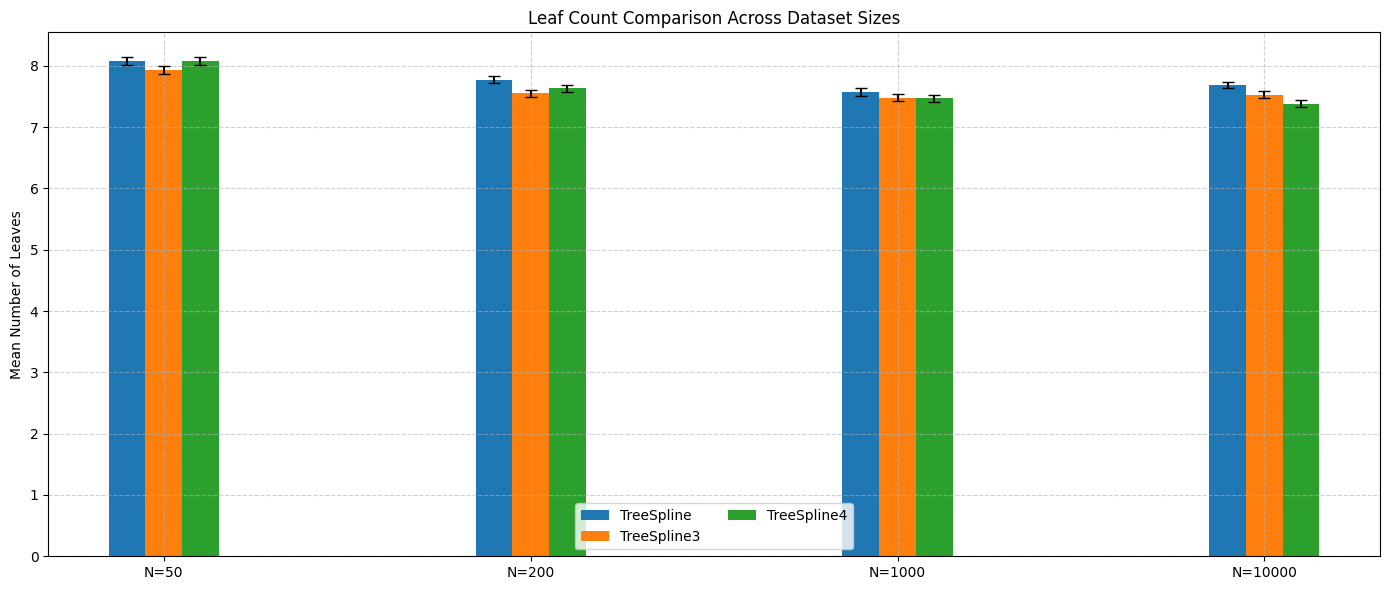

In [28]:
sample_sizes = [50, 200, 1000, 10000]
labels = [
    'TreeSpline', 'TreeSpline3', 'TreeSpline4'
]

n_models = len(labels)
x = np.arange(len(sample_sizes))
width = 0.1  # Adjust width to fit 6 bars per group

# Initialize mean and CI arrays
means = [[] for _ in range(n_models)]
cis = [[] for _ in range(n_models)]

# Helper function for mean and 95% CI
def mean_ci(arr):
    arr = np.array(arr)
    mean = np.mean(arr)
    ci = 1.96 * np.std(arr, ddof=1) / np.sqrt(len(arr))
    return mean, ci

for size in sample_sizes:
    leaf1_flat = np.concatenate(globals()[f"leaf_hist{size}"])
    leaf3_flat = np.concatenate(globals()[f"leaf3_hist{size}"])
    leaf4_flat = np.concatenate(globals()[f"leaf4_hist{size}"])

    all_leaf_data = [
        leaf1_flat, leaf3_flat, leaf4_flat
    ]

    for i, data in enumerate(all_leaf_data):
        m, c = mean_ci(data)
        means[i].append(m)
        cis[i].append(c)

# Convert to arrays
means = list(map(np.array, means))
cis = list(map(np.array, cis))

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

for i in range(n_models):
    ax.bar(x + (i - n_models // 2) * width, means[i], width,
           yerr=cis[i], capsize=4, label=labels[i])

ax.set_xticks(x)
ax.set_xticklabels([f'N={n}' for n in sample_sizes])
ax.set_ylabel('Mean Number of Leaves')
ax.set_title('Leaf Count Comparison Across Dataset Sizes')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(ncol=2)

plt.tight_layout()
plt.show()

# Testing with different sample sizes (data with interaction)

## N=50

In [29]:
n_samples = 50
repeats = 100

gam_mse_inthist50 = np.zeros((4, repeats))
gam_time_inthist50 = np.zeros((4, repeats))

tree_mse_inthist50 = np.zeros((4, repeats))
tree_time_inthist50 = np.zeros((4, repeats))
leaf_inthist50 = np.zeros((4, repeats))

tree3_mse_inthist50 = np.zeros((4, repeats))
tree3_time_inthist50 = np.zeros((4, repeats))
leaf3_inthist50 = np.zeros((4, repeats))

tree4_mse_inthist50 = np.zeros((4, repeats))
tree4_time_inthist50 = np.zeros((4, repeats))
leaf4_inthist50 = np.zeros((4, repeats))

for j in range(repeats):
   i = 0
   for delta in [0, 1, 5, 10]:
      X, y = generate_interactive_data(n_samples, delta=delta)
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
      y_train = y_train.reshape(-1, 1)
      y_test = y_test.reshape(-1, 1)

      # GAM
      gam_start = time.time()
      gam = LinearGAM(s(0) + s(1)).gridsearch(X_train, y_train)
      gam_end = time.time()
      gam_time_inthist50[i, j] = gam_end - gam_start
      y_pred = gam.predict(X_test)
      gam_mse_inthist50[i, j] = mean_squared_error(y_test, y_pred)

      # TreeSpline
      model = TreeSpline(random_state=22)
      tree_start = time.time()
      model.fit(X_train, y_train)
      tree_end = time.time()
      tree_time_inthist50[i-1, j] = tree_end - tree_start
      y_pred = model.predict(X_test)
      tree_mse_inthist50[i-1, j] = mean_squared_error(y_test, y_pred)
      leaf_inthist50[i-1, j] = model.get_leaf_count()

      # TreeSpline3
      model3 = TreeSpline3(random_state=22)
      t3_start = time.time()
      model3.fit(X_train, y_train)
      t3_end = time.time()
      tree3_time_inthist50[i, j] = t3_end - t3_start
      y_pred3 = model3.predict(X_test)
      tree3_mse_inthist50[i, j] = mean_squared_error(y_test, y_pred3)
      leaf3_inthist50[i, j] = model3.get_leaf_count()

      # TreeSpline4
      model4 = TreeSpline4(random_state=22)
      t4_start = time.time()
      model4.fit(X_train, y_train)
      t4_end = time.time()
      tree4_time_inthist50[i, j] = t4_end - t4_start
      y_pred4 = model4.predict(X_test)
      tree4_mse_inthist50[i, j] = mean_squared_error(y_test, y_pred4)
      leaf4_inthist50[i, j] = model4.get_leaf_count()

      i += 1

   print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 2 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 6 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 7 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 8 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 9 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 10 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 12 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 13 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 15 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 18 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 19 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 20 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 21 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 22 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 23 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 24 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 25 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 26 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 27 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 28 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 29 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 30 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 31 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 32 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 33 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 35 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 37 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00



--- Repetition no. 38 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 39 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 40 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 41 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 42 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 44 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 45 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 46 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 47 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 48 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 49 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 50 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 51 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 53 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 54 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 55 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 56 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 57 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 58 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 60 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 61 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 62 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 63 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 64 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 66 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 67 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 68 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 70 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 71 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 74 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 77 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 78 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 79 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 80 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 81 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 83 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 84 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 85 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 86 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 87 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 88 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 89 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 90 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 91 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 92 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 93 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 94 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 95 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 96 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 97 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 98 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 99 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



## N=200

In [30]:
n_samples = 200
repeats = 100

gam_mse_inthist200 = np.zeros((4, repeats))
gam_time_inthist200 = np.zeros((4, repeats))

tree_mse_inthist200 = np.zeros((4, repeats))
tree_time_inthist200 = np.zeros((4, repeats))
leaf_inthist200 = np.zeros((4, repeats))

tree3_mse_inthist200 = np.zeros((4, repeats))
tree3_time_inthist200 = np.zeros((4, repeats))
leaf3_inthist200 = np.zeros((4, repeats))

tree4_mse_inthist200 = np.zeros((4, repeats))
tree4_time_inthist200 = np.zeros((4, repeats))
leaf4_inthist200 = np.zeros((4, repeats))

for j in range(repeats):
   i = 0
   for delta in [0, 1, 5, 10]:
      X, y = generate_interactive_data(n_samples, delta=delta)
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
      y_train = y_train.reshape(-1, 1)
      y_test = y_test.reshape(-1, 1)
      
      # GAM
      gam_start = time.time()
      gam = LinearGAM(s(0) + s(1)).gridsearch(X_train, y_train)
      gam_end = time.time()
      gam_time_inthist200[i, j] = gam_end - gam_start
      y_pred = gam.predict(X_test)
      gam_mse_inthist200[i, j] = mean_squared_error(y_test, y_pred)

      # TreeSpline
      model = TreeSpline(random_state=22)
      tree_start = time.time()
      model.fit(X_train, y_train)
      tree_end = time.time()
      tree_time_inthist200[i, j] = tree_end - tree_start
      y_pred = model.predict(X_test)
      tree_mse_inthist200[i, j] = mean_squared_error(y_test, y_pred)
      leaf_inthist200[i, j] = model.get_leaf_count()

      # TreeSpline3
      model3 = TreeSpline3(random_state=22)
      t3_start = time.time()
      model3.fit(X_train, y_train)
      t3_end = time.time()
      tree3_time_inthist200[i, j] = t3_end - t3_start
      y_pred3 = model3.predict(X_test)
      tree3_mse_inthist200[i, j] = mean_squared_error(y_test, y_pred3)
      leaf3_inthist200[i, j] = model3.get_leaf_count()

      # TreeSpline4
      model4 = TreeSpline4(random_state=22)
      t4_start = time.time()
      model4.fit(X_train, y_train)
      t4_end = time.time()
      tree4_time_inthist200[i, j] = t4_end - t4_start
      y_pred4 = model4.predict(X_test)
      tree4_mse_inthist200[i, j] = mean_squared_error(y_test, y_pred4)
      leaf4_inthist200[i, j] = model4.get_leaf_count()

      i += 1

   print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |#######################


--- Repetition no. 1 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 2 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 3 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 4 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 5 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################  


--- Repetition no. 6 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 7 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 8 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 9 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 10 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 11 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 12 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00



--- Repetition no. 14 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 15 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 16 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 17 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 18 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00



--- Repetition no. 19 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 21 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 22 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 23 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 26 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 30 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 31 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 32 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 33 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 34 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00



--- Repetition no. 35 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 36 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 38 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 40 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 41 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 42 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 43 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 45 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 46 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00



--- Repetition no. 47 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 50 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 52 done! ---



 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 53 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 54 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 57 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 58 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 60 done! ---



 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 61 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00



--- Repetition no. 62 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 63 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 65 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 66 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 67 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 68 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 69 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 70 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 71 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 73 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 74 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 75 done! ---



 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 76 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 77 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 79 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 80 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 81 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 82 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 83 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 84 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 85 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 87 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 88 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 89 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 90 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 91 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 92 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 93 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 95 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 96 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 97 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



## N=1000

In [31]:
n_samples = 1000
repeats = 100

gam_mse_inthist1000 = np.zeros((4, repeats))
gam_time_inthist1000 = np.zeros((4, repeats))

tree_mse_inthist1000 = np.zeros((4, repeats))
tree_time_inthist1000 = np.zeros((4, repeats))
leaf_inthist1000 = np.zeros((4, repeats))

tree3_mse_inthist1000 = np.zeros((4, repeats))
tree3_time_inthist1000 = np.zeros((4, repeats))
leaf3_inthist1000 = np.zeros((4, repeats))

tree4_mse_inthist1000 = np.zeros((4, repeats))
tree4_time_inthist1000 = np.zeros((4, repeats))
leaf4_inthist1000 = np.zeros((4, repeats))

for j in range(repeats):
   i = 0
   for delta in [0, 1, 5, 10]:
      X, y = generate_interactive_data(n_samples, delta=delta)
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
      y_train = y_train.reshape(-1, 1)
      y_test = y_test.reshape(-1, 1)

      # GAM
      gam_start = time.time()
      gam = LinearGAM(s(0) + s(1)).gridsearch(X_train, y_train)
      gam_end = time.time()
      gam_time_inthist1000[i, j] = gam_end - gam_start
      y_pred = gam.predict(X_test)
      gam_mse_inthist1000[i, j] = mean_squared_error(y_test, y_pred)

      # TreeSpline
      model = TreeSpline(random_state=22)
      tree_start = time.time()
      model.fit(X_train, y_train)
      tree_end = time.time()
      tree_time_inthist1000[i, j] = tree_end - tree_start
      y_pred = model.predict(X_test)
      tree_mse_inthist1000[i, j] = mean_squared_error(y_test, y_pred)
      leaf_inthist1000[i, j] = model.get_leaf_count()

      # TreeSpline3
      model3 = TreeSpline3(random_state=22)
      t3_start = time.time()
      model3.fit(X_train, y_train)
      t3_end = time.time()
      tree3_time_inthist1000[i, j] = t3_end - t3_start
      y_pred3 = model3.predict(X_test)
      tree3_mse_inthist1000[i, j] = mean_squared_error(y_test, y_pred3)
      leaf3_inthist1000[i, j] = model3.get_leaf_count()

      # TreeSpline4
      model4 = TreeSpline4(random_state=22)
      t4_start = time.time()
      model4.fit(X_train, y_train)
      t4_end = time.time()
      tree4_time_inthist1000[i, j] = t4_end - t4_start
      y_pred4 = model4.predict(X_test)
      tree4_mse_inthist1000[i, j] = mean_squared_error(y_test, y_pred4)
      leaf4_inthist1000[i, j] = model4.get_leaf_count()

      i += 1

   print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############           


--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############         


--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################  


--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 36 done! ---



 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 84 done! ---



 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



## N=10000

In [32]:
n_samples = 10000
repeats = 100

gam_mse_inthist10000 = np.zeros((4, repeats))
gam_time_inthist10000 = np.zeros((4, repeats))

tree_mse_inthist10000 = np.zeros((4, repeats))
tree_time_inthist10000 = np.zeros((4, repeats))
leaf_inthist10000 = np.zeros((4, repeats))

tree3_mse_inthist10000 = np.zeros((4, repeats))
tree3_time_inthist10000 = np.zeros((4, repeats))
leaf3_inthist10000 = np.zeros((4, repeats))

tree4_mse_inthist10000 = np.zeros((4, repeats))
tree4_time_inthist10000 = np.zeros((4, repeats))
leaf4_inthist10000 = np.zeros((4, repeats))

for j in range(repeats):
   i = 0
   for delta in [0, 1, 5, 10]:
      X, y = generate_interactive_data(n_samples, delta=delta)
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
      y_train = y_train.reshape(-1, 1)
      y_test = y_test.reshape(-1, 1)

      # GAM
      gam_start = time.time()
      gam = LinearGAM(s(0) + s(1)).gridsearch(X_train, y_train)
      gam_end = time.time()
      gam_time_inthist10000[i, j] = gam_end - gam_start
      y_pred = gam.predict(X_test)
      gam_mse_inthist10000[i, j] = mean_squared_error(y_test, y_pred)

      # TreeSpline
      model = TreeSpline(random_state=22)
      tree_start = time.time()
      model.fit(X_train, y_train)
      tree_end = time.time()
      tree_time_inthist10000[i, j] = tree_end - tree_start
      y_pred = model.predict(X_test)
      tree_mse_inthist10000[i, j] = mean_squared_error(y_test, y_pred)
      leaf_inthist10000[i, j] = model.get_leaf_count()

      # TreeSpline3
      model3 = TreeSpline3(random_state=22)
      t3_start = time.time()
      model3.fit(X_train, y_train)
      t3_end = time.time()
      tree3_time_inthist10000[i, j] = t3_end - t3_start
      y_pred3 = model3.predict(X_test)
      tree3_mse_inthist10000[i, j] = mean_squared_error(y_test, y_pred3)
      leaf3_inthist10000[i, j] = model3.get_leaf_count()

      # TreeSpline4
      model4 = TreeSpline4(random_state=22)
      t4_start = time.time()
      model4.fit(X_train, y_train)
      t4_end = time.time()
      tree4_time_inthist10000[i, j] = t4_end - t4_start
      y_pred4 = model4.predict(X_test)
      tree4_mse_inthist10000[i, j] = mean_squared_error(y_test, y_pred4)
      leaf4_inthist10000[i, j] = model4.get_leaf_count()

      i += 1

   print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################  


--- Repetition no. 1 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 2 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 3 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 4 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 5 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 6 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 7 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 8 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 9 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 10 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 11 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 12 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 13 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 14 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 15 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 16 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 17 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 18 done! ---



 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 19 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 20 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 21 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 22 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 23 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 24 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 25 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 26 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 27 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 28 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 29 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 30 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 31 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################  


--- Repetition no. 32 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 33 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                      


--- Repetition no. 34 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 35 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 36 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 37 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 38 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 39 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 40 done! ---



 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################      


--- Repetition no. 41 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 42 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 43 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                      


--- Repetition no. 44 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 45 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 46 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 47 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 48 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 49 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 50 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 51 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 52 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 53 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 54 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 55 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 56 done! ---



 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 57 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 58 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 59 done! ---



 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 60 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 61 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 62 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 63 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 64 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 65 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 66 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 67 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 68 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 69 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 70 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 71 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 72 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 73 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 74 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 75 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 76 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 77 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 78 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 79 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 80 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 81 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 82 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 83 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 84 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 85 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 86 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 87 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 88 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 89 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 90 done! ---



 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############           


--- Repetition no. 91 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 92 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 93 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 94 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                      


--- Repetition no. 95 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 96 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 97 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 98 done! ---



 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 99 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 100 done! ---



## Saving, Loading, Plotting

In [33]:
for size in [50, 200, 1000, 10000]:
   np.save(f'./nparrs/tree_time_inthist{size}.npy', globals()[f'tree_time_inthist{size}'])
   np.save(f'./nparrs/tree_mse_inthist{size}.npy', globals()[f'tree_mse_inthist{size}'])
   np.save(f'./nparrs/leaf_inthist{size}.npy', globals()[f'leaf_inthist{size}'])

   np.save(f'./nparrs/gam_time_inthist{size}.npy', globals()[f'gam_time_inthist{size}'])
   np.save(f'./nparrs/gam_mse_inthist{size}.npy', globals()[f'gam_mse_inthist{size}'])

   np.save(f'./nparrs/tree3_time_inthist{size}.npy', globals()[f'tree3_time_inthist{size}'])
   np.save(f'./nparrs/tree3_mse_inthist{size}.npy', globals()[f'tree3_mse_inthist{size}'])
   np.save(f'./nparrs/leaf3_inthist{size}.npy', globals()[f'leaf3_inthist{size}'])

   np.save(f'./nparrs/tree4_time_inthist{size}.npy', globals()[f'tree4_time_inthist{size}'])
   np.save(f'./nparrs/tree4_mse_inthist{size}.npy', globals()[f'tree4_mse_inthist{size}'])
   np.save(f'./nparrs/leaf4_inthist{size}.npy', globals()[f'leaf4_inthist{size}'])

In [15]:
for size in [50, 200, 1000, 10000]:
   globals()[f'tree_time_inthist{size}'] = np.load(f'./nparrs/tree_time_inthist{size}.npy', allow_pickle=True)
   globals()[f'tree_mse_inthist{size}'] = np.load(f'./nparrs/tree_mse_inthist{size}.npy', allow_pickle=True)
   globals()[f'leaf_inthist{size}'] = np.load(f'./nparrs/leaf_inthist{size}.npy', allow_pickle=True)

   globals()[f'gam_time_inthist{size}'] = np.load(f'./nparrs/gam_time_inthist{size}.npy', allow_pickle=True)
   globals()[f'gam_mse_inthist{size}'] = np.load(f'./nparrs/gam_mse_inthist{size}.npy', allow_pickle=True)

   globals()[f'tree3_time_inthist{size}'] = np.load(f'./nparrs/tree3_time_inthist{size}.npy', allow_pickle=True)
   globals()[f'tree3_mse_inthist{size}'] = np.load(f'./nparrs/tree3_mse_inthist{size}.npy', allow_pickle=True)
   globals()[f'leaf3_inthist{size}'] = np.load(f'./nparrs/leaf3_inthist{size}.npy', allow_pickle=True)

   globals()[f'tree4_time_inthist{size}'] = np.load(f'./nparrs/tree4_time_inthist{size}.npy', allow_pickle=True)
   globals()[f'tree4_mse_inthist{size}'] = np.load(f'./nparrs/tree4_mse_inthist{size}.npy', allow_pickle=True)
   globals()[f'leaf4_inthist{size}'] = np.load(f'./nparrs/leaf4_inthist{size}.npy', allow_pickle=True)

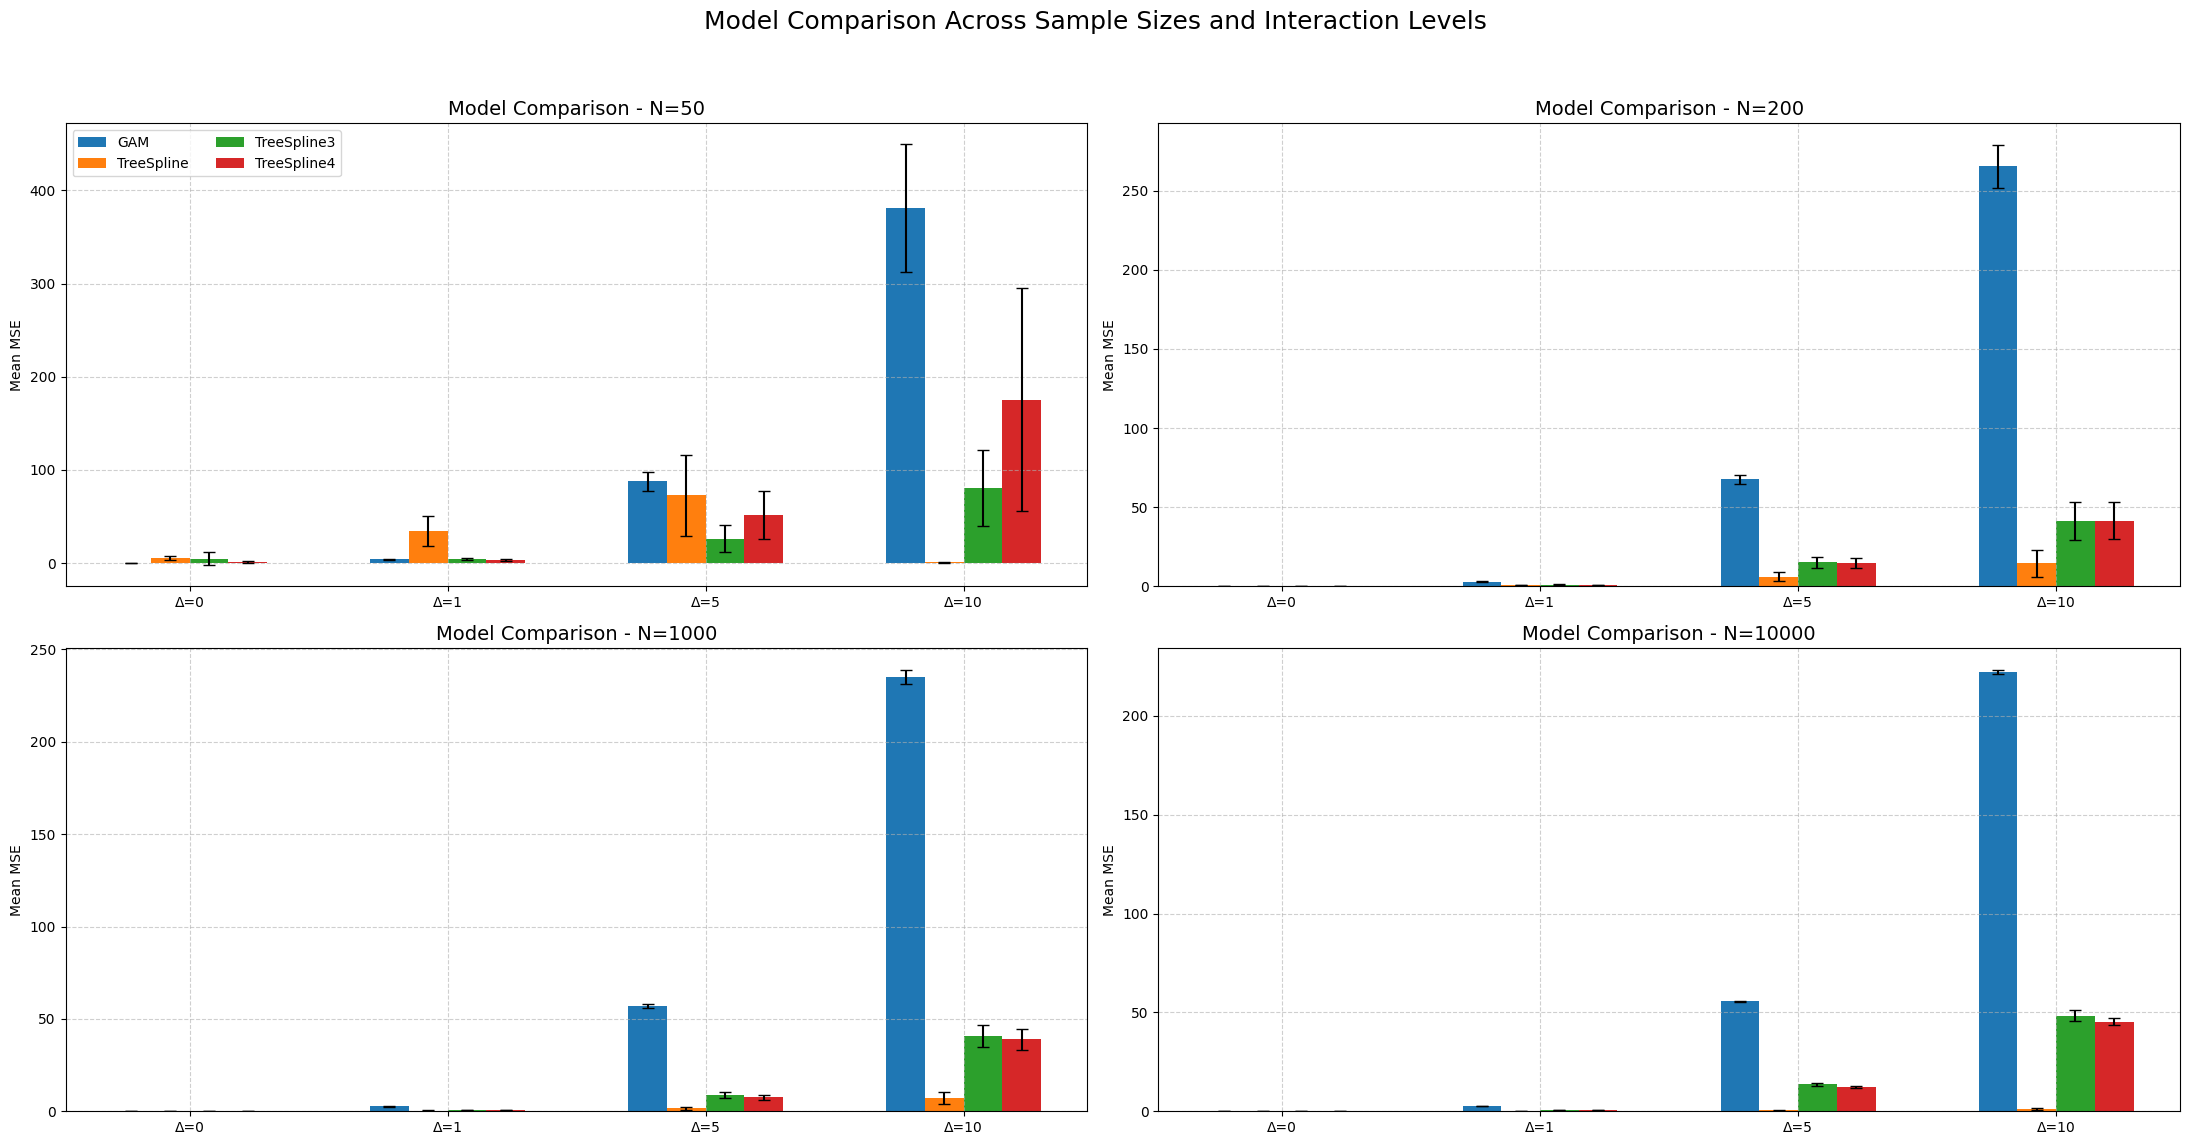

In [35]:
sample_sizes = ['N=50', 'N=200', 'N=1000', 'N=10000']
n_values = [50, 200, 1000, 10000]
scenarios = ['Δ=0', 'Δ=1', 'Δ=5', 'Δ=10']  # Added Δ=0
x = np.arange(len(scenarios))
width = 0.15  # Slightly larger width for fewer models

# Updated model labels (TreeSpline5 & TreeSpline6 removed)
model_labels = [
    'GAM',
    'TreeSpline',
    'TreeSpline3',
    'TreeSpline4'
]

# Updated MSE arrays (only first 4 models)
all_mse_vars = [
    [gam_mse_inthist50, gam_mse_inthist200, gam_mse_inthist1000, gam_mse_inthist10000],
    [tree_mse_inthist50, tree_mse_inthist200, tree_mse_inthist1000, tree_mse_inthist10000],
    [tree3_mse_inthist50, tree3_mse_inthist200, tree3_mse_inthist1000, tree3_mse_inthist10000],
    [tree4_mse_inthist50, tree4_mse_inthist200, tree4_mse_inthist1000, tree4_mse_inthist10000]
]

def mean_ci(data, confidence=0.95):
    data = np.array(data)
    mean = np.mean(data, axis=1)
    sd = stats.sem(data, axis=1)
    h = sd * stats.t.ppf((1 + confidence) / 2.0, data.shape[1] - 1)
    return mean, h

offsets = np.linspace(-1.5 * width, 1.5 * width, len(all_mse_vars))  # Adjust offsets
fig, axs = plt.subplots(2, 2, figsize=(22, 12))
axs = axs.flatten()

for i in range(4):
    ax = axs[i]
    for j, mse_list in enumerate(all_mse_vars):
        data = mse_list[i]  # Shape (4, 100)
        means, cis = mean_ci(data)
        ax.bar(x + offsets[j], means, width, yerr=cis, capsize=4, label=model_labels[j] if i == 0 else None)

    ax.set_title(f'Model Comparison - {sample_sizes[i]}', fontsize=14)
    ax.set_ylabel('Mean MSE')
    ax.set_xticks(x)
    ax.set_xticklabels(scenarios)
    ax.grid(True, linestyle='--', alpha=0.6)

    if i == 0:
        ax.legend(ncol=2, fontsize=10)

fig.suptitle("Model Comparison Across Sample Sizes and Interaction Levels", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

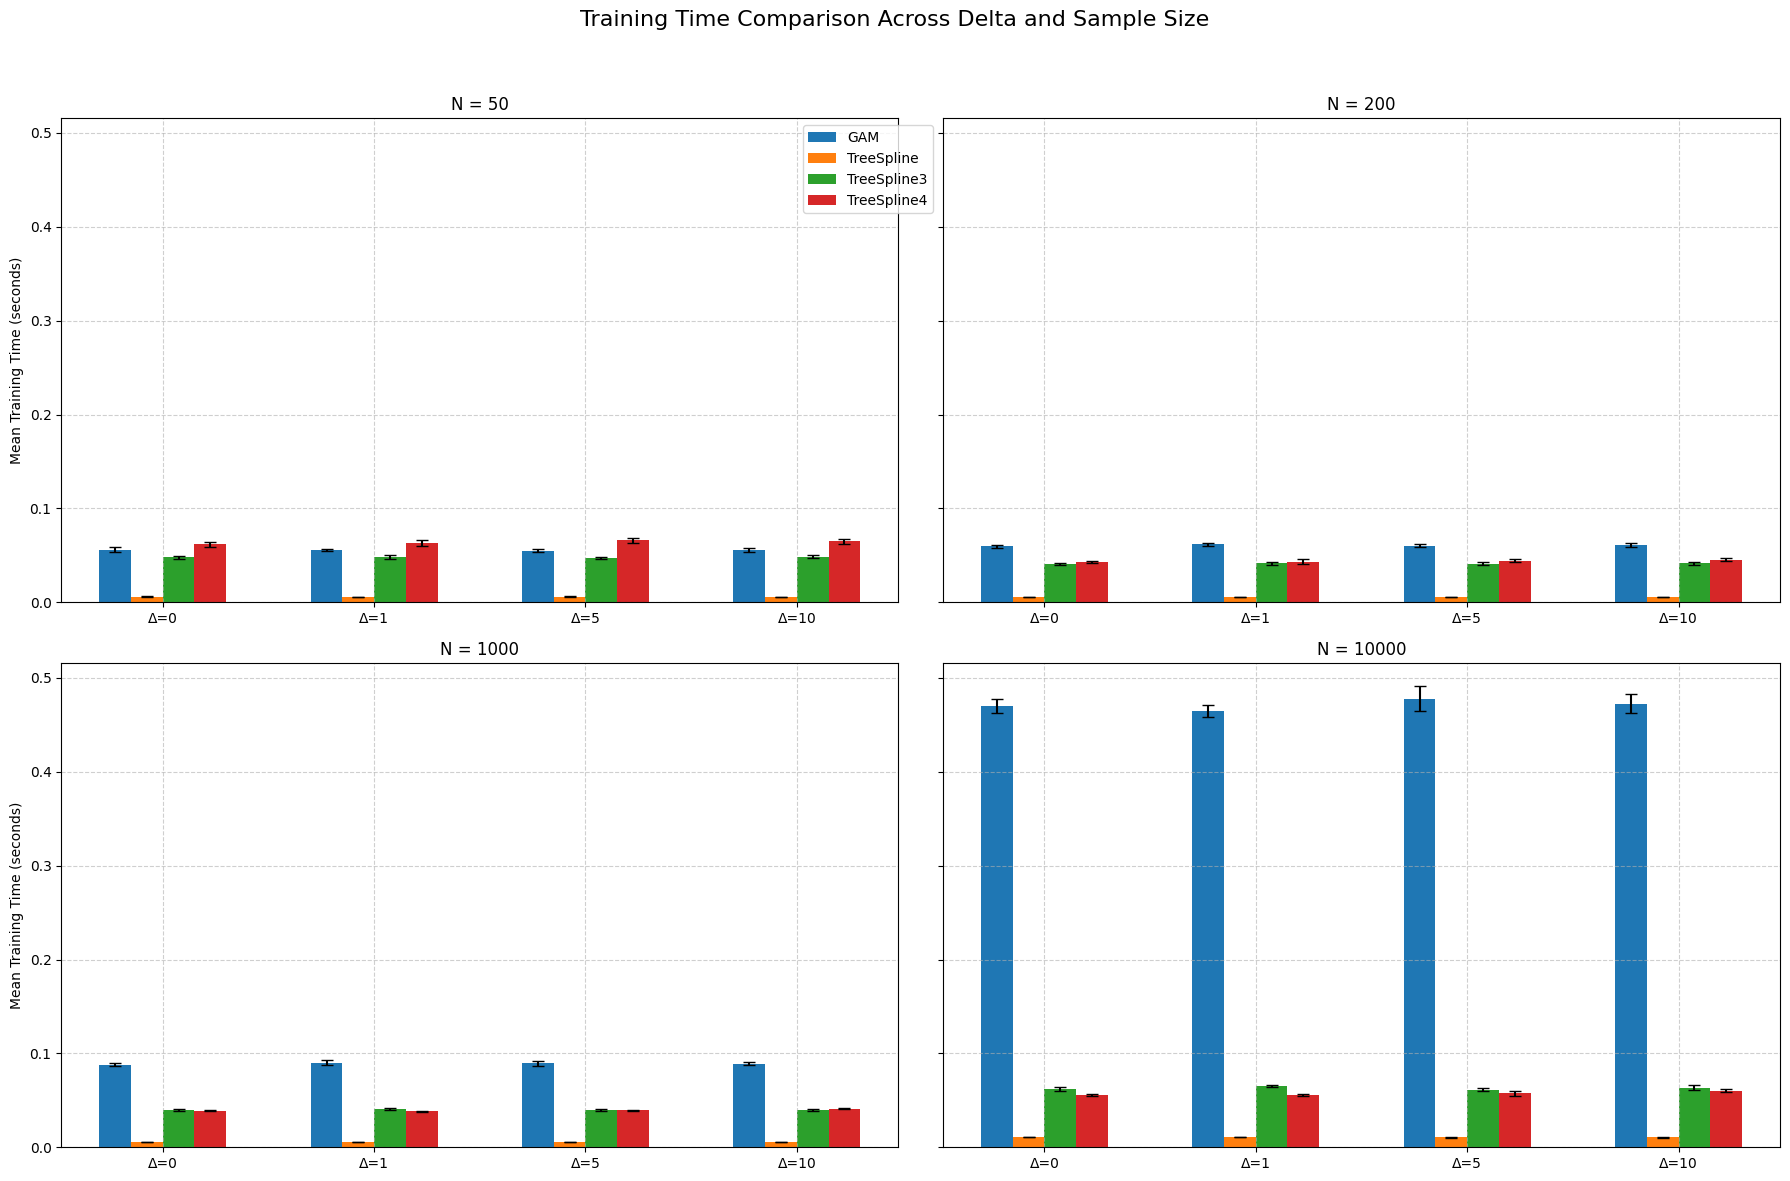

In [36]:
model_labels = [
    'GAM',
    'TreeSpline',
    'TreeSpline3',
    'TreeSpline4',
]

time_var_templates = [
    "gam_time_inthist{}",
    "tree_time_inthist{}",
    "tree3_time_inthist{}",
    "tree4_time_inthist{}",
]

sample_sizes = [50, 200, 1000, 10000]
delta_labels = ['Δ=0', 'Δ=1', 'Δ=5', 'Δ=10']  # Added Δ=0
x = np.arange(len(delta_labels))
width = 0.15  # Adjust width for 4 models

# Function to compute mean ± CI
def mean_ci(data, confidence=0.95):
    data = np.atleast_2d(data)  # ensure 2D
    if data.shape[0] != len(delta_labels):
        data = data.T  # transpose if needed: rows=Δ, cols=repeats
    mean = np.mean(data, axis=1)
    sd = stats.sem(data, axis=1)
    h = sd * stats.t.ppf((1 + confidence) / 2.0, data.shape[1] - 1)
    return mean, h

def compute_ci_stats(data_list):
    means, cis = [], []
    for data in data_list:
        m, c = mean_ci(data)
        means.append(m)
        cis.append(c)
    return np.array(means), np.array(cis)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(18, 12), sharey=True)

for idx, size in enumerate(sample_sizes):
    means_all = []
    cis_all = []
    
    for template in time_var_templates:
        varname = template.format(size)
        data = globals()[varname]  # could be 1D or 2D
        data = np.atleast_2d(data)
        if data.shape[0] != len(delta_labels):
            data = data.T
        m, c = mean_ci(data)
        means_all.append(m)
        cis_all.append(c)
    
    means_all = np.array(means_all)
    cis_all = np.array(cis_all)
    
    # Automatic offsets for any number of models
    offsets = np.linspace(-((len(model_labels)-1)/2)*width, ((len(model_labels)-1)/2)*width, len(model_labels))
    
    ax = axs[idx // 2, idx % 2]
    for i in range(len(model_labels)):
        ax.bar(x + offsets[i], means_all[i], width, yerr=cis_all[i], capsize=4,
               label=model_labels[i] if idx == 0 else "")
    
    ax.set_xticks(x)
    ax.set_xticklabels(delta_labels)
    ax.set_title(f'N = {size}')
    ax.grid(True, linestyle='--', alpha=0.6)
    if idx % 2 == 0:
        ax.set_ylabel('Mean Training Time (seconds)')

# Legend only on top-left subplot    
axs[0, 0].legend(ncol=1, fontsize=10, bbox_to_anchor=(1.05, 1.0))
fig.suptitle('Training Time Comparison Across Delta and Sample Size', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

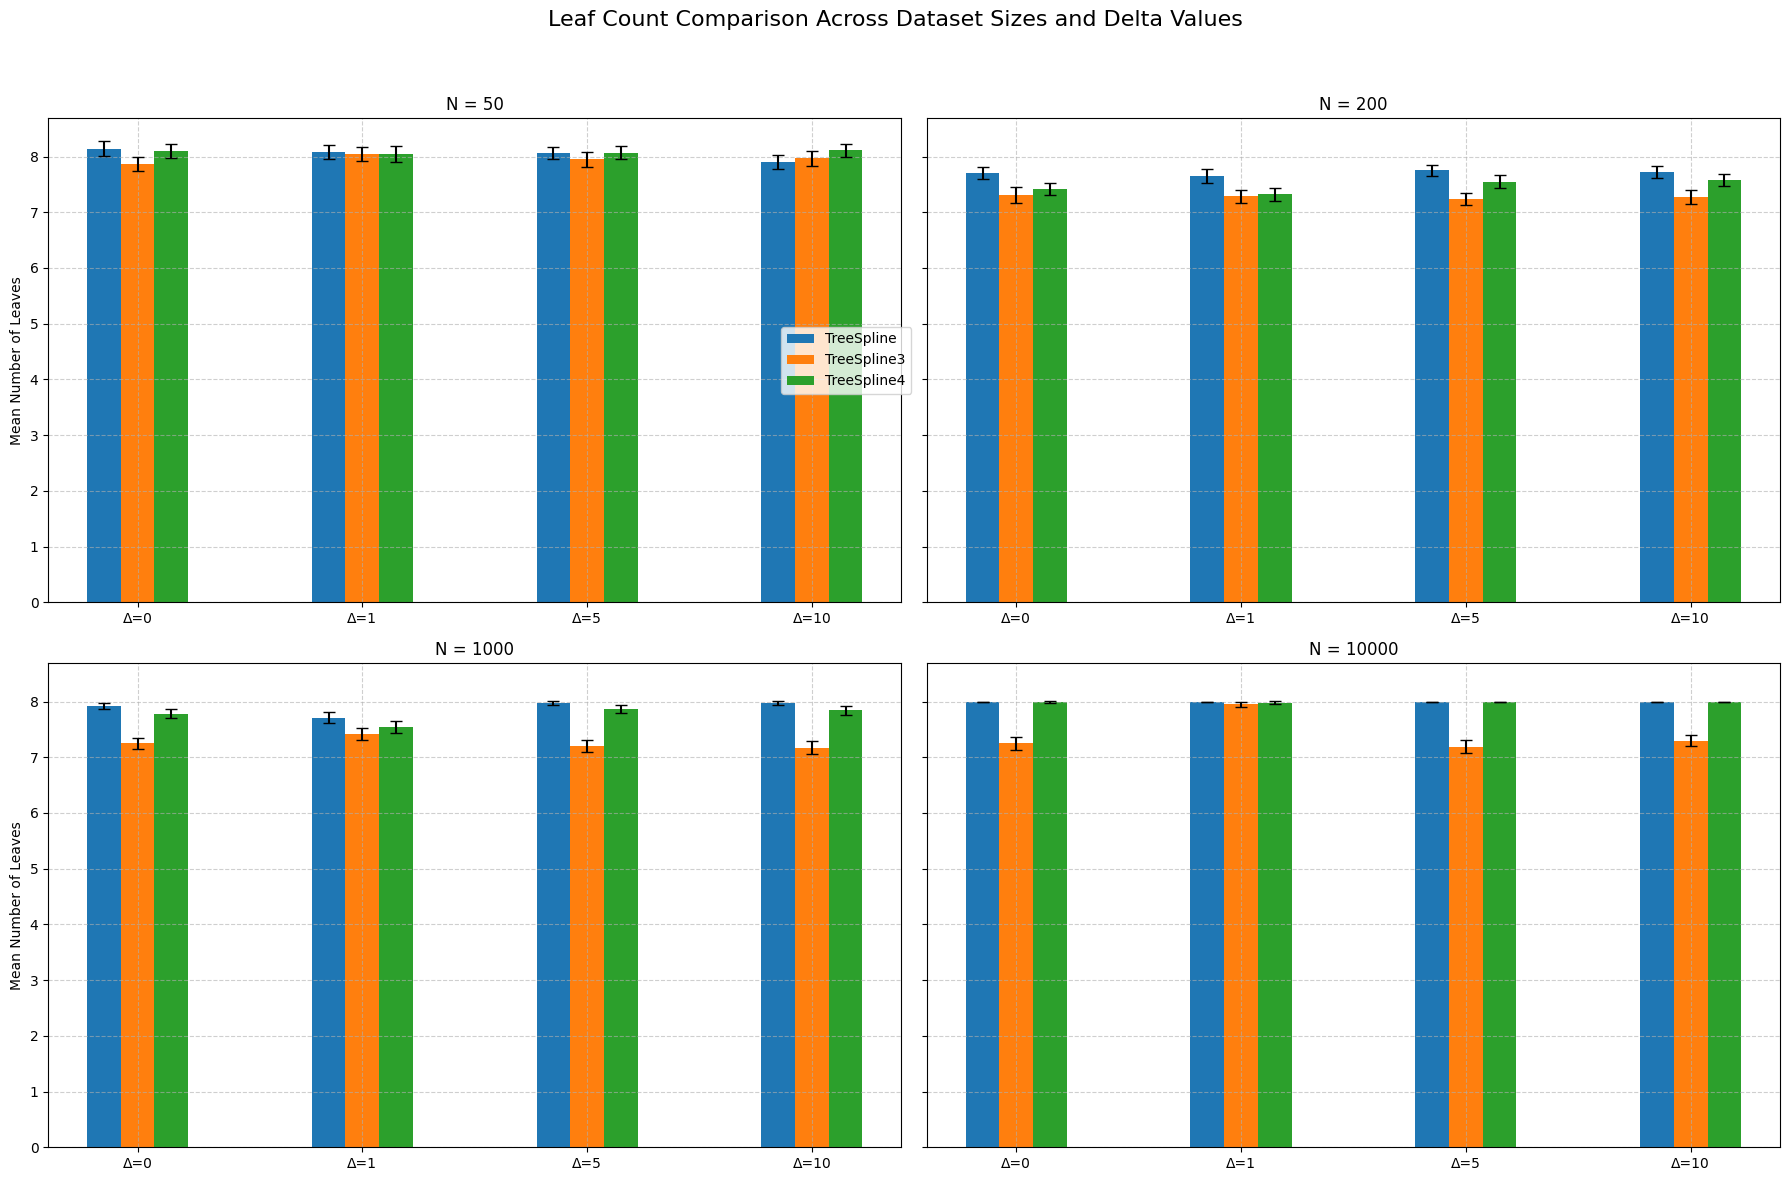

In [37]:
sample_sizes = [50, 200, 1000, 10000]
delta_labels = ['Δ=0', 'Δ=1', 'Δ=5', 'Δ=10']  # Added Δ=0
x = np.arange(len(delta_labels))

labels = [
    'TreeSpline',
    'TreeSpline3',
    'TreeSpline4',
]

n_models = len(labels)
width = 0.15  # Adjusted width for fewer models

def mean_ci(data, confidence=0.95):
    data = np.atleast_2d(data)
    if data.shape[0] != len(delta_labels):
        data = data.T  # ensure rows = deltas
    mean = np.mean(data, axis=1)
    sd = stats.sem(data, axis=1)
    h = sd * stats.t.ppf((1 + confidence) / 2.0, data.shape[1] - 1)
    return mean, h

fig, axs = plt.subplots(2, 2, figsize=(18, 12), sharey=True)

for idx, size in enumerate(sample_sizes):
    leaf_data_arrays = [
        globals()[f"leaf_inthist{size}"],
        globals()[f"leaf3_inthist{size}"],
        globals()[f"leaf4_inthist{size}"],
    ]

    means_all = []
    cis_all = []

    for data in leaf_data_arrays:
        data = np.atleast_2d(data)
        if data.shape[0] != len(delta_labels):
            data = data.T
        mean, ci = mean_ci(data)
        means_all.append(mean)
        cis_all.append(ci)

    means_all = np.array(means_all)  # shape (models, deltas)
    cis_all = np.array(cis_all)

    offsets = np.linspace(-((n_models-1)/2)*width, ((n_models-1)/2)*width, n_models)
    ax = axs[idx // 2, idx % 2]

    for i in range(n_models):
        ax.bar(x + offsets[i], means_all[i], width, yerr=cis_all[i], capsize=4,
               label=labels[i] if idx == 0 else "")

    ax.set_xticks(x)
    ax.set_xticklabels(delta_labels)
    ax.set_title(f'N = {size}')
    ax.grid(True, linestyle='--', alpha=0.6)

    if idx % 2 == 0:
        ax.set_ylabel('Mean Number of Leaves')

# Legend only on top-left subplot
axs[0, 0].legend(labels, loc='center right', fontsize=10, ncol=1, bbox_to_anchor=(1.02, 0.5))

fig.suptitle('Leaf Count Comparison Across Dataset Sizes and Delta Values', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Testing with different no. of features (N=1000)

In [38]:
n_samples = 1000

gam_mse_hist10005 = np.zeros((4, 100))
gam_time_hist10005 = np.zeros((4, 100))

leaf_hist10005 = np.zeros((4, 100))
tree_mse_hist10005 = np.zeros((4, 100))
tree_time_hist10005 = np.zeros((4, 100))

leaf3_hist10005 = np.zeros((4, 100))
tree3_mse_hist10005 = np.zeros((4, 100))
tree3_time_hist10005 = np.zeros((4, 100))

leaf4_hist10005 = np.zeros((4, 100))
tree4_mse_hist10005 = np.zeros((4, 100))
tree4_time_hist10005 = np.zeros((4, 100))

for j in range(100):
  for i in range(1, 5):
    X, y = generate_data(n_samples, i, n_features=5)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 22)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    X_train = np.asarray(X_train_scaled)
    y_train = np.asarray(y_train_scaled)

    # GAM
    gam_start = time.time()
    gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4)).gridsearch(X_train, y_train)
    gam_end = time.time()
    gam_time_hist10005[i-1, j] = gam_end - gam_start

    y_pred = gam.predict(X_test_scaled)
    mse_gam = mean_squared_error(y_test_scaled, y_pred)
    gam_mse_hist10005[i-1, j] = mse_gam

    # TreeSpline
    model = TreeSpline(random_state = 22)

    tree_start = time.time()
    model.fit(X_train_scaled, y_train_scaled)
    tree_end = time.time()
    tree_time_hist10005[i-1, j] = tree_end - tree_start

    y_pred = model.predict(X_test_scaled)
    mse_tree = mean_squared_error(y_test_scaled, y_pred)

    leaf_hist10005[i-1, j] = model.get_leaf_count()
    tree_mse_hist10005[i-1, j] = mse_tree

    # TreeSpline3
    model3 = TreeSpline3(random_state = 22)

    tree3_start = time.time()
    model3.fit(X_train_scaled, y_train_scaled)
    tree3_end = time.time()
    tree3_time_hist10005[i-1, j] = tree3_end - tree3_start

    y_pred = model3.predict(X_test_scaled)
    mse_tree3 = mean_squared_error(y_test_scaled, y_pred)

    leaf3_hist10005[i-1, j] = model3.get_leaf_count()
    tree3_mse_hist10005[i-1, j] = mse_tree3

    # TreeSpline4
    model4 = TreeSpline4(random_state = 22)

    tree4_start = time.time()
    model4.fit(X_train_scaled, y_train_scaled)
    tree4_end = time.time()
    tree4_time_hist10005[i-1, j] = tree4_end - tree4_start

    y_pred = model4.predict(X_test_scaled)
    mse_tree4 = mean_squared_error(y_test_scaled, y_pred)

    leaf4_hist10005[i-1, j] = model4.get_leaf_count()
    tree4_mse_hist10005[i-1, j] = mse_tree4

  print(f"\n---Repeatition no. {j+1} done!---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########             


---Repeatition no. 1 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 2 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 3 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 4 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 5 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 6 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 7 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 8 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 9 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 10 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 11 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 12 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################  


---Repeatition no. 13 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 14 done!---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 15 done!---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################    


---Repeatition no. 16 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 17 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 18 done!---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 19 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 20 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 21 done!---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############         


---Repeatition no. 22 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 23 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 24 done!---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 25 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 26 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


---Repeatition no. 27 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 28 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 29 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 30 done!---



 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 31 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 32 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 33 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################  


---Repeatition no. 34 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 35 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 36 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 37 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 38 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 39 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 40 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 41 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 42 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 43 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 44 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 45 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 46 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 47 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 48 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 49 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


---Repeatition no. 50 done!---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 51 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 52 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 53 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 54 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 55 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 56 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 57 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 58 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 59 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 60 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 61 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 62 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 63 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 64 done!---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 65 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 66 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 67 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 68 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 69 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 70 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 71 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 72 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 73 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 74 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 75 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 76 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 77 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 78 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 79 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 80 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 81 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 82 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 83 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################    


---Repeatition no. 84 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 85 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 86 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 87 done!---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 88 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 89 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 90 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 91 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 92 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 93 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 94 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 95 done!---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 96 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 97 done!---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 98 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 99 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 100 done!---



In [39]:
n_samples = 1000

gam_mse_hist100010 = np.zeros((4, 100))
gam_time_hist100010 = np.zeros((4, 100))

leaf_hist100010 = np.zeros((4, 100))
tree_mse_hist100010 = np.zeros((4, 100))
tree_time_hist100010 = np.zeros((4, 100))

leaf3_hist100010 = np.zeros((4, 100))
tree3_mse_hist100010 = np.zeros((4, 100))
tree3_time_hist100010 = np.zeros((4, 100))

leaf4_hist100010 = np.zeros((4, 100))
tree4_mse_hist100010 = np.zeros((4, 100))
tree4_time_hist100010 = np.zeros((4, 100))

for j in range(100):
  for i in range(1, 5):
    X, y = generate_data(n_samples, i, n_features=10)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 22)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    X_train = np.asarray(X_train_scaled)
    y_train = np.asarray(y_train_scaled)

    # GAM
    gam_start = time.time()
    gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4)).gridsearch(X_train, y_train)
    gam_end = time.time()
    gam_time_hist100010[i-1, j] = gam_end - gam_start

    y_pred = gam.predict(X_test_scaled)
    mse_gam = mean_squared_error(y_test_scaled, y_pred)
    gam_mse_hist100010[i-1, j] = mse_gam

    # TreeSpline
    model = TreeSpline(random_state = 22)

    tree_start = time.time()
    model.fit(X_train_scaled, y_train_scaled)
    tree_end = time.time()
    tree_time_hist100010[i-1, j] = tree_end - tree_start

    y_pred = model.predict(X_test_scaled)
    mse_tree = mean_squared_error(y_test_scaled, y_pred)

    leaf_hist100010[i-1, j] = model.get_leaf_count()
    tree_mse_hist100010[i-1, j] = mse_tree

    # TreeSpline3
    model3 = TreeSpline3(random_state = 22)

    tree3_start = time.time()
    model3.fit(X_train_scaled, y_train_scaled)
    tree3_end = time.time()
    tree3_time_hist100010[i-1, j] = tree3_end - tree3_start

    y_pred = model3.predict(X_test_scaled)
    mse_tree3 = mean_squared_error(y_test_scaled, y_pred)

    leaf3_hist100010[i-1, j] = model3.get_leaf_count()
    tree3_mse_hist100010[i-1, j] = mse_tree3

    # TreeSpline4
    model4 = TreeSpline4(random_state = 22)

    tree4_start = time.time()
    model4.fit(X_train_scaled, y_train_scaled)
    tree4_end = time.time()
    tree4_time_hist100010[i-1, j] = tree4_end - tree4_start

    y_pred = model4.predict(X_test_scaled)
    mse_tree4 = mean_squared_error(y_test_scaled, y_pred)

    leaf4_hist100010[i-1, j] = model4.get_leaf_count()
    tree4_mse_hist100010[i-1, j] = mse_tree4

  print(f"\n---Repeatition no. {j+1} done!---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############           


---Repeatition no. 1 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 2 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 3 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 4 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 5 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 6 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 7 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 8 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 9 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 10 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 11 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 12 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 13 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 14 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 15 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 16 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 17 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 18 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 19 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 20 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 21 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 22 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 23 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 24 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 25 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 26 done!---



 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 27 done!---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 28 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 29 done!---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 30 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 31 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 32 done!---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 33 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 34 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 35 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 36 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 37 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 38 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 39 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 40 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 41 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 42 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 43 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 44 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 45 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 46 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 47 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 48 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 49 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 50 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 51 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 52 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 53 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 54 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 55 done!---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 56 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 57 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 58 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 59 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 60 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 61 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 62 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 63 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 64 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 65 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 66 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 67 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 68 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 69 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 70 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 71 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 72 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 73 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 74 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 75 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


---Repeatition no. 76 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 77 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 78 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 79 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 80 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 81 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 82 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 83 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################      


---Repeatition no. 84 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 85 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


---Repeatition no. 86 done!---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############         


---Repeatition no. 87 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 88 done!---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############           


---Repeatition no. 89 done!---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 90 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 91 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 92 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 93 done!---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


---Repeatition no. 94 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 95 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 96 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


---Repeatition no. 97 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 98 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 99 done!---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                  


---Repeatition no. 100 done!---



In [43]:
np.save('./nparrs/gam_time_hist10005.npy', gam_time_hist10005)
np.save('./nparrs/gam_mse_hist10005.npy', gam_mse_hist10005)
np.save('./nparrs/tree_time_hist10005.npy', tree_time_hist10005)
np.save('./nparrs/leaf_hist10005.npy', leaf_hist10005)
np.save('./nparrs/tree_mse_hist10005.npy', tree_mse_hist10005)
np.save('./nparrs/tree3_time_hist10005.npy', tree3_time_hist10005)
np.save('./nparrs/leaf3_hist10005.npy', leaf3_hist10005)
np.save('./nparrs/tree3_mse_hist10005.npy', tree3_mse_hist10005)
np.save('./nparrs/tree4_time_hist10005.npy', tree4_time_hist10005)
np.save('./nparrs/leaf4_hist10005.npy', leaf4_hist10005)
np.save('./nparrs/tree4_mse_hist10005.npy', tree4_mse_hist10005)

np.save('./nparrs/gam_time_hist100010.npy', gam_time_hist100010)
np.save('./nparrs/gam_mse_hist100010.npy', gam_mse_hist100010)
np.save('./nparrs/tree_time_hist100010.npy', tree_time_hist100010)
np.save('./nparrs/leaf_hist100010.npy', leaf_hist100010)
np.save('./nparrs/tree_mse_hist100010.npy', tree_mse_hist100010)
np.save('./nparrs/tree3_time_hist100010.npy', tree3_time_hist100010)
np.save('./nparrs/leaf3_hist100010.npy', leaf3_hist100010)
np.save('./nparrs/tree3_mse_hist100010.npy', tree3_mse_hist100010)
np.save('./nparrs/tree4_time_hist100010.npy', tree4_time_hist100010)
np.save('./nparrs/leaf4_hist100010.npy', leaf4_hist100010)
np.save('./nparrs/tree4_mse_hist100010.npy', tree4_mse_hist100010)

In [53]:
gam_mse_hist10005 = np.load('./nparrs/gam_mse_hist10005.npy')
gam_time_hist10005 = np.load('./nparrs/gam_time_hist10005.npy')
leaf_hist10005 = np.load('./nparrs/leaf_hist10005.npy')
tree_mse_hist10005 = np.load('./nparrs/tree_mse_hist10005.npy')
tree_time_hist10005 = np.load('./nparrs/tree_time_hist10005.npy')
leaf3_hist10005 = np.load('./nparrs/leaf3_hist10005.npy')
tree3_mse_hist10005 = np.load('./nparrs/tree3_mse_hist10005.npy')
tree3_time_hist10005 = np.load('./nparrs/tree3_time_hist10005.npy')
leaf4_hist10005 = np.load('./nparrs/leaf4_hist10005.npy')
tree4_mse_hist10005 = np.load('./nparrs/tree4_mse_hist10005.npy')
tree4_time_hist10005 = np.load('./nparrs/tree4_time_hist10005.npy')

gam_mse_hist100010 = np.load('./nparrs/gam_mse_hist100010.npy')
gam_time_hist100010 = np.load('./nparrs/gam_time_hist100010.npy')
leaf_hist100010 = np.load('./nparrs/leaf_hist100010.npy')
tree_mse_hist100010 = np.load('./nparrs/tree_mse_hist100010.npy')
tree_time_hist100010 = np.load('./nparrs/tree_time_hist100010.npy')
leaf3_hist100010 = np.load('./nparrs/leaf3_hist100010.npy')
tree3_mse_hist100010 = np.load('./nparrs/tree3_mse_hist100010.npy')
tree3_time_hist100010 = np.load('./nparrs/tree3_time_hist100010.npy')
leaf4_hist100010 = np.load('./nparrs/leaf4_hist100010.npy')
tree4_mse_hist100010 = np.load('./nparrs/tree4_mse_hist100010.npy')
tree4_time_hist100010 = np.load('./nparrs/tree4_time_hist100010.npy')

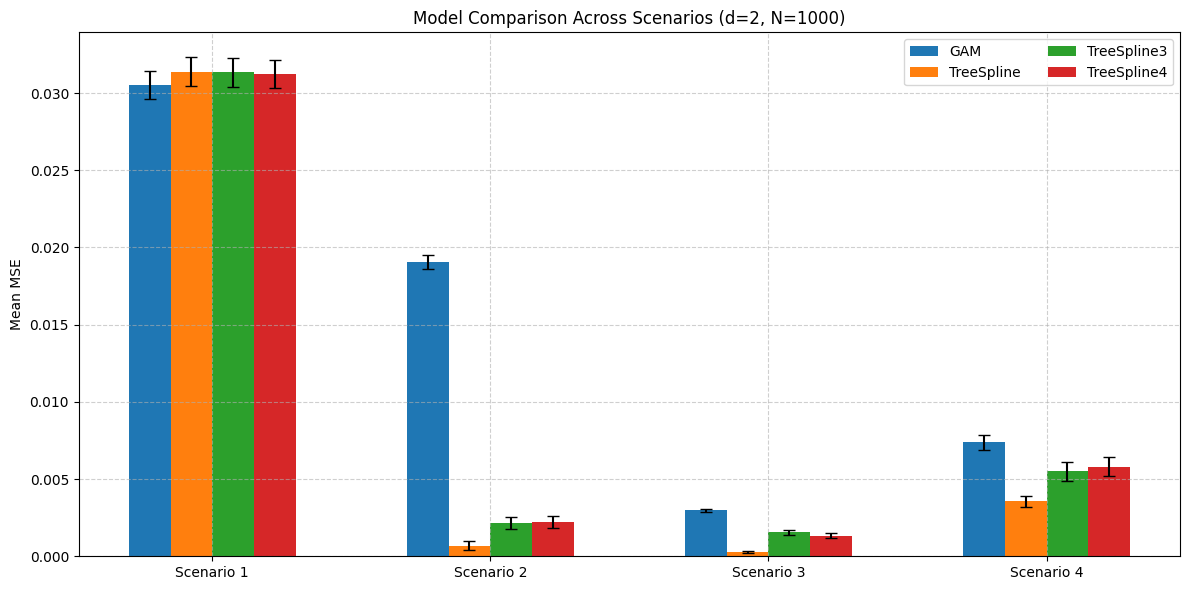

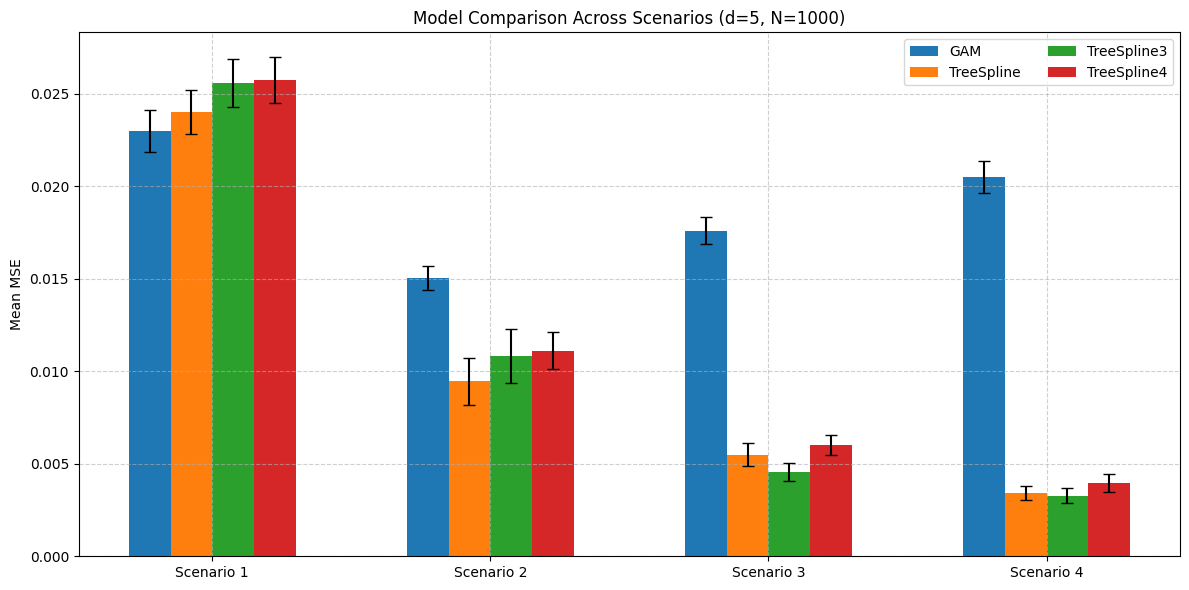

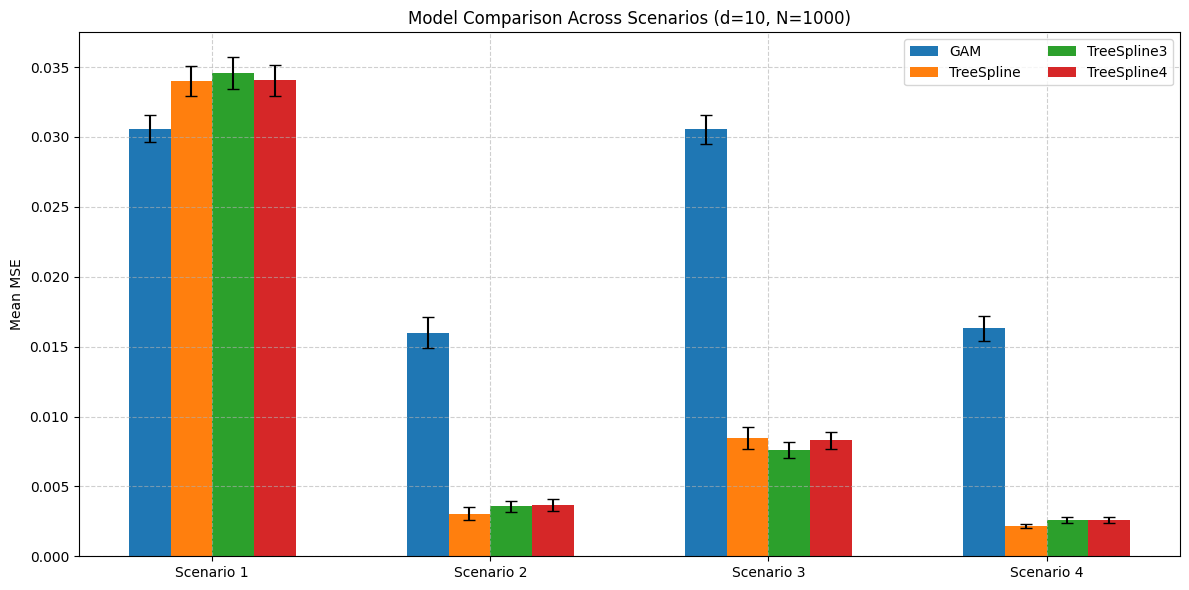

In [13]:
scenarios = ['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4']
x = np.arange(len(scenarios))
width = 0.15
model_labels = ['GAM', 'TreeSpline', 'TreeSpline3', 'TreeSpline4']

# =========================
# d = 2
# =========================
all_mse_vars = [
    gam_mse_hist1000,    # shape (4, 100): scenarios x reps
    tree_mse_hist1000,
    tree3_mse_hist1000,
    tree4_mse_hist1000
]

offsets = np.linspace(-1.5 * width, 1.5 * width, len(all_mse_vars))
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for j, arr in enumerate(all_mse_vars):
    means, cis = compute_ci_stats(arr)  # arr is (4, 100): one 1D vector per scenario
    ax.bar(x + offsets[j], means, width, yerr=cis, capsize=4, label=model_labels[j])

ax.set_title('Model Comparison Across Scenarios (d=2, N=1000)')
ax.set_ylabel('Mean MSE')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(ncol=2, fontsize=10)
plt.tight_layout()
plt.show()

# =========================
# d = 5
# =========================
all_mse_vars = [
    gam_mse_hist10005, 
    tree_mse_hist10005,
    tree3_mse_hist10005,
    tree4_mse_hist10005
]

offsets = np.linspace(-1.5 * width, 1.5 * width, len(all_mse_vars))
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for j, arr in enumerate(all_mse_vars):
    means, cis = compute_ci_stats(arr)  # (4, 100)
    ax.bar(x + offsets[j], means, width, yerr=cis, capsize=4, label=model_labels[j])

ax.set_title('Model Comparison Across Scenarios (d=5, N=1000)')
ax.set_ylabel('Mean MSE')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(ncol=2, fontsize=10)
plt.tight_layout()
plt.show()

# =========================
# d = 10
# =========================
all_mse_vars = [
    gam_mse_hist100010, 
    tree_mse_hist100010,
    tree3_mse_hist100010,
    tree4_mse_hist100010
]

offsets = np.linspace(-1.5 * width, 1.5 * width, len(all_mse_vars))
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for j, arr in enumerate(all_mse_vars):
    means, cis = compute_ci_stats(arr)  # (4, 100)
    ax.bar(x + offsets[j], means, width, yerr=cis, capsize=4, label=model_labels[j])

ax.set_title('Model Comparison Across Scenarios (d=10, N=1000)')
ax.set_ylabel('Mean MSE')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(ncol=2, fontsize=10)
plt.tight_layout()
plt.show()

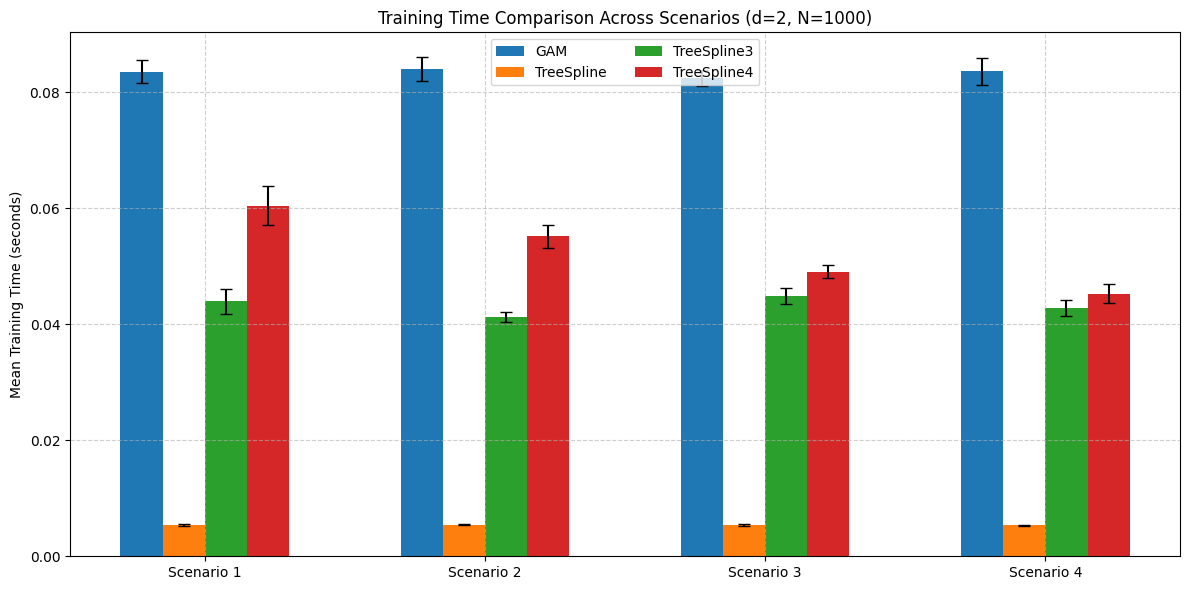

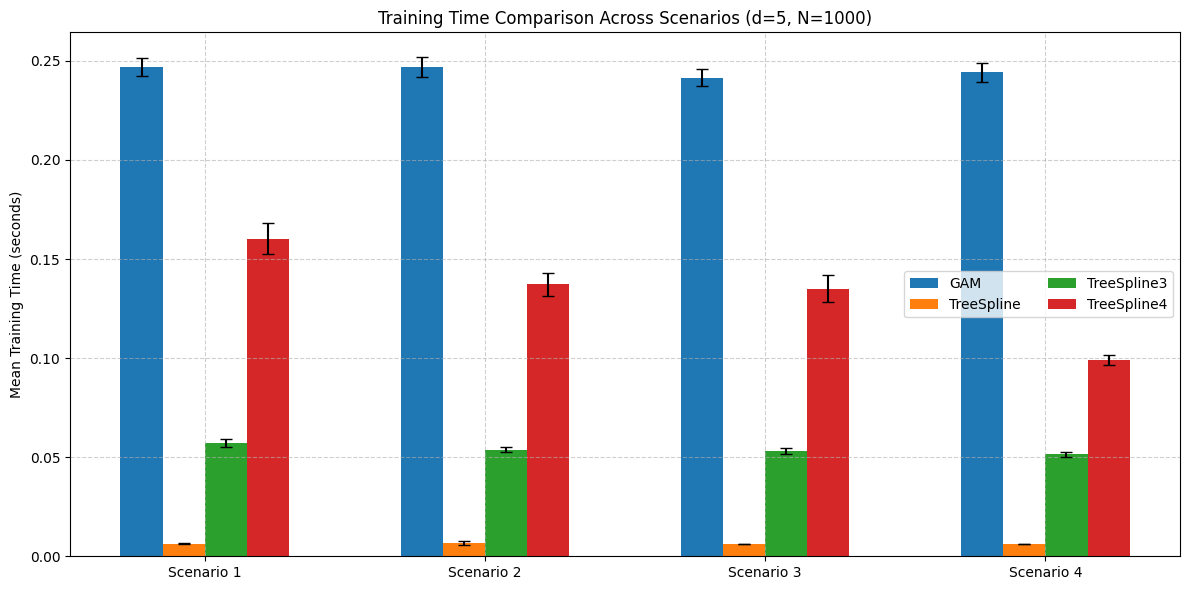

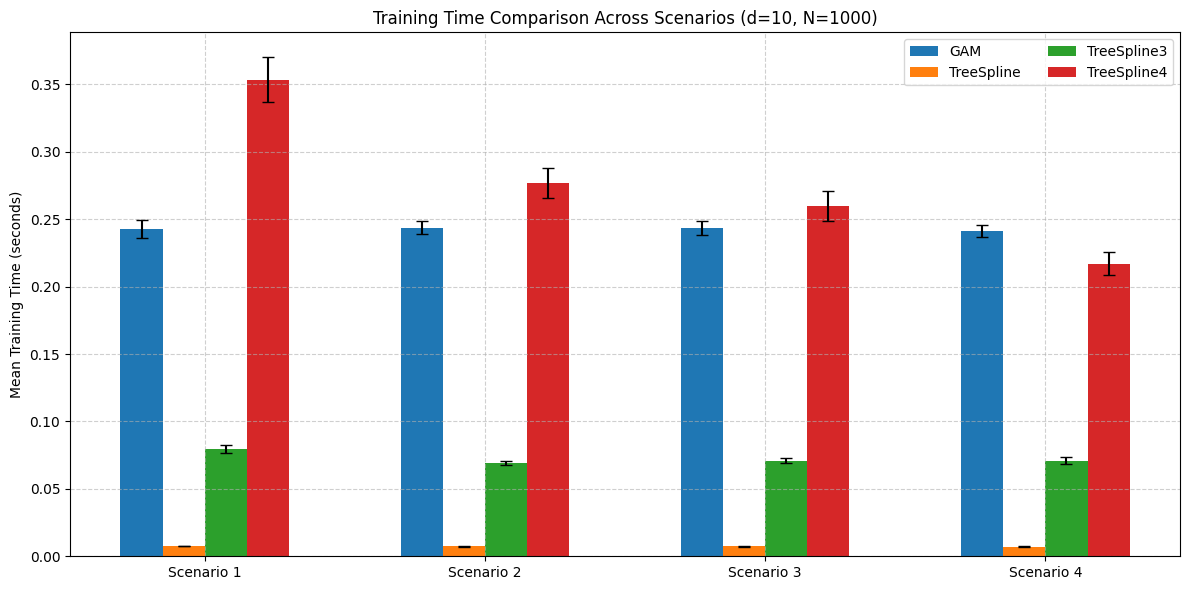

In [18]:
scenarios = ['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4']
x = np.arange(len(scenarios))
width = 0.15
model_labels = ['GAM', 'TreeSpline', 'TreeSpline3', 'TreeSpline4']

# =========================
# d = 2
# =========================
all_time_vars = [
    gam_time_hist1000,
    tree_time_hist1000,
    tree3_time_hist1000,
    tree4_time_hist1000
]

offsets = np.linspace(-1.5 * width, 1.5 * width, len(all_time_vars))
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for j, arr in enumerate(all_time_vars):
    means, cis = compute_ci_stats(arr)  # arr: (4, 100) -> per-scenario mean±CI across reps
    ax.bar(x + offsets[j], means, width, yerr=cis, capsize=4, label=model_labels[j])

ax.set_title('Training Time Comparison Across Scenarios (d=2, N=1000)')
ax.set_ylabel('Mean Training Time (seconds)')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(ncol=2, fontsize=10)
plt.tight_layout()
plt.show()

# =========================
# d = 5
# =========================
all_time_vars = [
    gam_time_hist10005,
    tree_time_hist10005,
    tree3_time_hist10005,
    tree4_time_hist10005
]

offsets = np.linspace(-1.5 * width, 1.5 * width, len(all_time_vars))
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for j, arr in enumerate(all_time_vars):
    means, cis = compute_ci_stats(arr)
    ax.bar(x + offsets[j], means, width, yerr=cis, capsize=4, label=model_labels[j])

ax.set_title('Training Time Comparison Across Scenarios (d=5, N=1000)')
ax.set_ylabel('Mean Training Time (seconds)')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(ncol=2, fontsize=10)
plt.tight_layout()
plt.show()

# =========================
# d = 10
# =========================
all_time_vars = [
    gam_time_hist100010,
    tree_time_hist100010,
    tree3_time_hist100010,
    tree4_time_hist100010
]

offsets = np.linspace(-1.5 * width, 1.5 * width, len(all_time_vars))
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for j, arr in enumerate(all_time_vars):
    means, cis = compute_ci_stats(arr)
    ax.bar(x + offsets[j], means, width, yerr=cis, capsize=4, label=model_labels[j])

ax.set_title('Training Time Comparison Across Scenarios (d=10, N=1000)')
ax.set_ylabel('Mean Training Time (seconds)')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(ncol=2, fontsize=10)
plt.tight_layout()
plt.show()

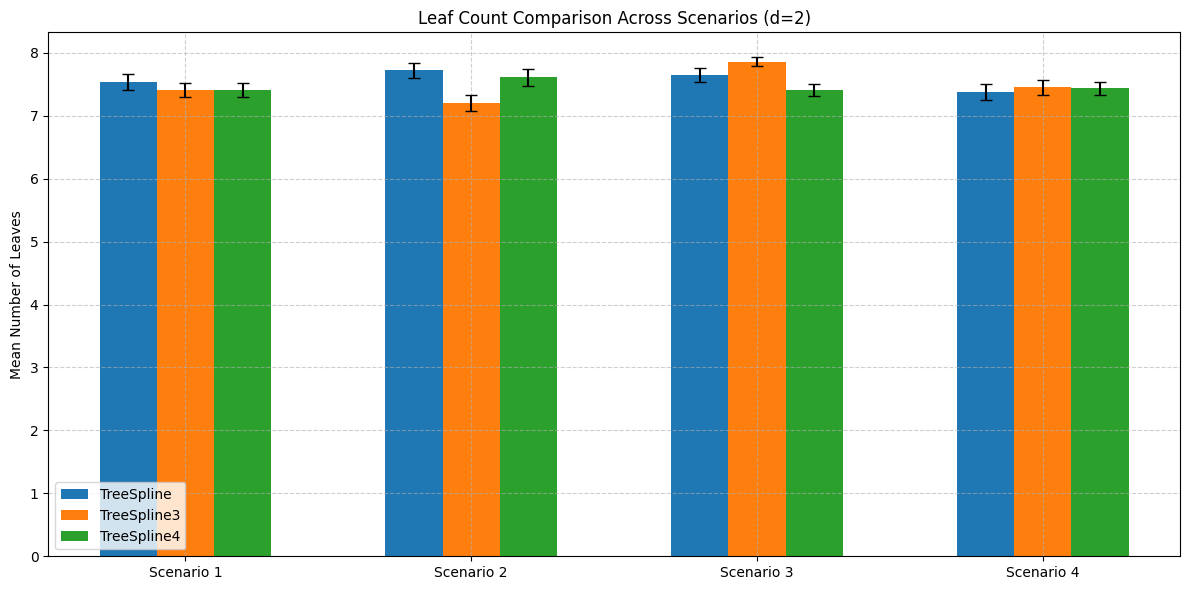

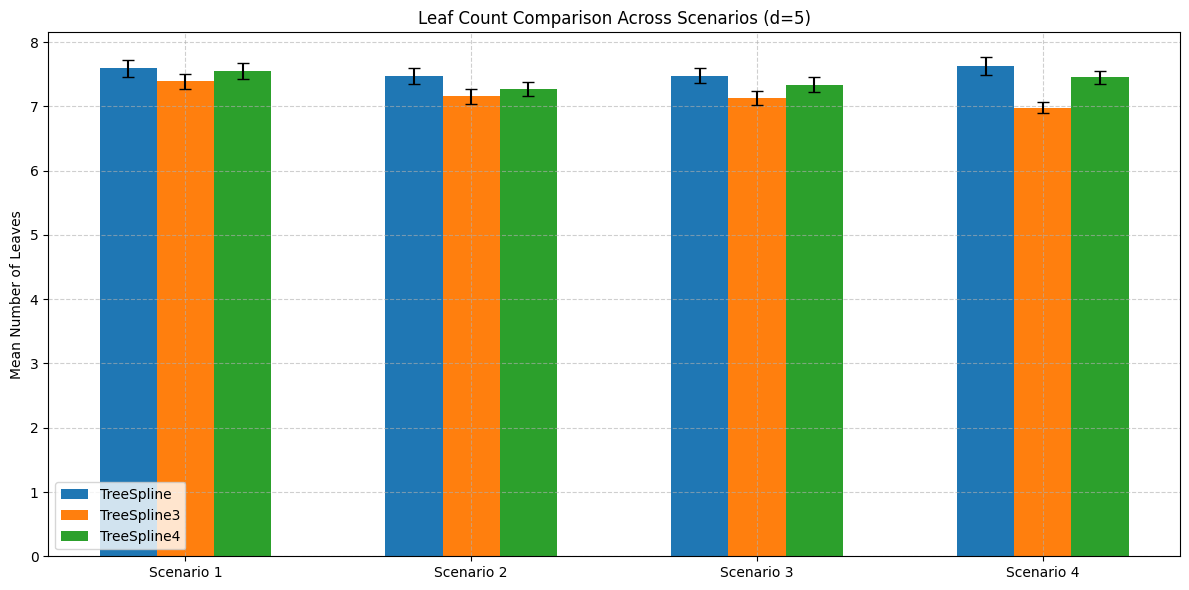

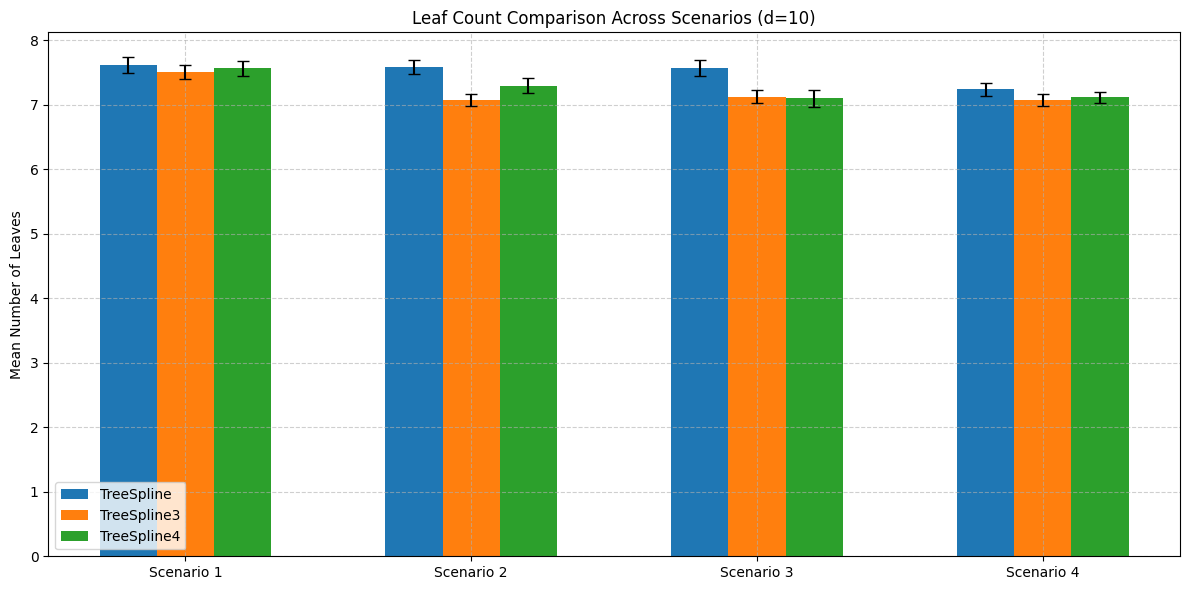

In [19]:
scenarios = ['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4']
x = np.arange(len(scenarios))
labels = ['TreeSpline', 'TreeSpline3', 'TreeSpline4']
n_models = len(labels)
width = 0.2

# =========================
# d = 2  (arrays shape: 4 x 100)
# =========================
leaf_arrays = [
    leaf_hist1000,   # TreeSpline
    leaf3_hist1000,  # TreeSpline3
    leaf4_hist1000   # TreeSpline4
]

offsets = np.linspace(-((n_models-1)/2)*width, ((n_models-1)/2)*width, n_models)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for i, arr in enumerate(leaf_arrays):
    means, cis = compute_ci_stats(arr)   # arr is (4, 100): scenarios x reps
    ax.bar(x + offsets[i], means, width, yerr=cis, capsize=4, label=labels[i])

ax.set_title('Leaf Count Comparison Across Scenarios (d=2)')
ax.set_ylabel('Mean Number of Leaves')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(ncol=1, fontsize=10)
plt.tight_layout()
plt.show()

# =========================
# d = 5
# =========================
leaf_arrays = [
    leaf_hist10005,   # TreeSpline
    leaf3_hist10005,  # TreeSpline3
    leaf4_hist10005   # TreeSpline4
]

offsets = np.linspace(-((n_models-1)/2)*width, ((n_models-1)/2)*width, n_models)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for i, arr in enumerate(leaf_arrays):
    means, cis = compute_ci_stats(arr)
    ax.bar(x + offsets[i], means, width, yerr=cis, capsize=4, label=labels[i])

ax.set_title('Leaf Count Comparison Across Scenarios (d=5)')
ax.set_ylabel('Mean Number of Leaves')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(ncol=1, fontsize=10)
plt.tight_layout()
plt.show()

# =========================
# d = 10
# =========================
leaf_arrays = [
    leaf_hist100010,   # TreeSpline
    leaf3_hist100010,  # TreeSpline3
    leaf4_hist100010   # TreeSpline4
]

offsets = np.linspace(-((n_models-1)/2)*width, ((n_models-1)/2)*width, n_models)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for i, arr in enumerate(leaf_arrays):
    means, cis = compute_ci_stats(arr)
    ax.bar(x + offsets[i], means, width, yerr=cis, capsize=4, label=labels[i])

ax.set_title('Leaf Count Comparison Across Scenarios (d=10)')
ax.set_ylabel('Mean Number of Leaves')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(ncol=1, fontsize=10)
plt.tight_layout()
plt.show()

# Testing with different sample sizes (correlated features)

HAS TO BE FUCKING REPEATED BITCHHHHHH

## N = 50

In [15]:
n_samples = 50
repeats = 100

gam_mse_corr1hist50 = np.zeros((4, repeats))
gam_time_corr1hist50 = np.zeros((4, repeats))

leaf_corr1hist50 = np.zeros((4, repeats))
tree_mse_corr1hist50 = np.zeros((4, repeats))
tree_time_corr1hist50 = np.zeros((4, repeats))

tree3_mse_corr1hist50 = np.zeros((4, repeats))
tree3_time_corr1hist50 = np.zeros((4, repeats))
leaf3_corr1hist50 = np.zeros((4, repeats))

tree4_mse_corr1hist50 = np.zeros((4, repeats))
tree4_time_corr1hist50 = np.zeros((4, repeats))
leaf4_corr1hist50 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr1hist50[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr1hist50[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr1hist50[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr1hist50[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr1hist50[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr1hist50[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr1hist50[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr1hist50[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr1hist50[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr1hist50[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr1hist50[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 1 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 3 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 5 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 8 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 10 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 11 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 12 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 18 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 19 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 21 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 22 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 23 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 25 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 26 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 27 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 28 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 30 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 31 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 34 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 35 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 37 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 40 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 42 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 46 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 49 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 50 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 54 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 56 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 57 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 58 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 60 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 61 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 62 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 63 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 68 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 69 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 70 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 71 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 72 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 73 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 75 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 76 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 77 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 78 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 79 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 80 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 81 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 82 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 83 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 85 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 86 done! ---



 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 87 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 88 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 89 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 90 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 91 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 93 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 94 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 95 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 99 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [16]:
n_samples = 50
repeats = 100

gam_mse_corr3hist50 = np.zeros((4, repeats))
gam_time_corr3hist50 = np.zeros((4, repeats))

leaf_corr3hist50 = np.zeros((4, repeats))
tree_mse_corr3hist50 = np.zeros((4, repeats))
tree_time_corr3hist50 = np.zeros((4, repeats))

tree3_mse_corr3hist50 = np.zeros((4, repeats))
tree3_time_corr3hist50 = np.zeros((4, repeats))
leaf3_corr3hist50 = np.zeros((4, repeats))

tree4_mse_corr3hist50 = np.zeros((4, repeats))
tree4_time_corr3hist50 = np.zeros((4, repeats))
leaf4_corr3hist50 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.3)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr3hist50[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr3hist50[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr3hist50[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr3hist50[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr3hist50[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr3hist50[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr3hist50[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr3hist50[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr3hist50[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr3hist50[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr3hist50[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 2 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 7 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 8 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 9 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 12 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 13 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 20 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 22 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 25 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 27 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 28 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 30 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 32 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 33 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 34 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 41 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 42 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 43 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 45 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 48 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 49 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 51 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 53 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 55 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 57 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 59 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 63 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 65 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 67 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 68 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 71 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 72 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 75 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 77 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 85 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 90 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 91 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 92 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 93 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 94 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 95 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 99 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [17]:
n_samples = 50
repeats = 100

gam_mse_corr5hist50 = np.zeros((4, repeats))
gam_time_corr5hist50 = np.zeros((4, repeats))

leaf_corr5hist50 = np.zeros((4, repeats))
tree_mse_corr5hist50 = np.zeros((4, repeats))
tree_time_corr5hist50 = np.zeros((4, repeats))

tree3_mse_corr5hist50 = np.zeros((4, repeats))
tree3_time_corr5hist50 = np.zeros((4, repeats))
leaf3_corr5hist50 = np.zeros((4, repeats))

tree4_mse_corr5hist50 = np.zeros((4, repeats))
tree4_time_corr5hist50 = np.zeros((4, repeats))
leaf4_corr5hist50 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.5)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr5hist50[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr5hist50[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr5hist50[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr5hist50[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr5hist50[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr5hist50[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr5hist50[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr5hist50[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr5hist50[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr5hist50[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr5hist50[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |#######################


--- Repetition no. 1 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 2 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 4 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 6 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 7 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 12 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 13 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 14 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 15 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 16 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 18 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 19 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 21 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 23 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 26 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 27 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 29 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 31 done! ---



 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 33 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 35 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 39 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 40 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 43 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 45 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 46 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 47 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 48 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 51 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 52 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 53 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 54 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 60 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 61 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 63 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 68 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 71 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 72 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 75 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 76 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 78 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 80 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 81 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 83 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 84 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 86 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 87 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 88 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 89 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 93 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 94 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 95 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 96 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 97 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 98 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



## N = 200

In [18]:
n_samples = 200
repeats = 100

gam_mse_corr1hist200 = np.zeros((4, repeats))
gam_time_corr1hist200 = np.zeros((4, repeats))

leaf_corr1hist200 = np.zeros((4, repeats))
tree_mse_corr1hist200 = np.zeros((4, repeats))
tree_time_corr1hist200 = np.zeros((4, repeats))

tree3_mse_corr1hist200 = np.zeros((4, repeats))
tree3_time_corr1hist200 = np.zeros((4, repeats))
leaf3_corr1hist200 = np.zeros((4, repeats))

tree4_mse_corr1hist200 = np.zeros((4, repeats))
tree4_time_corr1hist200 = np.zeros((4, repeats))
leaf4_corr1hist200 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr1hist200[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr1hist200[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr1hist200[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr1hist200[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr1hist200[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr1hist200[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr1hist200[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr1hist200[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr1hist200[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr1hist200[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr1hist200[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 2 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 3 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 5 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 13 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 14 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 15 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 17 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00



--- Repetition no. 18 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 19 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 22 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 24 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 25 done! ---



 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 30 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 31 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 32 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 33 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 39 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 40 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 44 done! ---



 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 54 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 55 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 56 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 59 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 60 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 61 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 63 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 64 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 65 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 73 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 74 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 79 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 80 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 81 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 83 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 84 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 85 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 90 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 96 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [19]:
n_samples = 200
repeats = 100

gam_mse_corr3hist200 = np.zeros((4, repeats))
gam_time_corr3hist200 = np.zeros((4, repeats))

leaf_corr3hist200 = np.zeros((4, repeats))
tree_mse_corr3hist200 = np.zeros((4, repeats))
tree_time_corr3hist200 = np.zeros((4, repeats))

tree3_mse_corr3hist200 = np.zeros((4, repeats))
tree3_time_corr3hist200 = np.zeros((4, repeats))
leaf3_corr3hist200 = np.zeros((4, repeats))

tree4_mse_corr3hist200 = np.zeros((4, repeats))
tree4_time_corr3hist200 = np.zeros((4, repeats))
leaf4_corr3hist200 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.3)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr3hist200[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr3hist200[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr3hist200[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr3hist200[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr3hist200[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr3hist200[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr3hist200[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr3hist200[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr3hist200[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr3hist200[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr3hist200[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 1 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 5 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 6 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 7 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 8 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 9 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 10 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 13 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 24 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 29 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 32 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 37 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 44 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 45 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 47 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 51 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 57 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 58 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 60 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 64 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 65 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 68 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 74 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 77 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 81 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 84 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 87 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 88 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 89 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [20]:
n_samples = 200
repeats = 100

gam_mse_corr5hist200 = np.zeros((4, repeats))
gam_time_corr5hist200 = np.zeros((4, repeats))

leaf_corr5hist200 = np.zeros((4, repeats))
tree_mse_corr5hist200 = np.zeros((4, repeats))
tree_time_corr5hist200 = np.zeros((4, repeats))

tree3_mse_corr5hist200 = np.zeros((4, repeats))
tree3_time_corr5hist200 = np.zeros((4, repeats))
leaf3_corr5hist200 = np.zeros((4, repeats))

tree4_mse_corr5hist200 = np.zeros((4, repeats))
tree4_time_corr5hist200 = np.zeros((4, repeats))
leaf4_corr5hist200 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.5)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr5hist200[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr5hist200[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr5hist200[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr5hist200[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr5hist200[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr5hist200[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr5hist200[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr5hist200[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr5hist200[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr5hist200[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr5hist200[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 1 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 12 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 13 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 14 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 15 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 17 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 19 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 21 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 23 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 28 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 29 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 30 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 33 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 35 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 40 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 42 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 43 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 46 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 50 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 54 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 58 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 59 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 61 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 68 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 69 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00



--- Repetition no. 70 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 72 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 74 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 78 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 83 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 86 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 90 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 95 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 98 done! ---



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



## N = 1000

In [21]:
n_samples = 1000
repeats = 100

gam_mse_corr1hist1000 = np.zeros((4, repeats))
gam_time_corr1hist1000 = np.zeros((4, repeats))

leaf_corr1hist1000 = np.zeros((4, repeats))
tree_mse_corr1hist1000 = np.zeros((4, repeats))
tree_time_corr1hist1000 = np.zeros((4, repeats))

tree3_mse_corr1hist1000 = np.zeros((4, repeats))
tree3_time_corr1hist1000 = np.zeros((4, repeats))
leaf3_corr1hist1000 = np.zeros((4, repeats))

tree4_mse_corr1hist1000 = np.zeros((4, repeats))
tree4_time_corr1hist1000 = np.zeros((4, repeats))
leaf4_corr1hist1000 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr1hist1000[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr1hist1000[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr1hist1000[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr1hist1000[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr1hist1000[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr1hist1000[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr1hist1000[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr1hist1000[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr1hist1000[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr1hist1000[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr1hist1000[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 3 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 4 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 8 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 10 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 13 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 14 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 16 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 17 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 19 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 20 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 21 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 25 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 26 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 28 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 29 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 30 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 32 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 33 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 34 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 36 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 37 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 38 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 39 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 40 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 42 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 43 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 44 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 45 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 46 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 47 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 48 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 50 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 52 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 56 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 59 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 63 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 65 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 66 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 68 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 69 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 70 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 71 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 72 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 73 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 74 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 76 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 85 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 92 done! ---



 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 95 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 96 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 98 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [22]:
n_samples = 1000
repeats = 100

gam_mse_corr3hist1000 = np.zeros((4, repeats))
gam_time_corr3hist1000 = np.zeros((4, repeats))

leaf_corr3hist1000 = np.zeros((4, repeats))
tree_mse_corr3hist1000 = np.zeros((4, repeats))
tree_time_corr3hist1000 = np.zeros((4, repeats))

tree3_mse_corr3hist1000 = np.zeros((4, repeats))
tree3_time_corr3hist1000 = np.zeros((4, repeats))
leaf3_corr3hist1000 = np.zeros((4, repeats))

tree4_mse_corr3hist1000 = np.zeros((4, repeats))
tree4_time_corr3hist1000 = np.zeros((4, repeats))
leaf4_corr3hist1000 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.3)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr3hist1000[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr3hist1000[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr3hist1000[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr3hist1000[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr3hist1000[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr3hist1000[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr3hist1000[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr3hist1000[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr3hist1000[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr3hist1000[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr3hist1000[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 7 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 12 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 13 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 19 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 20 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 21 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 22 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 28 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 29 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 32 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 33 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 34 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 35 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 36 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############         


--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 43 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 47 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 48 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 52 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 53 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 54 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 55 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 58 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 60 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 62 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 64 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 65 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 67 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 69 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 71 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 74 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 75 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 80 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 81 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 83 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 84 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 85 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 86 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 90 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 91 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 93 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 94 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 95 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [23]:
n_samples = 1000
repeats = 100

gam_mse_corr5hist1000 = np.zeros((4, repeats))
gam_time_corr5hist1000 = np.zeros((4, repeats))

leaf_corr5hist1000 = np.zeros((4, repeats))
tree_mse_corr5hist1000 = np.zeros((4, repeats))
tree_time_corr5hist1000 = np.zeros((4, repeats))

tree3_mse_corr5hist1000 = np.zeros((4, repeats))
tree3_time_corr5hist1000 = np.zeros((4, repeats))
leaf3_corr5hist1000 = np.zeros((4, repeats))

tree4_mse_corr5hist1000 = np.zeros((4, repeats))
tree4_time_corr5hist1000 = np.zeros((4, repeats))
leaf4_corr5hist1000 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.5)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr5hist1000[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr5hist1000[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr5hist1000[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr5hist1000[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr5hist1000[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr5hist1000[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr5hist1000[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr5hist1000[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr5hist1000[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr5hist1000[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr5hist1000[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 2 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 6 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 7 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 9 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 10 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 11 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 12 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 15 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 16 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 17 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 18 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 20 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 21 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 22 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 23 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 26 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 27 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 28 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 29 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 31 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 32 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 39 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 42 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 43 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 44 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 45 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 47 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 48 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 53 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 54 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 55 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 56 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 59 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 62 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 63 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 64 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 68 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 70 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 71 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 72 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 73 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 74 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 75 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 76 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 79 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 80 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 82 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 83 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 84 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 86 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 87 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 91 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 92 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



--- Repetition no. 93 done! ---



 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 95 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 98 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



## N = 10000

In [24]:
n_samples = 10000
repeats = 100

gam_mse_corr1hist10000 = np.zeros((4, repeats))
gam_time_corr1hist10000 = np.zeros((4, repeats))

leaf_corr1hist10000 = np.zeros((4, repeats))
tree_mse_corr1hist10000 = np.zeros((4, repeats))
tree_time_corr1hist10000 = np.zeros((4, repeats))

tree3_mse_corr1hist10000 = np.zeros((4, repeats))
tree3_time_corr1hist10000 = np.zeros((4, repeats))
leaf3_corr1hist10000 = np.zeros((4, repeats))

tree4_mse_corr1hist10000 = np.zeros((4, repeats))
tree4_time_corr1hist10000 = np.zeros((4, repeats))
leaf4_corr1hist10000 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr1hist10000[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr1hist10000[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr1hist10000[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr1hist10000[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr1hist10000[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr1hist10000[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr1hist10000[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr1hist10000[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr1hist10000[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr1hist10000[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr1hist10000[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################  


--- Repetition no. 1 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 2 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 3 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 4 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 5 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 6 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 7 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 8 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 9 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 10 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 11 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 12 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 13 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 14 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 15 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 16 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 17 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 18 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 19 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 20 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 21 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 22 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 23 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 24 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 25 done! ---



 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 26 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 27 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 28 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 29 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 30 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 31 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 32 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 33 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 34 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 35 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 36 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 37 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 38 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 39 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 40 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 41 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 42 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 43 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 44 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 45 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 46 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 47 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 48 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 49 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 50 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 51 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 52 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 53 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 54 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 55 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 56 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 57 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 58 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 59 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 60 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 61 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 62 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 63 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 64 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 65 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 66 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 67 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 68 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 69 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 70 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 71 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 72 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 73 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 74 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 75 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 76 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 77 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 78 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 79 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 80 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 81 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 82 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 83 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 84 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 85 done! ---



 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 86 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 87 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 88 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 89 done! ---



 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 90 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 91 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 92 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 93 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 94 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 95 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 96 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 97 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 98 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 99 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 100 done! ---



In [25]:
n_samples = 10000
repeats = 100

gam_mse_corr3hist10000 = np.zeros((4, repeats))
gam_time_corr3hist10000 = np.zeros((4, repeats))

leaf_corr3hist10000 = np.zeros((4, repeats))
tree_mse_corr3hist10000 = np.zeros((4, repeats))
tree_time_corr3hist10000 = np.zeros((4, repeats))

tree3_mse_corr3hist10000 = np.zeros((4, repeats))
tree3_time_corr3hist10000 = np.zeros((4, repeats))
leaf3_corr3hist10000 = np.zeros((4, repeats))

tree4_mse_corr3hist10000 = np.zeros((4, repeats))
tree4_time_corr3hist10000 = np.zeros((4, repeats))
leaf4_corr3hist10000 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.3)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr3hist10000[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr3hist10000[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr3hist10000[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr3hist10000[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr3hist10000[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr3hist10000[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr3hist10000[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr3hist10000[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr3hist10000[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr3hist10000[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr3hist10000[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################  


--- Repetition no. 1 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 2 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 3 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 4 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 5 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 6 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 7 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 8 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 9 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 10 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 11 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 12 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                  


--- Repetition no. 13 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 14 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 15 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 16 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 17 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 18 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 19 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 20 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 21 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 22 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 23 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 24 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 25 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 26 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 27 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 28 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 29 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 30 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 31 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 32 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 33 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 34 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 35 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 36 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 37 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 38 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 39 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 40 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 41 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 42 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 43 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 44 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 45 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 46 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 47 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 48 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 49 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 50 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 51 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 52 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 53 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 54 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 55 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 56 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 57 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 58 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 59 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                  


--- Repetition no. 60 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 61 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 62 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 63 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 64 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 65 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 66 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 67 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 68 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 69 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 70 done! ---



 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 71 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 72 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 73 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 74 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 75 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 76 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 77 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 78 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 79 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 80 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 81 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 82 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 83 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 84 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 85 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 86 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 87 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 88 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 89 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 90 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 91 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 92 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 93 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 94 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 95 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 96 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 97 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 98 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 99 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 100 done! ---



In [26]:
n_samples = 10000
repeats = 100

gam_mse_corr5hist10000 = np.zeros((4, repeats))
gam_time_corr5hist10000 = np.zeros((4, repeats))

leaf_corr5hist10000 = np.zeros((4, repeats))
tree_mse_corr5hist10000 = np.zeros((4, repeats))
tree_time_corr5hist10000 = np.zeros((4, repeats))

tree3_mse_corr5hist10000 = np.zeros((4, repeats))
tree3_time_corr5hist10000 = np.zeros((4, repeats))
leaf3_corr5hist10000 = np.zeros((4, repeats))

tree4_mse_corr5hist10000 = np.zeros((4, repeats))
tree4_time_corr5hist10000 = np.zeros((4, repeats))
leaf4_corr5hist10000 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.5)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr5hist10000[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr5hist10000[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr5hist10000[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr5hist10000[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr5hist10000[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr5hist10000[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr5hist10000[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr5hist10000[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr5hist10000[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr5hist10000[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr5hist10000[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################  


--- Repetition no. 1 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 2 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 3 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 4 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 5 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 6 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 7 done! ---



 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 8 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 9 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 10 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 11 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 12 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 13 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 14 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 15 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 16 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 17 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 18 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 19 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 20 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 21 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 22 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 23 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 24 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 25 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 26 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 27 done! ---



 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 28 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 29 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 30 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 31 done! ---



 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 32 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 33 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 34 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 35 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 36 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 37 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 38 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 39 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 40 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 41 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 42 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 43 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 44 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 45 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 46 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 47 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 48 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 49 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 50 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 51 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 52 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 53 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 54 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 55 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 56 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 57 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 58 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 59 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 60 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 61 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 62 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 63 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 64 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 65 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 66 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 67 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 68 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 69 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 70 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 71 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 72 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 73 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 74 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 75 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 76 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 77 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 78 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 79 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 80 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 81 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 82 done! ---



 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 83 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 84 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 85 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 86 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 87 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 88 done! ---



 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    


--- Repetition no. 89 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 90 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 91 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 92 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 93 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 94 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 95 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 96 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 97 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 98 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 99 done! ---



 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########               


--- Repetition no. 100 done! ---



In [29]:
np.save('nparrs/gam_mse_corr1hist50.npy', gam_mse_corr1hist50)
np.save('nparrs/gam_time_corr1hist50.npy', gam_time_corr1hist50)
np.save('nparrs/tree_mse_corr1hist50.npy', tree_mse_corr1hist50)
np.save('nparrs/tree_time_corr1hist50.npy', tree_time_corr1hist50)
np.save('nparrs/leaf_corr1hist50.npy', leaf_corr1hist50)
np.save('nparrs/tree3_mse_corr1hist50.npy', tree3_mse_corr1hist50)
np.save('nparrs/tree3_time_corr1hist50.npy', tree3_time_corr1hist50)
np.save('nparrs/leaf3_corr1hist50.npy', leaf3_corr1hist50)
np.save('nparrs/tree4_mse_corr1hist50.npy', tree4_mse_corr1hist50)
np.save('nparrs/tree4_time_corr1hist50.npy', tree4_time_corr1hist50)
np.save('nparrs/leaf4_corr1hist50.npy', leaf4_corr1hist50)

np.save('nparrs/gam_mse_corr3hist50.npy', gam_mse_corr3hist50)
np.save('nparrs/gam_time_corr3hist50.npy', gam_time_corr3hist50)
np.save('nparrs/tree_mse_corr3hist50.npy', tree_mse_corr3hist50)
np.save('nparrs/tree_time_corr3hist50.npy', tree_time_corr3hist50)
np.save('nparrs/leaf_corr3hist50.npy', leaf_corr3hist50)
np.save('nparrs/tree3_mse_corr3hist50.npy', tree3_mse_corr3hist50)
np.save('nparrs/tree3_time_corr3hist50.npy', tree3_time_corr3hist50)
np.save('nparrs/leaf3_corr3hist50.npy', leaf3_corr3hist50)
np.save('nparrs/tree4_mse_corr3hist50.npy', tree4_mse_corr3hist50)
np.save('nparrs/tree4_time_corr3hist50.npy', tree4_time_corr3hist50)
np.save('nparrs/leaf4_corr3hist50.npy', leaf4_corr3hist50)

np.save('nparrs/gam_mse_corr5hist50.npy', gam_mse_corr5hist50)
np.save('nparrs/gam_time_corr5hist50.npy', gam_time_corr5hist50)
np.save('nparrs/tree_mse_corr5hist50.npy', tree_mse_corr5hist50)
np.save('nparrs/tree_time_corr5hist50.npy', tree_time_corr5hist50)
np.save('nparrs/leaf_corr5hist50.npy', leaf_corr5hist50)
np.save('nparrs/tree3_mse_corr5hist50.npy', tree3_mse_corr5hist50)
np.save('nparrs/tree3_time_corr5hist50.npy', tree3_time_corr5hist50)
np.save('nparrs/leaf3_corr5hist50.npy', leaf3_corr5hist50)
np.save('nparrs/tree4_mse_corr5hist50.npy', tree4_mse_corr5hist50)
np.save('nparrs/tree4_time_corr5hist50.npy', tree4_time_corr5hist50)
np.save('nparrs/leaf4_corr5hist50.npy', leaf4_corr5hist50)


# ------------------------------------------------------------------------------

np.save('nparrs/gam_mse_corr1hist200.npy', gam_mse_corr1hist200)
np.save('nparrs/gam_time_corr1hist200.npy', gam_time_corr1hist200)
np.save('nparrs/tree_mse_corr1hist200.npy', tree_mse_corr1hist200)
np.save('nparrs/tree_time_corr1hist200.npy', tree_time_corr1hist200)
np.save('nparrs/leaf_corr1hist200.npy', leaf_corr1hist200)
np.save('nparrs/tree3_mse_corr1hist200.npy', tree3_mse_corr1hist200)
np.save('nparrs/tree3_time_corr1hist200.npy', tree3_time_corr1hist200)
np.save('nparrs/leaf3_corr1hist200.npy', leaf3_corr1hist200)
np.save('nparrs/tree4_mse_corr1hist200.npy', tree4_mse_corr1hist200)
np.save('nparrs/tree4_time_corr1hist200.npy', tree4_time_corr1hist200)
np.save('nparrs/leaf4_corr1hist200.npy', leaf4_corr1hist200)

np.save('nparrs/gam_mse_corr3hist200.npy', gam_mse_corr3hist200)
np.save('nparrs/gam_time_corr3hist200.npy', gam_time_corr3hist200)
np.save('nparrs/tree_mse_corr3hist200.npy', tree_mse_corr3hist200)
np.save('nparrs/tree_time_corr3hist200.npy', tree_time_corr3hist200)
np.save('nparrs/leaf_corr3hist200.npy', leaf_corr3hist200)
np.save('nparrs/tree3_mse_corr3hist200.npy', tree3_mse_corr3hist200)
np.save('nparrs/tree3_time_corr3hist200.npy', tree3_time_corr3hist200)
np.save('nparrs/leaf3_corr3hist200.npy', leaf3_corr3hist200)
np.save('nparrs/tree4_mse_corr3hist200.npy', tree4_mse_corr3hist200)
np.save('nparrs/tree4_time_corr3hist200.npy', tree4_time_corr3hist200)
np.save('nparrs/leaf4_corr3hist200.npy', leaf4_corr3hist200)

np.save('nparrs/gam_mse_corr5hist200.npy', gam_mse_corr5hist200)
np.save('nparrs/gam_time_corr5hist200.npy', gam_time_corr5hist200)
np.save('nparrs/tree_mse_corr5hist200.npy', tree_mse_corr5hist200)
np.save('nparrs/tree_time_corr5hist200.npy', tree_time_corr5hist200)
np.save('nparrs/leaf_corr5hist200.npy', leaf_corr5hist200)
np.save('nparrs/tree3_mse_corr5hist200.npy', tree3_mse_corr5hist200)
np.save('nparrs/tree3_time_corr5hist200.npy', tree3_time_corr5hist200)
np.save('nparrs/leaf3_corr5hist200.npy', leaf3_corr5hist200)
np.save('nparrs/tree4_mse_corr5hist200.npy', tree4_mse_corr5hist200)
np.save('nparrs/tree4_time_corr5hist200.npy', tree4_time_corr5hist200)
np.save('nparrs/leaf4_corr5hist200.npy', leaf4_corr5hist200)

# ------------------------------------------------------------------------------

np.save('nparrs/gam_mse_corr1hist1000.npy', gam_mse_corr1hist1000)
np.save('nparrs/gam_time_corr1hist1000.npy', gam_time_corr1hist1000)
np.save('nparrs/tree_mse_corr1hist1000.npy', tree_mse_corr1hist1000)
np.save('nparrs/tree_time_corr1hist1000.npy', tree_time_corr1hist1000)
np.save('nparrs/leaf_corr1hist1000.npy', leaf_corr1hist1000)
np.save('nparrs/tree3_mse_corr1hist1000.npy', tree3_mse_corr1hist1000)
np.save('nparrs/tree3_time_corr1hist1000.npy', tree3_time_corr1hist1000)
np.save('nparrs/leaf3_corr1hist1000.npy', leaf3_corr1hist1000)
np.save('nparrs/tree4_mse_corr1hist1000.npy', tree4_mse_corr1hist1000)
np.save('nparrs/tree4_time_corr1hist1000.npy', tree4_time_corr1hist1000)
np.save('nparrs/leaf4_corr1hist1000.npy', leaf4_corr1hist1000)

np.save('nparrs/gam_mse_corr3hist1000.npy', gam_mse_corr3hist1000)
np.save('nparrs/gam_time_corr3hist1000.npy', gam_time_corr3hist1000)
np.save('nparrs/tree_mse_corr3hist1000.npy', tree_mse_corr3hist1000)
np.save('nparrs/tree_time_corr3hist1000.npy', tree_time_corr3hist1000)
np.save('nparrs/leaf_corr3hist1000.npy', leaf_corr3hist1000)
np.save('nparrs/tree3_mse_corr3hist1000.npy', tree3_mse_corr3hist1000)
np.save('nparrs/tree3_time_corr3hist1000.npy', tree3_time_corr3hist1000)
np.save('nparrs/leaf3_corr3hist1000.npy', leaf3_corr3hist1000)
np.save('nparrs/tree4_mse_corr3hist1000.npy', tree4_mse_corr3hist1000)
np.save('nparrs/tree4_time_corr3hist1000.npy', tree4_time_corr3hist1000)
np.save('nparrs/leaf4_corr3hist1000.npy', leaf4_corr3hist1000)

np.save('nparrs/gam_mse_corr5hist1000.npy', gam_mse_corr5hist1000)
np.save('nparrs/gam_time_corr5hist1000.npy', gam_time_corr5hist1000)
np.save('nparrs/tree_mse_corr5hist1000.npy', tree_mse_corr5hist1000)
np.save('nparrs/tree_time_corr5hist1000.npy', tree_time_corr5hist1000)
np.save('nparrs/leaf_corr5hist1000.npy', leaf_corr5hist1000)
np.save('nparrs/tree3_mse_corr5hist1000.npy', tree3_mse_corr5hist1000)
np.save('nparrs/tree3_time_corr5hist1000.npy', tree3_time_corr5hist1000)
np.save('nparrs/leaf3_corr5hist1000.npy', leaf3_corr5hist1000)
np.save('nparrs/tree4_mse_corr5hist1000.npy', tree4_mse_corr5hist1000)
np.save('nparrs/tree4_time_corr5hist1000.npy', tree4_time_corr5hist1000)
np.save('nparrs/leaf4_corr5hist1000.npy', leaf4_corr5hist1000)

# ------------------------------------------------------------------------------

np.save('nparrs/gam_mse_corr1hist10000.npy', gam_mse_corr1hist10000)
np.save('nparrs/gam_time_corr1hist10000.npy', gam_time_corr1hist10000)
np.save('nparrs/tree_mse_corr1hist10000.npy', tree_mse_corr1hist10000)
np.save('nparrs/tree_time_corr1hist10000.npy', tree_time_corr1hist10000)
np.save('nparrs/leaf_corr1hist10000.npy', leaf_corr1hist10000)
np.save('nparrs/tree3_mse_corr1hist10000.npy', tree3_mse_corr1hist10000)
np.save('nparrs/tree3_time_corr1hist10000.npy', tree3_time_corr1hist10000)
np.save('nparrs/leaf3_corr1hist10000.npy', leaf3_corr1hist10000)
np.save('nparrs/tree4_mse_corr1hist10000.npy', tree4_mse_corr1hist10000)
np.save('nparrs/tree4_time_corr1hist10000.npy', tree4_time_corr1hist10000)
np.save('nparrs/leaf4_corr1hist10000.npy', leaf4_corr1hist10000)

np.save('nparrs/gam_mse_corr3hist10000.npy', gam_mse_corr3hist10000)
np.save('nparrs/gam_time_corr3hist10000.npy', gam_time_corr3hist10000)
np.save('nparrs/tree_mse_corr3hist10000.npy', tree_mse_corr3hist10000)
np.save('nparrs/tree_time_corr3hist10000.npy', tree_time_corr3hist10000)
np.save('nparrs/leaf_corr3hist10000.npy', leaf_corr3hist10000)
np.save('nparrs/tree3_mse_corr3hist10000.npy', tree3_mse_corr3hist10000)
np.save('nparrs/tree3_time_corr3hist10000.npy', tree3_time_corr3hist10000)
np.save('nparrs/leaf3_corr3hist10000.npy', leaf3_corr3hist10000)
np.save('nparrs/tree4_mse_corr3hist10000.npy', tree4_mse_corr3hist10000)
np.save('nparrs/tree4_time_corr3hist10000.npy', tree4_time_corr3hist10000)
np.save('nparrs/leaf4_corr3hist10000.npy', leaf4_corr3hist10000)

np.save('nparrs/gam_mse_corr5hist10000.npy', gam_mse_corr5hist10000)
np.save('nparrs/gam_time_corr5hist10000.npy', gam_time_corr5hist10000)
np.save('nparrs/tree_mse_corr5hist10000.npy', tree_mse_corr5hist10000)
np.save('nparrs/tree_time_corr5hist10000.npy', tree_time_corr5hist10000)
np.save('nparrs/leaf_corr5hist10000.npy', leaf_corr5hist10000)
np.save('nparrs/tree3_mse_corr5hist10000.npy', tree3_mse_corr5hist10000)
np.save('nparrs/tree3_time_corr5hist10000.npy', tree3_time_corr5hist10000)
np.save('nparrs/leaf3_corr5hist10000.npy', leaf3_corr5hist10000)
np.save('nparrs/tree4_mse_corr5hist10000.npy', tree4_mse_corr5hist10000)
np.save('nparrs/tree4_time_corr5hist10000.npy', tree4_time_corr5hist10000)
np.save('nparrs/leaf4_corr5hist10000.npy', leaf4_corr5hist10000)

In [30]:
gam_mse_corr1hist50 = np.load('nparrs/gam_mse_corr1hist50.npy')
gam_time_corr1hist50 = np.load('nparrs/gam_time_corr1hist50.npy')
tree_mse_corr1hist50 = np.load('nparrs/tree_mse_corr1hist50.npy')
tree_time_corr1hist50 = np.load('nparrs/tree_time_corr1hist50.npy')
leaf_corr1hist50 = np.load('nparrs/leaf_corr1hist50.npy')
tree3_mse_corr1hist50 = np.load('nparrs/tree3_mse_corr1hist50.npy')
tree3_time_corr1hist50 = np.load('nparrs/tree3_time_corr1hist50.npy')
leaf3_corr1hist50 = np.load('nparrs/leaf3_corr1hist50.npy')
tree4_mse_corr1hist50 = np.load('nparrs/tree4_mse_corr1hist50.npy')
tree4_time_corr1hist50 = np.load('nparrs/tree4_time_corr1hist50.npy')
leaf4_corr1hist50 = np.load('nparrs/leaf4_corr1hist50.npy')

gam_mse_corr3hist50 = np.load('nparrs/gam_mse_corr3hist50.npy')
gam_time_corr3hist50 = np.load('nparrs/gam_time_corr3hist50.npy')
tree_mse_corr3hist50 = np.load('nparrs/tree_mse_corr3hist50.npy')
tree_time_corr3hist50 = np.load('nparrs/tree_time_corr3hist50.npy')
leaf_corr3hist50 = np.load('nparrs/leaf_corr3hist50.npy')
tree3_mse_corr3hist50 = np.load('nparrs/tree3_mse_corr3hist50.npy')
tree3_time_corr3hist50 = np.load('nparrs/tree3_time_corr3hist50.npy')
leaf3_corr3hist50 = np.load('nparrs/leaf3_corr3hist50.npy')
tree4_mse_corr3hist50 = np.load('nparrs/tree4_mse_corr3hist50.npy')
tree4_time_corr3hist50 = np.load('nparrs/tree4_time_corr3hist50.npy')
leaf4_corr3hist50 = np.load('nparrs/leaf4_corr3hist50.npy')

gam_mse_corr5hist50 = np.load('nparrs/gam_mse_corr5hist50.npy')
gam_time_corr5hist50 = np.load('nparrs/gam_time_corr5hist50.npy')
tree_mse_corr5hist50 = np.load('nparrs/tree_mse_corr5hist50.npy')
tree_time_corr5hist50 = np.load('nparrs/tree_time_corr5hist50.npy')
leaf_corr5hist50 = np.load('nparrs/leaf_corr5hist50.npy')
tree3_mse_corr5hist50 = np.load('nparrs/tree3_mse_corr5hist50.npy')
tree3_time_corr5hist50 = np.load('nparrs/tree3_time_corr5hist50.npy')
leaf3_corr5hist50 = np.load('nparrs/leaf3_corr5hist50.npy')
tree4_mse_corr5hist50 = np.load('nparrs/tree4_mse_corr5hist50.npy')
tree4_time_corr5hist50 = np.load('nparrs/tree4_time_corr5hist50.npy')
leaf4_corr5hist50 = np.load('nparrs/leaf4_corr5hist50.npy')

# ------------------------------------------------------------------------------

gam_mse_corr1hist200 = np.load('nparrs/gam_mse_corr1hist200.npy')
gam_time_corr1hist200 = np.load('nparrs/gam_time_corr1hist200.npy')
tree_mse_corr1hist200 = np.load('nparrs/tree_mse_corr1hist200.npy')
tree_time_corr1hist200 = np.load('nparrs/tree_time_corr1hist200.npy')
leaf_corr1hist200 = np.load('nparrs/leaf_corr1hist200.npy')
tree3_mse_corr1hist200 = np.load('nparrs/tree3_mse_corr1hist200.npy')
tree3_time_corr1hist200 = np.load('nparrs/tree3_time_corr1hist200.npy')
leaf3_corr1hist200 = np.load('nparrs/leaf3_corr1hist200.npy')
tree4_mse_corr1hist200 = np.load('nparrs/tree4_mse_corr1hist200.npy')
tree4_time_corr1hist200 = np.load('nparrs/tree4_time_corr1hist200.npy')
leaf4_corr1hist200 = np.load('nparrs/leaf4_corr1hist200.npy')

gam_mse_corr3hist200 = np.load('nparrs/gam_mse_corr3hist200.npy')
gam_time_corr3hist200 = np.load('nparrs/gam_time_corr3hist200.npy')
tree_mse_corr3hist200 = np.load('nparrs/tree_mse_corr3hist200.npy')
tree_time_corr3hist200 = np.load('nparrs/tree_time_corr3hist200.npy')
leaf_corr3hist200 = np.load('nparrs/leaf_corr3hist200.npy')
tree3_mse_corr3hist200 = np.load('nparrs/tree3_mse_corr3hist200.npy')
tree3_time_corr3hist200 = np.load('nparrs/tree3_time_corr3hist200.npy')
leaf3_corr3hist200 = np.load('nparrs/leaf3_corr3hist200.npy')
tree4_mse_corr3hist200 = np.load('nparrs/tree4_mse_corr3hist200.npy')
tree4_time_corr3hist200 = np.load('nparrs/tree4_time_corr3hist200.npy')
leaf4_corr3hist200 = np.load('nparrs/leaf4_corr3hist200.npy')

gam_mse_corr5hist200 = np.load('nparrs/gam_mse_corr5hist200.npy')
gam_time_corr5hist200 = np.load('nparrs/gam_time_corr5hist200.npy')
tree_mse_corr5hist200 = np.load('nparrs/tree_mse_corr5hist200.npy')
tree_time_corr5hist200 = np.load('nparrs/tree_time_corr5hist200.npy')
leaf_corr5hist200 = np.load('nparrs/leaf_corr5hist200.npy')
tree3_mse_corr5hist200 = np.load('nparrs/tree3_mse_corr5hist200.npy')
tree3_time_corr5hist200 = np.load('nparrs/tree3_time_corr5hist200.npy')
leaf3_corr5hist200 = np.load('nparrs/leaf3_corr5hist200.npy')
tree4_mse_corr5hist200 = np.load('nparrs/tree4_mse_corr5hist200.npy')
tree4_time_corr5hist200 = np.load('nparrs/tree4_time_corr5hist200.npy')
leaf4_corr5hist200 = np.load('nparrs/leaf4_corr5hist200.npy')

# ------------------------------------------------------------------------------

gam_mse_corr1hist1000 = np.load('nparrs/gam_mse_corr1hist1000.npy')
gam_time_corr1hist1000 = np.load('nparrs/gam_time_corr1hist1000.npy')
tree_mse_corr1hist1000 = np.load('nparrs/tree_mse_corr1hist1000.npy')
tree_time_corr1hist1000 = np.load('nparrs/tree_time_corr1hist1000.npy')
leaf_corr1hist1000 = np.load('nparrs/leaf_corr1hist1000.npy')
tree3_mse_corr1hist1000 = np.load('nparrs/tree3_mse_corr1hist1000.npy')
tree3_time_corr1hist1000 = np.load('nparrs/tree3_time_corr1hist1000.npy')
leaf3_corr1hist1000 = np.load('nparrs/leaf3_corr1hist1000.npy')
tree4_mse_corr1hist1000 = np.load('nparrs/tree4_mse_corr1hist1000.npy')
tree4_time_corr1hist1000 = np.load('nparrs/tree4_time_corr1hist1000.npy')
leaf4_corr1hist1000 = np.load('nparrs/leaf4_corr1hist1000.npy')

gam_mse_corr3hist1000 = np.load('nparrs/gam_mse_corr3hist1000.npy')
gam_time_corr3hist1000 = np.load('nparrs/gam_time_corr3hist1000.npy')
tree_mse_corr3hist1000 = np.load('nparrs/tree_mse_corr3hist1000.npy')
tree_time_corr3hist1000 = np.load('nparrs/tree_time_corr3hist1000.npy')
leaf_corr3hist1000 = np.load('nparrs/leaf_corr3hist1000.npy')
tree3_mse_corr3hist1000 = np.load('nparrs/tree3_mse_corr3hist1000.npy')
tree3_time_corr3hist1000 = np.load('nparrs/tree3_time_corr3hist1000.npy')
leaf3_corr3hist1000 = np.load('nparrs/leaf3_corr3hist1000.npy')
tree4_mse_corr3hist1000 = np.load('nparrs/tree4_mse_corr3hist1000.npy')
tree4_time_corr3hist1000 = np.load('nparrs/tree4_time_corr3hist1000.npy')
leaf4_corr3hist1000 = np.load('nparrs/leaf4_corr3hist1000.npy')

gam_mse_corr5hist1000 = np.load('nparrs/gam_mse_corr5hist1000.npy')
gam_time_corr5hist1000 = np.load('nparrs/gam_time_corr5hist1000.npy')
tree_mse_corr5hist1000 = np.load('nparrs/tree_mse_corr5hist1000.npy')
tree_time_corr5hist1000 = np.load('nparrs/tree_time_corr5hist1000.npy')
leaf_corr5hist1000 = np.load('nparrs/leaf_corr5hist1000.npy')
tree3_mse_corr5hist1000 = np.load('nparrs/tree3_mse_corr5hist1000.npy')
tree3_time_corr5hist1000 = np.load('nparrs/tree3_time_corr5hist1000.npy')
leaf3_corr5hist1000 = np.load('nparrs/leaf3_corr5hist1000.npy')
tree4_mse_corr5hist1000 = np.load('nparrs/tree4_mse_corr5hist1000.npy')
tree4_time_corr5hist1000 = np.load('nparrs/tree4_time_corr5hist1000.npy')
leaf4_corr5hist1000 = np.load('nparrs/leaf4_corr5hist1000.npy')

# ------------------------------------------------------------------------------

gam_mse_corr1hist10000 = np.load('nparrs/gam_mse_corr1hist10000.npy')
gam_time_corr1hist10000 = np.load('nparrs/gam_time_corr1hist10000.npy')
tree_mse_corr1hist10000 = np.load('nparrs/tree_mse_corr1hist10000.npy')
tree_time_corr1hist10000 = np.load('nparrs/tree_time_corr1hist10000.npy')
leaf_corr1hist10000 = np.load('nparrs/leaf_corr1hist10000.npy')
tree3_mse_corr1hist10000 = np.load('nparrs/tree3_mse_corr1hist10000.npy')
tree3_time_corr1hist10000 = np.load('nparrs/tree3_time_corr1hist10000.npy')
leaf3_corr1hist10000 = np.load('nparrs/leaf3_corr1hist10000.npy')
tree4_mse_corr1hist10000 = np.load('nparrs/tree4_mse_corr1hist10000.npy')
tree4_time_corr1hist10000 = np.load('nparrs/tree4_time_corr1hist10000.npy')
leaf4_corr1hist10000 = np.load('nparrs/leaf4_corr1hist10000.npy')

gam_mse_corr3hist10000 = np.load('nparrs/gam_mse_corr3hist10000.npy')
gam_time_corr3hist10000 = np.load('nparrs/gam_time_corr3hist10000.npy')
tree_mse_corr3hist10000 = np.load('nparrs/tree_mse_corr3hist10000.npy')
tree_time_corr3hist10000 = np.load('nparrs/tree_time_corr3hist10000.npy')
leaf_corr3hist10000 = np.load('nparrs/leaf_corr3hist10000.npy')
tree3_mse_corr3hist10000 = np.load('nparrs/tree3_mse_corr3hist10000.npy')
tree3_time_corr3hist10000 = np.load('nparrs/tree3_time_corr3hist10000.npy')
leaf3_corr3hist10000 = np.load('nparrs/leaf3_corr3hist10000.npy')
tree4_mse_corr3hist10000 = np.load('nparrs/tree4_mse_corr3hist10000.npy')
tree4_time_corr3hist10000 = np.load('nparrs/tree4_time_corr3hist10000.npy')
leaf4_corr3hist10000 = np.load('nparrs/leaf4_corr3hist10000.npy')

gam_mse_corr5hist10000 = np.load('nparrs/gam_mse_corr5hist10000.npy')
gam_time_corr5hist10000 = np.load('nparrs/gam_time_corr5hist10000.npy')
tree_mse_corr5hist10000 = np.load('nparrs/tree_mse_corr5hist10000.npy')
tree_time_corr5hist10000 = np.load('nparrs/tree_time_corr5hist10000.npy')
leaf_corr5hist10000 = np.load('nparrs/leaf_corr5hist10000.npy')
tree3_mse_corr5hist10000 = np.load('nparrs/tree3_mse_corr5hist10000.npy')
tree3_time_corr5hist10000 = np.load('nparrs/tree3_time_corr5hist10000.npy')
leaf3_corr5hist10000 = np.load('nparrs/leaf3_corr5hist10000.npy')
tree4_mse_corr5hist10000 = np.load('nparrs/tree4_mse_corr5hist10000.npy')
tree4_time_corr5hist10000 = np.load('nparrs/tree4_time_corr5hist10000.npy')
leaf4_corr5hist10000 = np.load('nparrs/leaf4_corr5hist10000.npy')

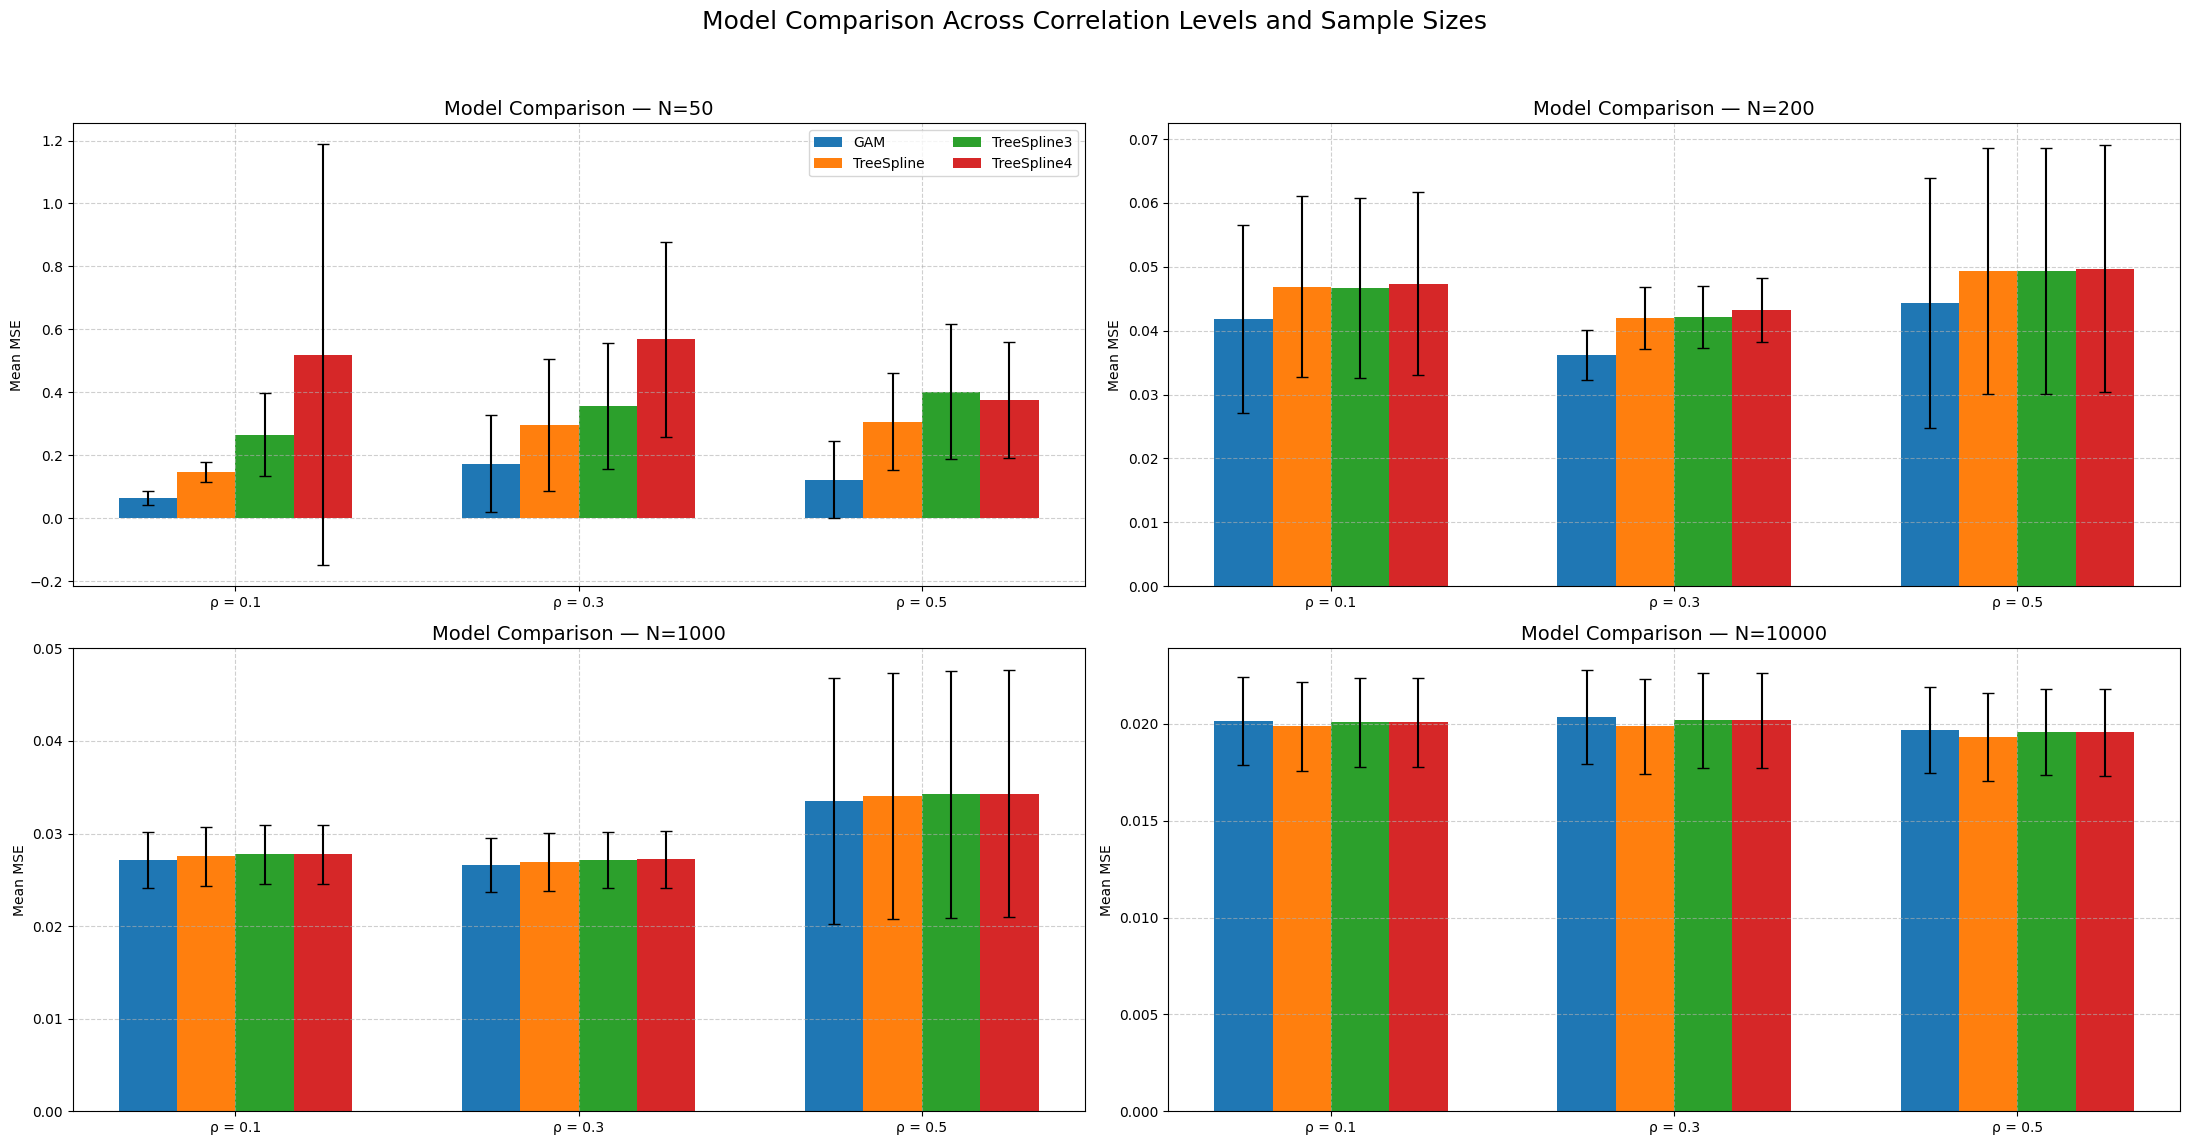

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def mean_ci(data, confidence=0.95):
    """
    data: 2D array, shape (n_groups, n_replications)
    returns:
        mean: (n_groups,)
        h:    (n_groups,)  # half-width of CI
    """
    data = np.asarray(data)
    mean = np.mean(data, axis=1)
    sd = stats.sem(data, axis=1)
    h = sd * stats.t.ppf((1 + confidence) / 2.0, data.shape[1] - 1)
    return mean, h

correlations = ['ρ = 0.1', 'ρ = 0.3', 'ρ = 0.5']
x = np.arange(len(correlations))
width = 0.17

model_labels = ["GAM", "TreeSpline", "TreeSpline3", "TreeSpline4"]
sample_sizes = ["N=50", "N=200", "N=1000", "N=10000"]

all_mse_vars = [
    # GAM
    [
        [gam_mse_corr1hist50, gam_mse_corr3hist50, gam_mse_corr5hist50],
        [gam_mse_corr1hist200, gam_mse_corr3hist200, gam_mse_corr5hist200],
        [gam_mse_corr1hist1000, gam_mse_corr3hist1000, gam_mse_corr5hist1000],
        [gam_mse_corr1hist10000, gam_mse_corr3hist10000, gam_mse_corr5hist10000]
    ],
    # TreeSpline
    [
        [tree_mse_corr1hist50, tree_mse_corr3hist50, tree_mse_corr5hist50],
        [tree_mse_corr1hist200, tree_mse_corr3hist200, tree_mse_corr5hist200],
        [tree_mse_corr1hist1000, tree_mse_corr3hist1000, tree_mse_corr5hist1000],
        [tree_mse_corr1hist10000, tree_mse_corr3hist10000, tree_mse_corr5hist10000]
    ],
    # TreeSpline3
    [
        [tree3_mse_corr1hist50, tree3_mse_corr3hist50, tree3_mse_corr5hist50],
        [tree3_mse_corr1hist200, tree3_mse_corr3hist200, tree3_mse_corr5hist200],
        [tree3_mse_corr1hist1000, tree3_mse_corr3hist1000, tree3_mse_corr5hist1000],
        [tree3_mse_corr1hist10000, tree3_mse_corr3hist10000, tree3_mse_corr5hist10000]
    ],
    # TreeSpline4
    [
        [tree4_mse_corr1hist50, tree4_mse_corr3hist50, tree4_mse_corr5hist50],
        [tree4_mse_corr1hist200, tree4_mse_corr3hist200, tree4_mse_corr5hist200],
        [tree4_mse_corr1hist1000, tree4_mse_corr3hist1000, tree4_mse_corr5hist1000],
        [tree4_mse_corr1hist10000, tree4_mse_corr3hist10000, tree4_mse_corr5hist10000]
    ]
]

offsets = np.linspace(-1.5 * width, 1.5 * width, len(model_labels))

fig, axs = plt.subplots(2, 2, figsize=(22, 12))
axs = axs.flatten()

for n_idx in range(4):  # iterate over sample sizes
    ax = axs[n_idx]

    for m_idx, model_name in enumerate(model_labels):
        # list of three arrays: [ρ=0.1, ρ=0.3, ρ=0.5] for this model & N
        mse_lists = all_mse_vars[m_idx][n_idx]

        # Ensure each is 1D and stack as (n_rhos, n_replications)
        data = np.array([np.ravel(a) for a in mse_lists])
        # Now data.shape = (3, n_replications)

        means, cis = mean_ci(data)  # both shape (3,)

        ax.bar(x + offsets[m_idx], means, width, yerr=cis,
               capsize=4, label=model_name if n_idx == 0 else None)

    ax.set_title(f"Model Comparison — {sample_sizes[n_idx]}", fontsize=14)
    ax.set_ylabel("Mean MSE")
    ax.set_xticks(x)
    ax.set_xticklabels(correlations)
    ax.grid(True, linestyle='--', alpha=0.6)

    if n_idx == 0:
        ax.legend(ncol=2, fontsize=10)

fig.suptitle("Model Comparison Across Correlation Levels and Sample Sizes", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

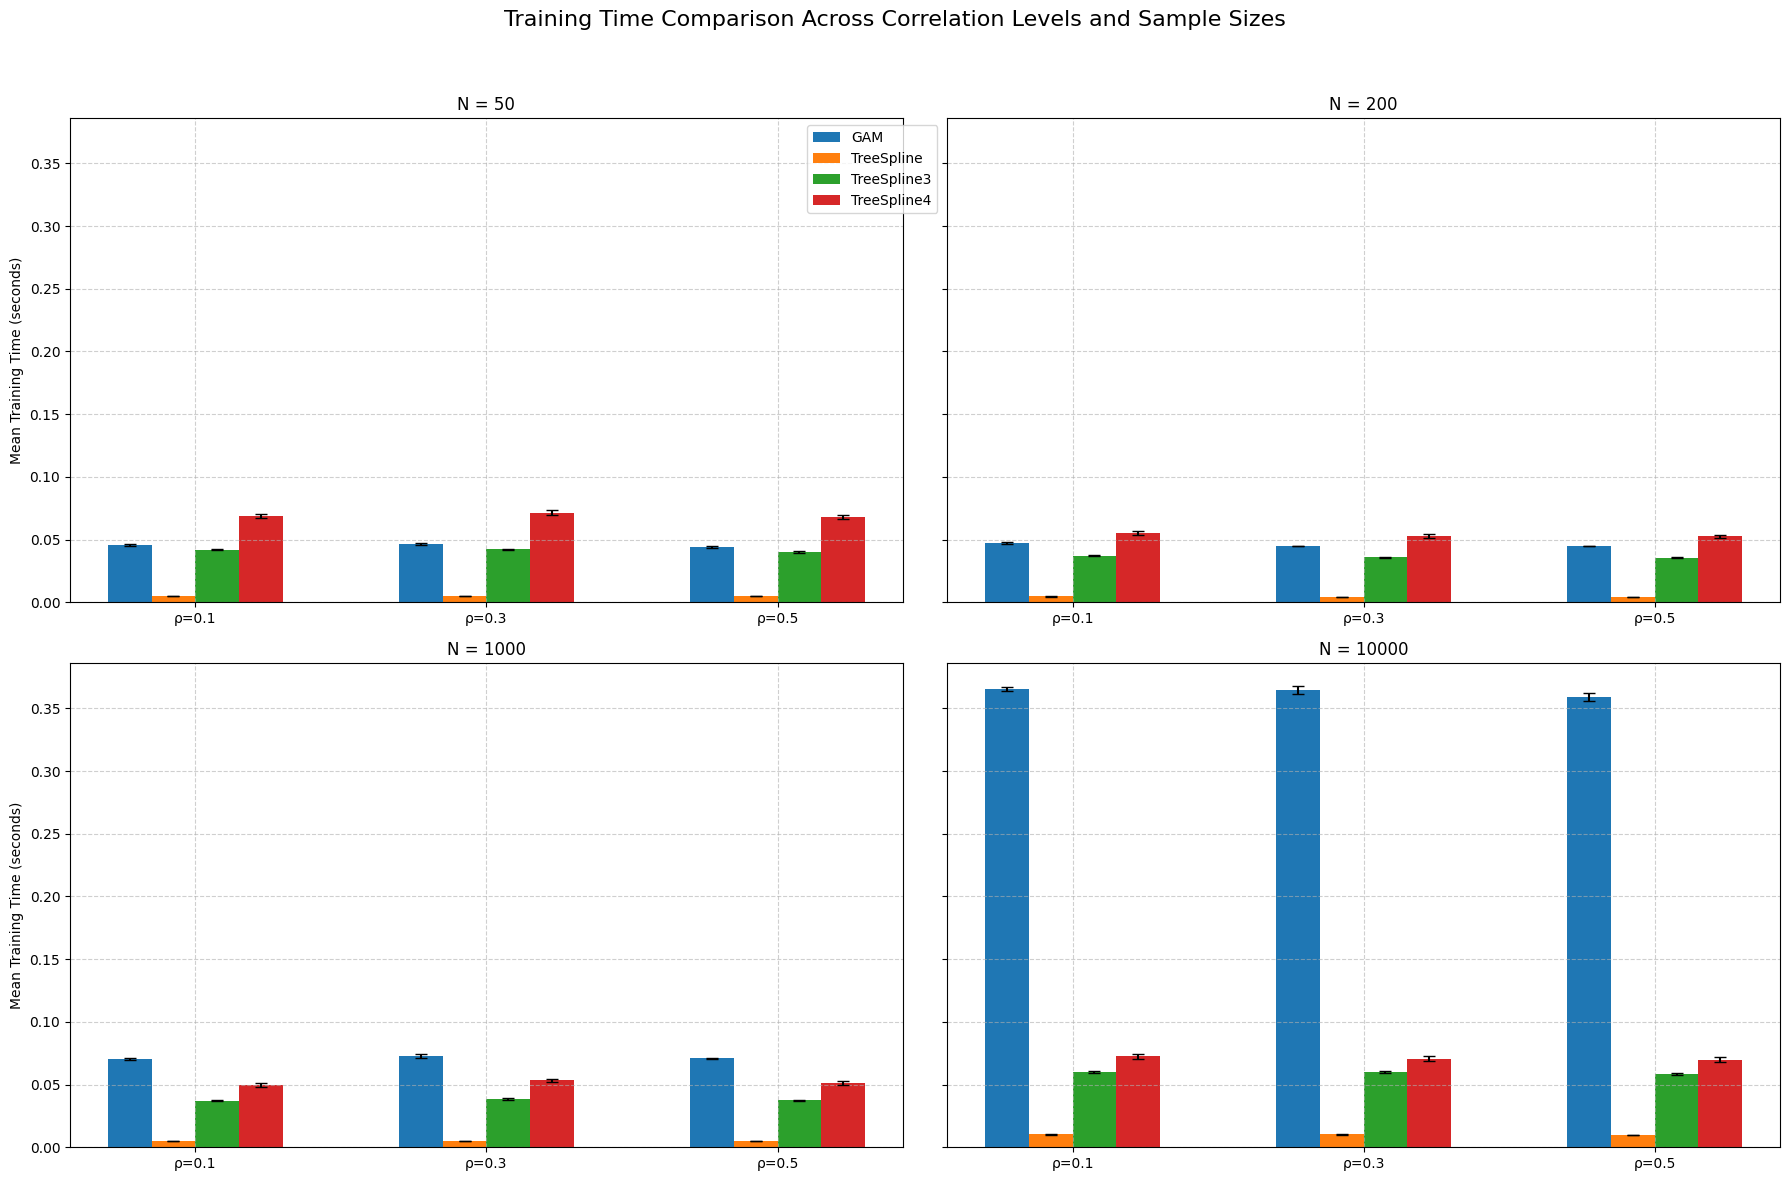

In [42]:
model_labels = [
    'GAM',
    'TreeSpline',
    'TreeSpline3',
    'TreeSpline4',
]

corr_labels = ['ρ=0.1', 'ρ=0.3', 'ρ=0.5']
sample_sizes = [50, 200, 1000, 10000]
x = np.arange(len(corr_labels))
width = 0.15

all_time_vars = [
    # GAM
    [
        [gam_time_corr1hist50,   gam_time_corr3hist50,   gam_time_corr5hist50],
        [gam_time_corr1hist200,  gam_time_corr3hist200,  gam_time_corr5hist200],
        [gam_time_corr1hist1000, gam_time_corr3hist1000, gam_time_corr5hist1000],
        [gam_time_corr1hist10000,gam_time_corr3hist10000,gam_time_corr5hist10000],
    ],
    # TreeSpline
    [
        [tree_time_corr1hist50,   tree_time_corr3hist50,   tree_time_corr5hist50],
        [tree_time_corr1hist200,  tree_time_corr3hist200,  tree_time_corr5hist200],
        [tree_time_corr1hist1000, tree_time_corr3hist1000, tree_time_corr5hist1000],
        [tree_time_corr1hist10000,tree_time_corr3hist10000,tree_time_corr5hist10000],
    ],
    # TreeSpline3
    [
        [tree3_time_corr1hist50,   tree3_time_corr3hist50,   tree3_time_corr5hist50],
        [tree3_time_corr1hist200,  tree3_time_corr3hist200,  tree3_time_corr5hist200],
        [tree3_time_corr1hist1000, tree3_time_corr3hist1000, tree3_time_corr5hist1000],
        [tree3_time_corr1hist10000,tree3_time_corr3hist10000,tree3_time_corr5hist10000],
    ],
    # TreeSpline4
    [
        [tree4_time_corr1hist50,   tree4_time_corr3hist50,   tree4_time_corr5hist50],
        [tree4_time_corr1hist200,  tree4_time_corr3hist200,  tree4_time_corr5hist200],
        [tree4_time_corr1hist1000, tree4_time_corr3hist1000, tree4_time_corr5hist1000],
        [tree4_time_corr1hist10000,tree4_time_corr3hist10000,tree4_time_corr5hist10000],
    ],
]

fig, axs = plt.subplots(2, 2, figsize=(18, 12), sharey=True)
axs = axs.flatten()

# Automatic offsets for any number of models
offsets = np.linspace(
    -((len(model_labels) - 1) / 2) * width,
    ((len(model_labels) - 1) / 2) * width,
    len(model_labels)
)

for idx, N in enumerate(sample_sizes):
    ax = axs[idx]

    for m_idx, model_name in enumerate(model_labels):
        # list of 3 arrays: times for [ρ=0.1, ρ=0.3, ρ=0.5]
        time_lists = all_time_vars[m_idx][idx]

        # Stack into shape (n_corr, n_replications)
        data = np.array([np.ravel(a) for a in time_lists])
        means, cis = mean_ci(data)

        ax.bar(x + offsets[m_idx], means, width, yerr=cis, capsize=4,
               label=model_name if idx == 0 else "")

    ax.set_xticks(x)
    ax.set_xticklabels(corr_labels)
    ax.set_title(f'N = {N}')
    ax.grid(True, linestyle='--', alpha=0.6)
    if idx % 2 == 0:
        ax.set_ylabel('Mean Training Time (seconds)')

# Legend only on first subplot
axs[0].legend(ncol=1, fontsize=10, bbox_to_anchor=(1.05, 1.0))

fig.suptitle('Training Time Comparison Across Correlation Levels and Sample Sizes', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

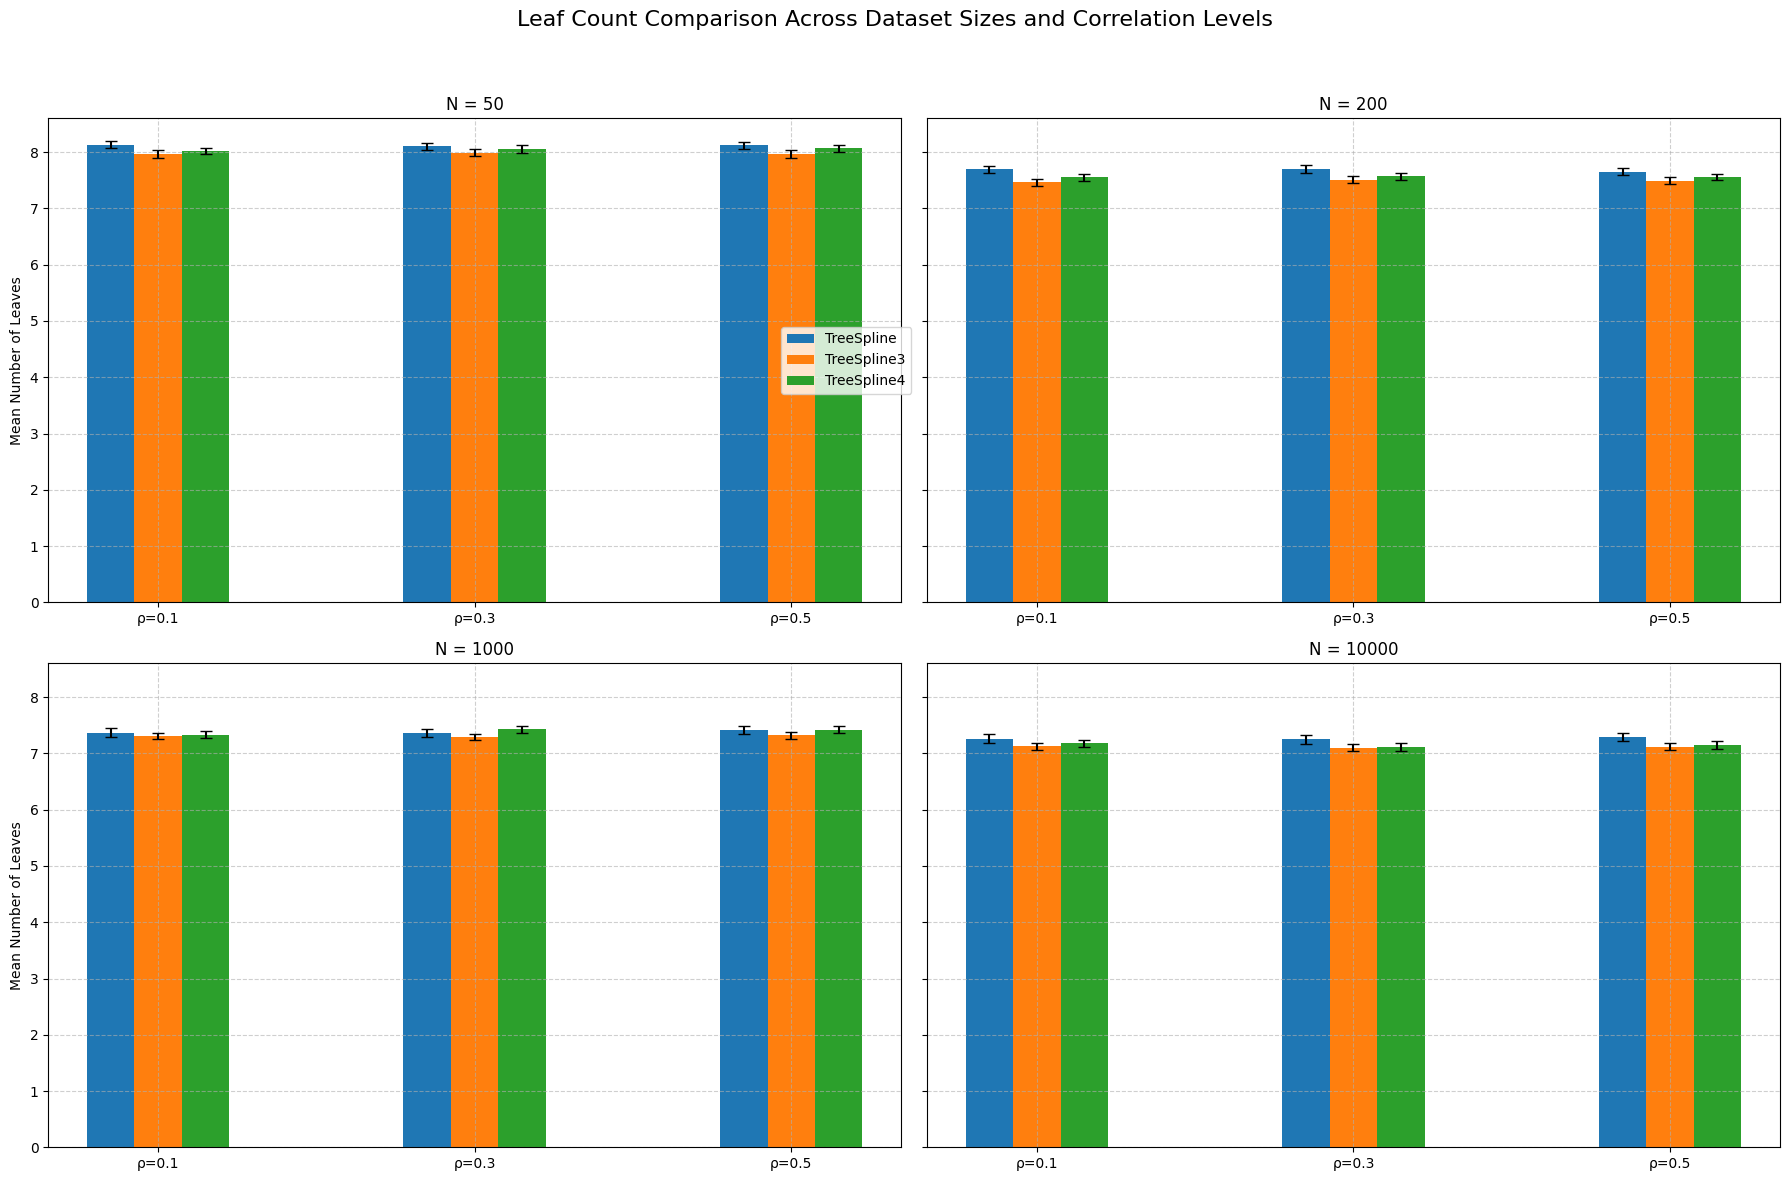

In [44]:
sample_sizes = [50, 200, 1000, 10000]
corr_labels = ['ρ=0.1', 'ρ=0.3', 'ρ=0.5']
x = np.arange(len(corr_labels))

labels = [
    'TreeSpline',
    'TreeSpline3',
    'TreeSpline4',
]

n_models = len(labels)
width = 0.15  # bar width

fig, axs = plt.subplots(2, 2, figsize=(18, 12), sharey=True)
axs = axs.flatten()

# symmetric offsets around each correlation position
offsets = np.linspace(-((n_models - 1) / 2) * width,
                      ((n_models - 1) / 2) * width,
                      n_models)

for idx, N in enumerate(sample_sizes):
    # For each N, collect per-model leaf arrays for rho = 0.1, 0.3, 0.5
    leaf_arrays_by_model = [
        [globals()[f"leaf_corr1hist{N}"],
         globals()[f"leaf_corr3hist{N}"],
         globals()[f"leaf_corr5hist{N}"]],
        [globals()[f"leaf3_corr1hist{N}"],
         globals()[f"leaf3_corr3hist{N}"],
         globals()[f"leaf3_corr5hist{N}"]],
        [globals()[f"leaf4_corr1hist{N}"],
         globals()[f"leaf4_corr3hist{N}"],
         globals()[f"leaf4_corr5hist{N}"]],
    ]

    ax = axs[idx]

    for m_idx, model_name in enumerate(labels):
        # list of 3 arrays for the 3 correlations
        leaf_lists = leaf_arrays_by_model[m_idx]

        # Stack into shape (n_corr, n_replications)
        data = np.array([np.ravel(a) for a in leaf_lists])
        means, cis = mean_ci(data)  # both shape (3,)

        ax.bar(x + offsets[m_idx], means, width,
               yerr=cis, capsize=4,
               label=model_name if idx == 0 else "")

    ax.set_xticks(x)
    ax.set_xticklabels(corr_labels)
    ax.set_title(f'N = {N}')
    ax.grid(True, linestyle='--', alpha=0.6)

    if idx % 2 == 0:
        ax.set_ylabel('Mean Number of Leaves')

# Legend only on top-left subplot
axs[0].legend(labels, loc='center right', fontsize=10,
              ncol=1, bbox_to_anchor=(1.02, 0.5))

fig.suptitle('Leaf Count Comparison Across Dataset Sizes and Correlation Levels', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Testing with different no. of features (N = 1000, correlated features)

## d = 5

In [34]:
n_samples = 1000
repeats = 100

gam_mse_corr1hist10005 = np.zeros((4, repeats))
gam_time_corr1hist10005 = np.zeros((4, repeats))

leaf_corr1hist10005 = np.zeros((4, repeats))
tree_mse_corr1hist10005 = np.zeros((4, repeats))
tree_time_corr1hist10005 = np.zeros((4, repeats))

tree3_mse_corr1hist10005 = np.zeros((4, repeats))
tree3_time_corr1hist10005 = np.zeros((4, repeats))
leaf3_corr1hist10005 = np.zeros((4, repeats))

tree4_mse_corr1hist10005 = np.zeros((4, repeats))
tree4_time_corr1hist10005 = np.zeros((4, repeats))
leaf4_corr1hist10005 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.1, n_features=5)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr1hist10005[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr1hist10005[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr1hist10005[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr1hist10005[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr1hist10005[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr1hist10005[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr1hist10005[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr1hist10005[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr1hist10005[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr1hist10005[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr1hist10005[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [35]:
n_samples = 1000
repeats = 100

gam_mse_corr3hist10005 = np.zeros((4, repeats))
gam_time_corr3hist10005 = np.zeros((4, repeats))

leaf_corr3hist10005 = np.zeros((4, repeats))
tree_mse_corr3hist10005 = np.zeros((4, repeats))
tree_time_corr3hist10005 = np.zeros((4, repeats))

tree3_mse_corr3hist10005 = np.zeros((4, repeats))
tree3_time_corr3hist10005 = np.zeros((4, repeats))
leaf3_corr3hist10005 = np.zeros((4, repeats))

tree4_mse_corr3hist10005 = np.zeros((4, repeats))
tree4_time_corr3hist10005 = np.zeros((4, repeats))
leaf4_corr3hist10005 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.3, n_features=5)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr3hist10005[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr3hist10005[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr3hist10005[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr3hist10005[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr3hist10005[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr3hist10005[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr3hist10005[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr3hist10005[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr3hist10005[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr3hist10005[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr3hist10005[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [36]:
n_samples = 1000
repeats = 100

gam_mse_corr5hist10005 = np.zeros((4, repeats))
gam_time_corr5hist10005 = np.zeros((4, repeats))

leaf_corr5hist10005 = np.zeros((4, repeats))
tree_mse_corr5hist10005 = np.zeros((4, repeats))
tree_time_corr5hist10005 = np.zeros((4, repeats))

tree3_mse_corr5hist10005 = np.zeros((4, repeats))
tree3_time_corr5hist10005 = np.zeros((4, repeats))
leaf3_corr5hist10005 = np.zeros((4, repeats))

tree4_mse_corr5hist10005 = np.zeros((4, repeats))
tree4_time_corr5hist10005 = np.zeros((4, repeats))
leaf4_corr5hist10005 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.5, n_features=5)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr5hist10005[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr5hist10005[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr5hist10005[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr5hist10005[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr5hist10005[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr5hist10005[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr5hist10005[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr5hist10005[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr5hist10005[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr5hist10005[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr5hist10005[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



## d = 10

In [37]:
n_samples = 1000
repeats = 100

gam_mse_corr1hist100010 = np.zeros((4, repeats))
gam_time_corr1hist100010 = np.zeros((4, repeats))

leaf_corr1hist100010 = np.zeros((4, repeats))
tree_mse_corr1hist100010 = np.zeros((4, repeats))
tree_time_corr1hist100010 = np.zeros((4, repeats))

tree3_mse_corr1hist100010 = np.zeros((4, repeats))
tree3_time_corr1hist100010 = np.zeros((4, repeats))
leaf3_corr1hist100010 = np.zeros((4, repeats))

tree4_mse_corr1hist100010 = np.zeros((4, repeats))
tree4_time_corr1hist100010 = np.zeros((4, repeats))
leaf4_corr1hist100010 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.1, n_features=10)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr1hist100010[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr1hist100010[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr1hist100010[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr1hist100010[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr1hist100010[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr1hist100010[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr1hist100010[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr1hist100010[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr1hist100010[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr1hist100010[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr1hist100010[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [38]:
n_samples = 1000
repeats = 100

gam_mse_corr3hist100010 = np.zeros((4, repeats))
gam_time_corr3hist100010 = np.zeros((4, repeats))

leaf_corr3hist100010 = np.zeros((4, repeats))
tree_mse_corr3hist100010 = np.zeros((4, repeats))
tree_time_corr3hist100010 = np.zeros((4, repeats))

tree3_mse_corr3hist100010 = np.zeros((4, repeats))
tree3_time_corr3hist100010 = np.zeros((4, repeats))
leaf3_corr3hist100010 = np.zeros((4, repeats))

tree4_mse_corr3hist100010 = np.zeros((4, repeats))
tree4_time_corr3hist100010 = np.zeros((4, repeats))
leaf4_corr3hist100010 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.3, n_features=10)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr3hist100010[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr3hist100010[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr3hist100010[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr3hist100010[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr3hist100010[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr3hist100010[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr3hist100010[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr3hist100010[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr3hist100010[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr3hist100010[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr3hist100010[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [39]:
n_samples = 1000
repeats = 100

gam_mse_corr5hist100010 = np.zeros((4, repeats))
gam_time_corr5hist100010 = np.zeros((4, repeats))

leaf_corr5hist100010 = np.zeros((4, repeats))
tree_mse_corr5hist100010 = np.zeros((4, repeats))
tree_time_corr5hist100010 = np.zeros((4, repeats))

tree3_mse_corr5hist100010 = np.zeros((4, repeats))
tree3_time_corr5hist100010 = np.zeros((4, repeats))
leaf3_corr5hist100010 = np.zeros((4, repeats))

tree4_mse_corr5hist100010 = np.zeros((4, repeats))
tree4_time_corr5hist100010 = np.zeros((4, repeats))
leaf4_corr5hist100010 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, rho=0.5, n_features=10)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr5hist100010[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr5hist100010[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr5hist100010[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr5hist100010[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr5hist100010[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr5hist100010[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr5hist100010[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr5hist100010[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr5hist100010[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr5hist100010[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr5hist100010[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [40]:
np.save('nparrs/gam_mse_corr1hist10005.npy', gam_mse_corr1hist10005)
np.save('nparrs/gam_time_corr1hist10005.npy', gam_time_corr1hist10005)
np.save('nparrs/tree_time_corr1hist10005.npy', tree_time_corr1hist10005)
np.save('nparrs/tree_mse_corr1hist10005.npy', tree_mse_corr1hist10005)
np.save('nparrs/leaf_corr1hist10005.npy', leaf_corr1hist10005)
np.save('nparrs/tree3_time_corr1hist10005.npy', tree3_time_corr1hist10005)
np.save('nparrs/tree3_mse_corr1hist10005.npy', tree3_mse_corr1hist10005)
np.save('nparrs/leaf3_corr1hist10005.npy', leaf3_corr1hist10005)
np.save('nparrs/tree4_time_corr1hist10005.npy', tree4_time_corr1hist10005)
np.save('nparrs/tree4_mse_corr1hist10005.npy', tree4_mse_corr1hist10005)
np.save('nparrs/leaf4_corr1hist10005.npy', leaf4_corr1hist10005)

np.save('nparrs/gam_mse_corr3hist10005.npy', gam_mse_corr3hist10005)
np.save('nparrs/gam_time_corr3hist10005.npy', gam_time_corr3hist10005)
np.save('nparrs/tree_time_corr3hist10005.npy', tree_time_corr3hist10005)
np.save('nparrs/tree_mse_corr3hist10005.npy', tree_mse_corr3hist10005)
np.save('nparrs/leaf_corr3hist10005.npy', leaf_corr3hist10005)
np.save('nparrs/tree3_time_corr3hist10005.npy', tree3_time_corr3hist10005)
np.save('nparrs/tree3_mse_corr3hist10005.npy', tree3_mse_corr3hist10005)
np.save('nparrs/leaf3_corr3hist10005.npy', leaf3_corr3hist10005)
np.save('nparrs/tree4_time_corr3hist10005.npy', tree4_time_corr3hist10005)
np.save('nparrs/tree4_mse_corr3hist10005.npy', tree4_mse_corr3hist10005)
np.save('nparrs/leaf4_corr3hist10005.npy', leaf4_corr3hist10005)

np.save('nparrs/gam_mse_corr5hist10005.npy', gam_mse_corr5hist10005)
np.save('nparrs/gam_time_corr5hist10005.npy', gam_time_corr5hist10005)
np.save('nparrs/tree_time_corr5hist10005.npy', tree_time_corr5hist10005)
np.save('nparrs/tree_mse_corr5hist10005.npy', tree_mse_corr5hist10005)
np.save('nparrs/leaf_corr5hist10005.npy', leaf_corr5hist10005)
np.save('nparrs/tree3_time_corr5hist10005.npy', tree3_time_corr5hist10005)
np.save('nparrs/tree3_mse_corr5hist10005.npy', tree3_mse_corr5hist10005)
np.save('nparrs/leaf3_corr5hist10005.npy', leaf3_corr5hist10005)
np.save('nparrs/tree4_time_corr5hist10005.npy', tree4_time_corr5hist10005)
np.save('nparrs/tree4_mse_corr5hist10005.npy', tree4_mse_corr5hist10005)
np.save('nparrs/leaf4_corr5hist10005.npy', leaf4_corr5hist10005)

# ------------------------------------------------------------------------------

np.save('nparrs/gam_mse_corr1hist100010.npy', gam_mse_corr1hist100010)
np.save('nparrs/gam_time_corr1hist100010.npy', gam_time_corr1hist100010)
np.save('nparrs/tree_time_corr1hist100010.npy', tree_time_corr1hist100010)
np.save('nparrs/tree_mse_corr1hist100010.npy', tree_mse_corr1hist100010)
np.save('nparrs/leaf_corr1hist100010.npy', leaf_corr1hist100010)
np.save('nparrs/tree3_time_corr1hist100010.npy', tree3_time_corr1hist100010)
np.save('nparrs/tree3_mse_corr1hist100010.npy', tree3_mse_corr1hist100010)
np.save('nparrs/leaf3_corr1hist100010.npy', leaf3_corr1hist100010)
np.save('nparrs/tree4_time_corr1hist100010.npy', tree4_time_corr1hist100010)
np.save('nparrs/tree4_mse_corr1hist100010.npy', tree4_mse_corr1hist100010)
np.save('nparrs/leaf4_corr1hist100010.npy', leaf4_corr1hist100010)

np.save('nparrs/gam_mse_corr3hist100010.npy', gam_mse_corr3hist100010)
np.save('nparrs/gam_time_corr3hist100010.npy', gam_time_corr3hist100010)
np.save('nparrs/tree_time_corr3hist100010.npy', tree_time_corr3hist100010)
np.save('nparrs/tree_mse_corr3hist100010.npy', tree_mse_corr3hist100010)
np.save('nparrs/leaf_corr3hist100010.npy', leaf_corr3hist100010)
np.save('nparrs/tree3_time_corr3hist100010.npy', tree3_time_corr3hist100010)
np.save('nparrs/tree3_mse_corr3hist100010.npy', tree3_mse_corr3hist100010)
np.save('nparrs/leaf3_corr3hist100010.npy', leaf3_corr3hist100010)
np.save('nparrs/tree4_time_corr3hist100010.npy', tree4_time_corr3hist100010)
np.save('nparrs/tree4_mse_corr3hist100010.npy', tree4_mse_corr3hist100010)
np.save('nparrs/leaf4_corr3hist100010.npy', leaf4_corr3hist100010)

np.save('nparrs/gam_mse_corr5hist100010.npy', gam_mse_corr5hist100010)
np.save('nparrs/gam_time_corr5hist100010.npy', gam_time_corr5hist100010)
np.save('nparrs/tree_time_corr5hist100010.npy', tree_time_corr5hist100010)
np.save('nparrs/tree_mse_corr5hist100010.npy', tree_mse_corr5hist100010)
np.save('nparrs/leaf_corr5hist100010.npy', leaf_corr5hist100010)
np.save('nparrs/tree3_time_corr5hist100010.npy', tree3_time_corr5hist100010)
np.save('nparrs/tree3_mse_corr5hist100010.npy', tree3_mse_corr5hist100010)
np.save('nparrs/leaf3_corr5hist100010.npy', leaf3_corr5hist100010)
np.save('nparrs/tree4_time_corr5hist100010.npy', tree4_time_corr5hist100010)
np.save('nparrs/tree4_mse_corr5hist100010.npy', tree4_mse_corr5hist100010)
np.save('nparrs/leaf4_corr5hist100010.npy', leaf4_corr5hist100010)

In [41]:
gam_mse_corr1hist10005 = np.load('nparrs/gam_mse_corr1hist10005.npy')
gam_time_corr1hist10005 = np.load('nparrs/gam_time_corr1hist10005.npy')
tree_time_corr1hist10005 = np.load('nparrs/tree_time_corr1hist10005.npy')
tree_mse_corr1hist10005 = np.load('nparrs/tree_mse_corr1hist10005.npy')
leaf_corr1hist10005 = np.load('nparrs/leaf_corr1hist10005.npy')
tree3_time_corr1hist10005 = np.load('nparrs/tree3_time_corr1hist10005.npy')
tree3_mse_corr1hist10005 = np.load('nparrs/tree3_mse_corr1hist10005.npy')
leaf3_corr1hist10005 = np.load('nparrs/leaf3_corr1hist10005.npy')
tree4_time_corr1hist10005 = np.load('nparrs/tree4_time_corr1hist10005.npy')
tree4_mse_corr1hist10005 = np.load('nparrs/tree4_mse_corr1hist10005.npy')
leaf4_corr1hist10005 = np.load('nparrs/leaf4_corr1hist10005.npy')

gam_mse_corr3hist10005 = np.load('nparrs/gam_mse_corr3hist10005.npy')
gam_time_corr3hist10005 = np.load('nparrs/gam_time_corr3hist10005.npy')
tree_time_corr3hist10005 = np.load('nparrs/tree_time_corr3hist10005.npy')
tree_mse_corr3hist10005 = np.load('nparrs/tree_mse_corr3hist10005.npy')
leaf_corr3hist10005 = np.load('nparrs/leaf_corr3hist10005.npy')
tree3_time_corr3hist10005 = np.load('nparrs/tree3_time_corr3hist10005.npy')
tree3_mse_corr3hist10005 = np.load('nparrs/tree3_mse_corr3hist10005.npy')
leaf3_corr3hist10005 = np.load('nparrs/leaf3_corr3hist10005.npy')
tree4_time_corr3hist10005 = np.load('nparrs/tree4_time_corr3hist10005.npy')
tree4_mse_corr3hist10005 = np.load('nparrs/tree4_mse_corr3hist10005.npy')
leaf4_corr3hist10005 = np.load('nparrs/leaf4_corr3hist10005.npy')

gam_mse_corr5hist10005 = np.load('nparrs/gam_mse_corr5hist10005.npy')
gam_time_corr5hist10005 = np.load('nparrs/gam_time_corr5hist10005.npy')
tree_time_corr5hist10005 = np.load('nparrs/tree_time_corr5hist10005.npy')
tree_mse_corr5hist10005 = np.load('nparrs/tree_mse_corr5hist10005.npy')
leaf_corr5hist10005 = np.load('nparrs/leaf_corr5hist10005.npy')
tree3_time_corr5hist10005 = np.load('nparrs/tree3_time_corr5hist10005.npy')
tree3_mse_corr5hist10005 = np.load('nparrs/tree3_mse_corr5hist10005.npy')
leaf3_corr5hist10005 = np.load('nparrs/leaf3_corr5hist10005.npy')
tree4_time_corr5hist10005 = np.load('nparrs/tree4_time_corr5hist10005.npy')
tree4_mse_corr5hist10005 = np.load('nparrs/tree4_mse_corr5hist10005.npy')
leaf4_corr5hist10005 = np.load('nparrs/leaf4_corr5hist10005.npy')

# ------------------------------------------------------------------------------

gam_mse_corr1hist100010 = np.load('nparrs/gam_mse_corr1hist100010.npy')
gam_time_corr1hist100010 = np.load('nparrs/gam_time_corr1hist100010.npy')
tree_time_corr1hist100010 = np.load('nparrs/tree_time_corr1hist100010.npy')
tree_mse_corr1hist100010 = np.load('nparrs/tree_mse_corr1hist100010.npy')
leaf_corr1hist100010 = np.load('nparrs/leaf_corr1hist100010.npy')
tree3_time_corr1hist100010 = np.load('nparrs/tree3_time_corr1hist100010.npy')
tree3_mse_corr1hist100010 = np.load('nparrs/tree3_mse_corr1hist100010.npy')
leaf3_corr1hist100010 = np.load('nparrs/leaf3_corr1hist100010.npy')
tree4_time_corr1hist100010 = np.load('nparrs/tree4_time_corr1hist100010.npy')
tree4_mse_corr1hist100010 = np.load('nparrs/tree4_mse_corr1hist100010.npy')
leaf4_corr1hist100010 = np.load('nparrs/leaf4_corr1hist100010.npy')

gam_mse_corr3hist100010 = np.load('nparrs/gam_mse_corr3hist100010.npy')
gam_time_corr3hist100010 = np.load('nparrs/gam_time_corr3hist100010.npy')
tree_time_corr3hist100010 = np.load('nparrs/tree_time_corr3hist100010.npy')
tree_mse_corr3hist100010 = np.load('nparrs/tree_mse_corr3hist100010.npy')
leaf_corr3hist100010 = np.load('nparrs/leaf_corr3hist100010.npy')
tree3_time_corr3hist100010 = np.load('nparrs/tree3_time_corr3hist100010.npy')
tree3_mse_corr3hist100010 = np.load('nparrs/tree3_mse_corr3hist100010.npy')
leaf3_corr3hist100010 = np.load('nparrs/leaf3_corr3hist100010.npy')
tree4_time_corr3hist100010 = np.load('nparrs/tree4_time_corr3hist100010.npy')
tree4_mse_corr3hist100010 = np.load('nparrs/tree4_mse_corr3hist100010.npy')
leaf4_corr3hist100010 = np.load('nparrs/leaf4_corr3hist100010.npy')

gam_mse_corr5hist100010 = np.load('nparrs/gam_mse_corr5hist100010.npy')
gam_time_corr5hist100010 = np.load('nparrs/gam_time_corr5hist100010.npy')
tree_time_corr5hist100010 = np.load('nparrs/tree_time_corr5hist100010.npy')
tree_mse_corr5hist100010 = np.load('nparrs/tree_mse_corr5hist100010.npy')
leaf_corr5hist100010 = np.load('nparrs/leaf_corr5hist100010.npy')
tree3_time_corr5hist100010 = np.load('nparrs/tree3_time_corr5hist100010.npy')
tree3_mse_corr5hist100010 = np.load('nparrs/tree3_mse_corr5hist100010.npy')
leaf3_corr5hist100010 = np.load('nparrs/leaf3_corr5hist100010.npy')
tree4_time_corr5hist100010 = np.load('nparrs/tree4_time_corr5hist100010.npy')
tree4_mse_corr5hist100010 = np.load('nparrs/tree4_mse_corr5hist100010.npy')
leaf4_corr5hist100010 = np.load('nparrs/leaf4_corr5hist100010.npy')

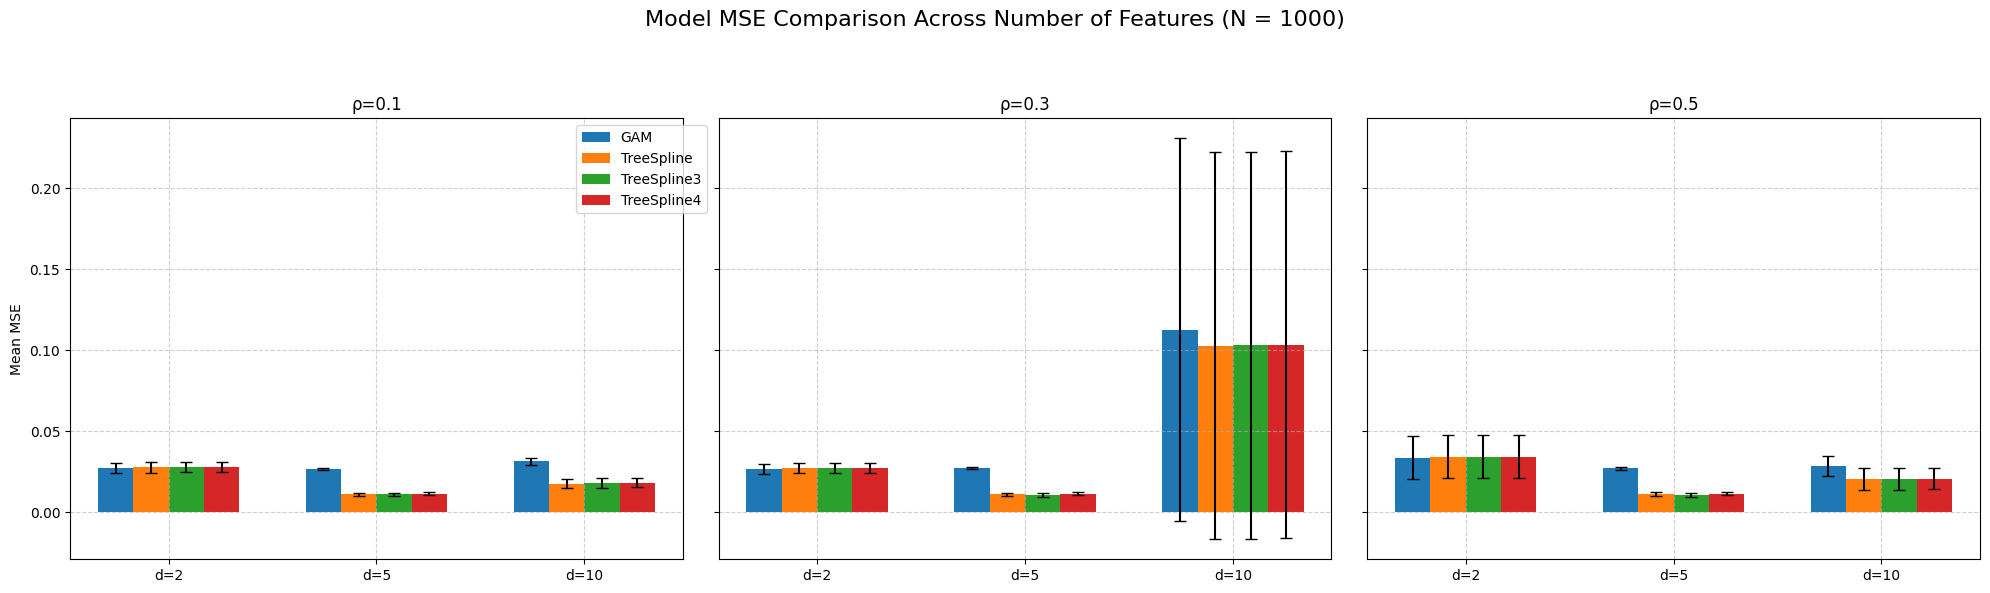

In [45]:
d_values = [2, 5, 10]
d_labels = [f'd={d}' for d in d_values]
x = np.arange(len(d_labels))

rho_labels = ['ρ=0.1', 'ρ=0.3', 'ρ=0.5']

model_labels = [
    'GAM',
    'TreeSpline',
    'TreeSpline3',
    'TreeSpline4',
]

n_models = len(model_labels)
width = 0.17

all_mse_vars = [
    # GAM
    [
        [gam_mse_corr1hist1000,  gam_mse_corr1hist10005,  gam_mse_corr1hist100010],
        [gam_mse_corr3hist1000,  gam_mse_corr3hist10005,  gam_mse_corr3hist100010],
        [gam_mse_corr5hist1000,  gam_mse_corr5hist10005,  gam_mse_corr5hist100010],
    ],
    # TreeSpline
    [
        [tree_mse_corr1hist1000, tree_mse_corr1hist10005, tree_mse_corr1hist100010],
        [tree_mse_corr3hist1000, tree_mse_corr3hist10005, tree_mse_corr3hist100010],
        [tree_mse_corr5hist1000, tree_mse_corr5hist10005, tree_mse_corr5hist100010],
    ],
    # TreeSpline3
    [
        [tree3_mse_corr1hist1000, tree3_mse_corr1hist10005, tree3_mse_corr1hist100010],
        [tree3_mse_corr3hist1000, tree3_mse_corr3hist10005, tree3_mse_corr3hist100010],
        [tree3_mse_corr5hist1000, tree3_mse_corr5hist10005, tree3_mse_corr5hist100010],
    ],
    # TreeSpline4
    [
        [tree4_mse_corr1hist1000, tree4_mse_corr1hist10005, tree4_mse_corr1hist100010],
        [tree4_mse_corr3hist1000, tree4_mse_corr3hist10005, tree4_mse_corr3hist100010],
        [tree4_mse_corr5hist1000, tree4_mse_corr5hist10005, tree4_mse_corr5hist100010],
    ],
]

fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
offsets = np.linspace(
    -((n_models - 1) / 2) * width,
    ((n_models - 1) / 2) * width,
    n_models
)

for rho_idx, rho_label in enumerate(rho_labels):
    ax = axs[rho_idx]
    for m_idx, model_name in enumerate(model_labels):
        # list of 3 arrays: [d=2, d=5, d=10] for this (model, rho)
        mse_lists = all_mse_vars[m_idx][rho_idx]

        # stack into shape (n_d, n_replications)
        data = np.array([np.ravel(a) for a in mse_lists])
        means, cis = mean_ci(data)

        ax.bar(x + offsets[m_idx], means, width,
               yerr=cis, capsize=4,
               label=model_name if rho_idx == 0 else "")

    ax.set_xticks(x)
    ax.set_xticklabels(d_labels)
    ax.set_title(rho_label)
    ax.grid(True, linestyle='--', alpha=0.6)
    if rho_idx == 0:
        ax.set_ylabel('Mean MSE')

# Legend only once
axs[0].legend(ncol=1, fontsize=10, bbox_to_anchor=(1.05, 1.0))

fig.suptitle('Model MSE Comparison Across Number of Features (N = 1000)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

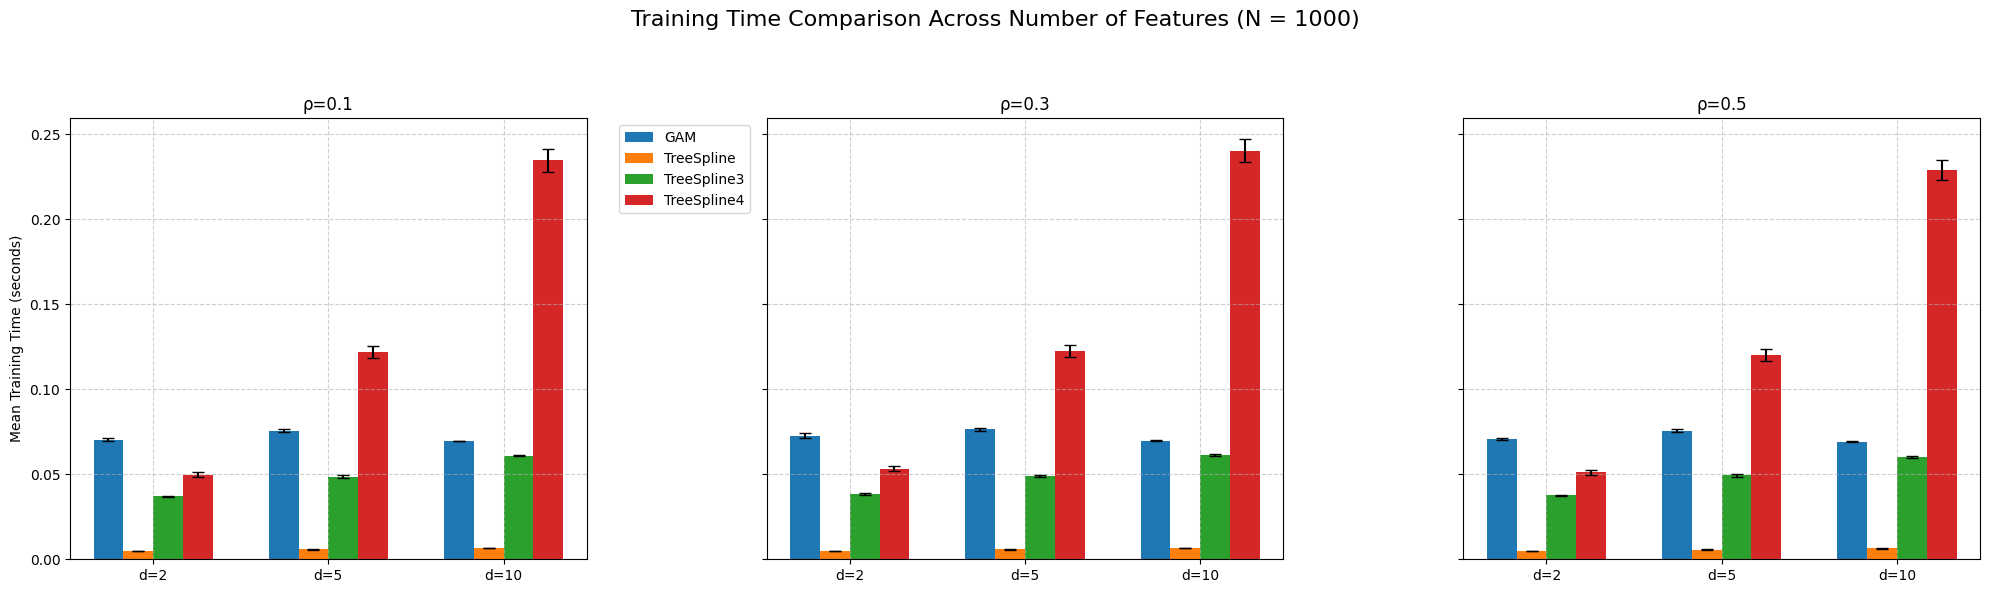

In [46]:
d_values = [2, 5, 10]
d_labels = [f'd={d}' for d in d_values]
x = np.arange(len(d_labels))

rho_labels = ['ρ=0.1', 'ρ=0.3', 'ρ=0.5']

model_labels = [
    'GAM',
    'TreeSpline',
    'TreeSpline3',
    'TreeSpline4',
]

n_models = len(model_labels)
width = 0.17

all_time_vars = [
    # GAM
    [
        [gam_time_corr1hist1000,  gam_time_corr1hist10005,  gam_time_corr1hist100010],
        [gam_time_corr3hist1000,  gam_time_corr3hist10005,  gam_time_corr3hist100010],
        [gam_time_corr5hist1000,  gam_time_corr5hist10005,  gam_time_corr5hist100010],
    ],
    # TreeSpline
    [
        [tree_time_corr1hist1000, tree_time_corr1hist10005, tree_time_corr1hist100010],
        [tree_time_corr3hist1000, tree_time_corr3hist10005, tree_time_corr3hist100010],
        [tree_time_corr5hist1000, tree_time_corr5hist10005, tree_time_corr5hist100010],
    ],
    # TreeSpline3
    [
        [tree3_time_corr1hist1000, tree3_time_corr1hist10005, tree3_time_corr1hist100010],
        [tree3_time_corr3hist1000, tree3_time_corr3hist10005, tree3_time_corr3hist100010],
        [tree3_time_corr5hist1000, tree3_time_corr5hist10005, tree3_time_corr5hist100010],
    ],
    # TreeSpline4
    [
        [tree4_time_corr1hist1000, tree4_time_corr1hist10005, tree4_time_corr1hist100010],
        [tree4_time_corr3hist1000, tree4_time_corr3hist10005, tree4_time_corr3hist100010],
        [tree4_time_corr5hist1000, tree4_time_corr5hist10005, tree4_time_corr5hist100010],
    ],
]

fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
offsets = np.linspace(
    -((n_models - 1) / 2) * width,
    ((n_models - 1) / 2) * width,
    n_models
)

for rho_idx, rho_label in enumerate(rho_labels):
    ax = axs[rho_idx]
    for m_idx, model_name in enumerate(model_labels):
        # list of 3 arrays: [d=2, d=5, d=10] for this (model, rho)
        time_lists = all_time_vars[m_idx][rho_idx]

        # stack into shape (n_d, n_replications)
        data = np.array([np.ravel(a) for a in time_lists])
        means, cis = mean_ci(data)

        ax.bar(x + offsets[m_idx], means, width,
               yerr=cis, capsize=4,
               label=model_name if rho_idx == 0 else "")

    ax.set_xticks(x)
    ax.set_xticklabels(d_labels)
    ax.set_title(rho_label)
    ax.grid(True, linestyle='--', alpha=0.6)
    if rho_idx == 0:
        ax.set_ylabel('Mean Training Time (seconds)')

# Legend only once
axs[0].legend(ncol=1, fontsize=10, bbox_to_anchor=(1.05, 1.0))

fig.suptitle('Training Time Comparison Across Number of Features (N = 1000)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

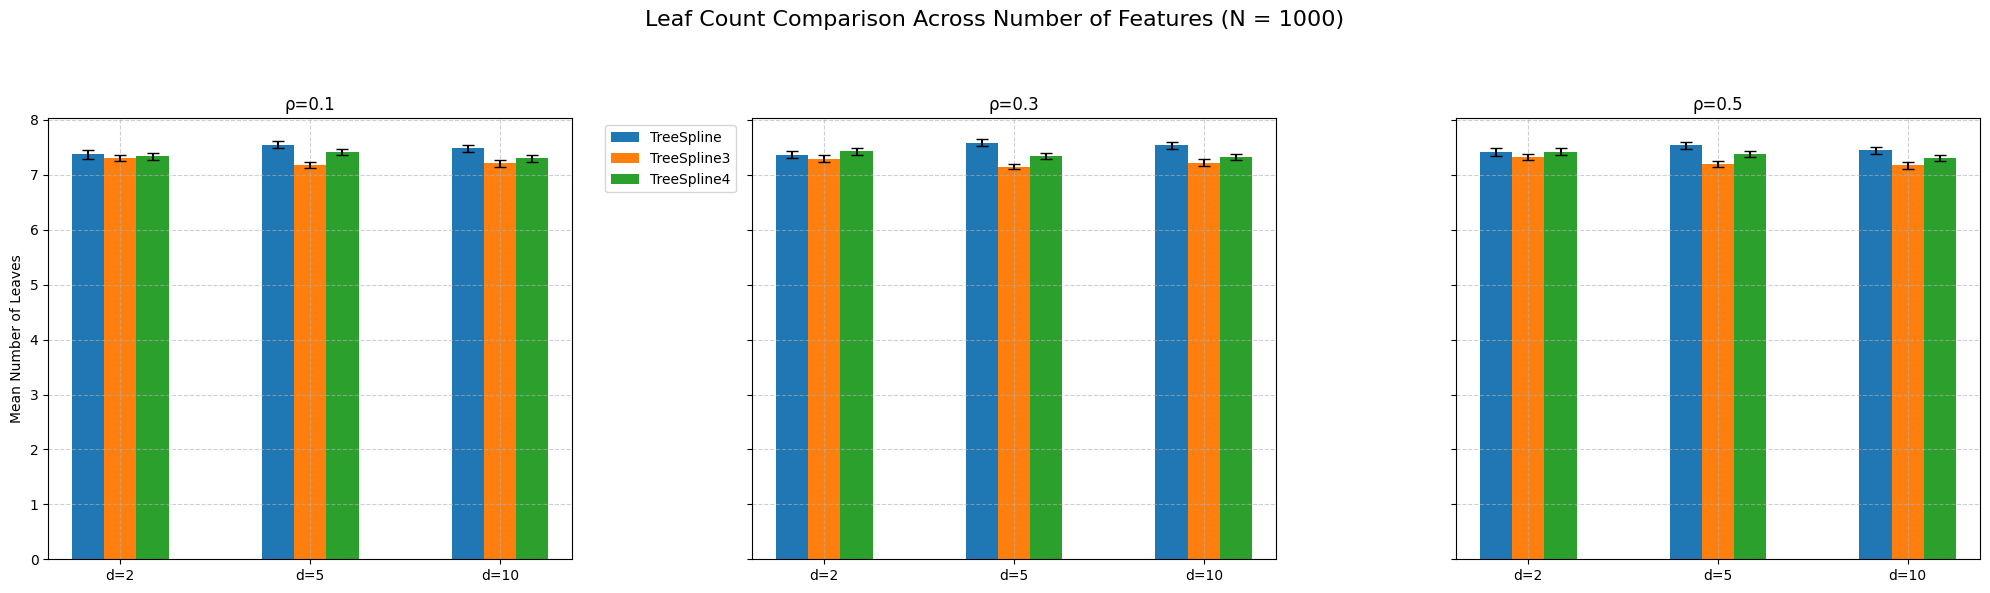

In [47]:
d_values = [2, 5, 10]
d_labels = [f'd={d}' for d in d_values]
x = np.arange(len(d_labels))

rho_labels = ['ρ=0.1', 'ρ=0.3', 'ρ=0.5']

labels = [
    'TreeSpline',
    'TreeSpline3',
    'TreeSpline4',
]

n_models = len(labels)
width = 0.17

all_leaf_vars = [
    # TreeSpline
    [
        [leaf_corr1hist1000,  leaf_corr1hist10005,  leaf_corr1hist100010],
        [leaf_corr3hist1000,  leaf_corr3hist10005,  leaf_corr3hist100010],
        [leaf_corr5hist1000,  leaf_corr5hist10005,  leaf_corr5hist100010],
    ],
    # TreeSpline3
    [
        [leaf3_corr1hist1000, leaf3_corr1hist10005, leaf3_corr1hist100010],
        [leaf3_corr3hist1000, leaf3_corr3hist10005, leaf3_corr3hist100010],
        [leaf3_corr5hist1000, leaf3_corr5hist10005, leaf3_corr5hist100010],
    ],
    # TreeSpline4
    [
        [leaf4_corr1hist1000, leaf4_corr1hist10005, leaf4_corr1hist100010],
        [leaf4_corr3hist1000, leaf4_corr3hist10005, leaf4_corr3hist100010],
        [leaf4_corr5hist1000, leaf4_corr5hist10005, leaf4_corr5hist100010],
    ],
]

fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
offsets = np.linspace(
    -((n_models - 1) / 2) * width,
    ((n_models - 1) / 2) * width,
    n_models
)

for rho_idx, rho_label in enumerate(rho_labels):
    ax = axs[rho_idx]
    for m_idx, model_name in enumerate(labels):
        # list of 3 arrays: [d=2, d=5, d=10] for this (model, rho)
        leaf_lists = all_leaf_vars[m_idx][rho_idx]

        # stack into shape (n_d, n_replications)
        data = np.array([np.ravel(a) for a in leaf_lists])
        means, cis = mean_ci(data)

        ax.bar(x + offsets[m_idx], means, width,
               yerr=cis, capsize=4,
               label=model_name if rho_idx == 0 else "")

    ax.set_xticks(x)
    ax.set_xticklabels(d_labels)
    ax.set_title(rho_label)
    ax.grid(True, linestyle='--', alpha=0.6)
    if rho_idx == 0:
        ax.set_ylabel('Mean Number of Leaves')

# Legend only once
axs[0].legend(ncol=1, fontsize=10, bbox_to_anchor=(1.05, 1.0))

fig.suptitle('Leaf Count Comparison Across Number of Features (N = 1000)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

# Testing with different polynomial degree (N = 1000, dim(X) = 5)

## Uncorrelated features

In [48]:
n_samples = 1000
repeats = 100
degree = 2

gam_mse_hist100052 = np.zeros((4, repeats))
gam_time_hist100052 = np.zeros((4, repeats))

leaf_hist100052 = np.zeros((4, repeats))
tree_mse_hist100052 = np.zeros((4, repeats))
tree_time_hist100052 = np.zeros((4, repeats))

tree3_mse_hist100052 = np.zeros((4, repeats))
tree3_time_hist100052 = np.zeros((4, repeats))
leaf3_hist100052 = np.zeros((4, repeats))

tree4_mse_hist100052 = np.zeros((4, repeats))
tree4_time_hist100052 = np.zeros((4, repeats))
leaf4_hist100052 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_data(n_samples, i, n_features=5)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_hist100052[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_hist100052[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22, poly_degree=degree)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_hist100052[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_hist100052[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_hist100052[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22, poly_degree=degree)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_hist100052[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_hist100052[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_hist100052[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22, poly_degree=degree)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_hist100052[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_hist100052[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_hist100052[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [49]:
n_samples = 1000
repeats = 100
degree = 3

gam_mse_hist100053 = np.zeros((4, repeats))
gam_time_hist100053 = np.zeros((4, repeats))

leaf_hist100053 = np.zeros((4, repeats))
tree_mse_hist100053 = np.zeros((4, repeats))
tree_time_hist100053 = np.zeros((4, repeats))

tree3_mse_hist100053 = np.zeros((4, repeats))
tree3_time_hist100053 = np.zeros((4, repeats))
leaf3_hist100053 = np.zeros((4, repeats))

tree4_mse_hist100053 = np.zeros((4, repeats))
tree4_time_hist100053 = np.zeros((4, repeats))
leaf4_hist100053 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_data(n_samples, i, n_features=5)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_hist100053[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_hist100053[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22, poly_degree=degree)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_hist100053[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_hist100053[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_hist100053[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22, poly_degree=degree)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_hist100053[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_hist100053[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_hist100053[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22, poly_degree=degree)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_hist100053[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_hist100053[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_hist100053[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################  


--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [50]:
np.save('nparrs/gam_mse_hist100052.npy', gam_mse_hist100052)
np.save('nparrs/gam_time_hist100052.npy', gam_time_hist100052)
np.save('nparrs/tree_time_hist100052.npy', tree_time_hist100052)
np.save('nparrs/tree_mse_hist100052.npy', tree_mse_hist100052)
np.save('nparrs/leaf_hist100052.npy', leaf_hist100052)
np.save('nparrs/tree3_time_hist100052.npy', tree3_time_hist100052)
np.save('nparrs/tree3_mse_hist100052.npy', tree3_mse_hist100052)
np.save('nparrs/leaf3_hist100052.npy', leaf3_hist100052)
np.save('nparrs/tree4_time_hist100052.npy', tree4_time_hist100052)
np.save('nparrs/tree4_mse_hist100052.npy', tree4_mse_hist100052)
np.save('nparrs/leaf4_hist100052.npy', leaf4_hist100052)

np.save('nparrs/gam_mse_hist100053.npy', gam_mse_hist100053)
np.save('nparrs/gam_time_hist100053.npy', gam_time_hist100053)
np.save('nparrs/tree_time_hist100053.npy', tree_time_hist100053)
np.save('nparrs/tree_mse_hist100053.npy', tree_mse_hist100053)
np.save('nparrs/leaf_hist100053.npy', leaf_hist100053)
np.save('nparrs/tree3_time_hist100053.npy', tree3_time_hist100053)
np.save('nparrs/tree3_mse_hist100053.npy', tree3_mse_hist100053)
np.save('nparrs/leaf3_hist100053.npy', leaf3_hist100053)
np.save('nparrs/tree4_time_hist100053.npy', tree4_time_hist100053)
np.save('nparrs/tree4_mse_hist100053.npy', tree4_mse_hist100053)
np.save('nparrs/leaf4_hist100053.npy', leaf4_hist100053)

In [52]:
gam_mse_hist100052 = np.load('nparrs/gam_mse_hist100052.npy')
gam_time_hist100052 = np.load('nparrs/gam_time_hist100052.npy')
tree_time_hist100052 = np.load('nparrs/tree_time_hist100052.npy')
tree_mse_hist100052 = np.load('nparrs/tree_mse_hist100052.npy')
leaf_hist100052 = np.load('nparrs/leaf_hist100052.npy')
tree3_time_hist100052 = np.load('nparrs/tree3_time_hist100052.npy')
tree3_mse_hist100052 = np.load('nparrs/tree3_mse_hist100052.npy')
leaf3_hist100052 = np.load('nparrs/leaf3_hist100052.npy')
tree4_time_hist100052 = np.load('nparrs/tree4_time_hist100052.npy')
tree4_mse_hist100052 = np.load('nparrs/tree4_mse_hist100052.npy')
leaf4_hist100052 = np.load('nparrs/leaf4_hist100052.npy')

gam_mse_hist100053 = np.load('nparrs/gam_mse_hist100053.npy')
gam_time_hist100053 = np.load('nparrs/gam_time_hist100053.npy')
tree_time_hist100053 = np.load('nparrs/tree_time_hist100053.npy')
tree_mse_hist100053 = np.load('nparrs/tree_mse_hist100053.npy')
leaf_hist100053 = np.load('nparrs/leaf_hist100053.npy')
tree3_time_hist100053 = np.load('nparrs/tree3_time_hist100053.npy')
tree3_mse_hist100053 = np.load('nparrs/tree3_mse_hist100053.npy')
leaf3_hist100053 = np.load('nparrs/leaf3_hist100053.npy')
tree4_time_hist100053 = np.load('nparrs/tree4_time_hist100053.npy')
tree4_mse_hist100053 = np.load('nparrs/tree4_mse_hist100053.npy')
leaf4_hist100053 = np.load('nparrs/leaf4_hist100053.npy')

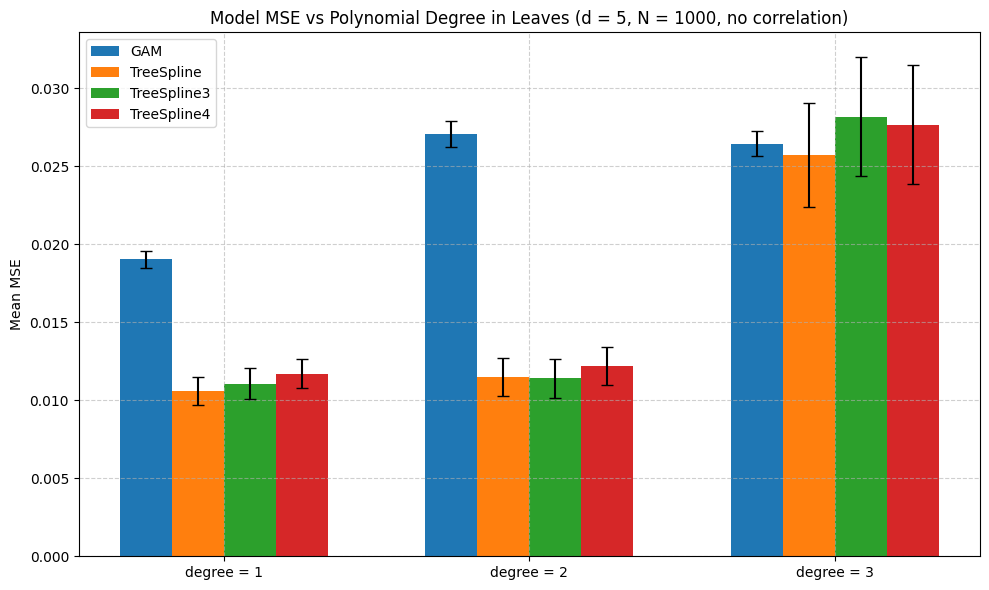

In [54]:
deg_values = [1, 2, 3]
deg_labels = [r'degree = 1', r'degree = 2', r'degree = 3']
x = np.arange(len(deg_labels))

model_labels = [
    'GAM',
    'TreeSpline',
    'TreeSpline3',
    'TreeSpline4',
]

n_models = len(model_labels)
width = 0.17  # bar width

all_mse_vars = [
    # GAM
    [gam_mse_hist10005,  gam_mse_hist100052,  gam_mse_hist100053],
    # TreeSpline
    [tree_mse_hist10005, tree_mse_hist100052, tree_mse_hist100053],
    # TreeSpline3
    [tree3_mse_hist10005, tree3_mse_hist100052, tree3_mse_hist100053],
    # TreeSpline4
    [tree4_mse_hist10005, tree4_mse_hist100052, tree4_mse_hist100053],
]

fig, ax = plt.subplots(figsize=(10, 6))

offsets = np.linspace(
    -((n_models - 1) / 2) * width,
    ((n_models - 1) / 2) * width,
    n_models
)

for m_idx, model_name in enumerate(model_labels):
    mse_lists = all_mse_vars[m_idx]  # list of 3 arrays: per degree

    # stack into shape (n_deg, n_replications)
    data = np.array([np.ravel(a) for a in mse_lists])
    means, cis = mean_ci(data)

    ax.bar(x + offsets[m_idx], means, width,
           yerr=cis, capsize=4,
           label=model_name)

ax.set_xticks(x)
ax.set_xticklabels(deg_labels)
ax.set_ylabel('Mean MSE')
ax.set_title('Model MSE vs Polynomial Degree in Leaves (d = 5, N = 1000, no correlation)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

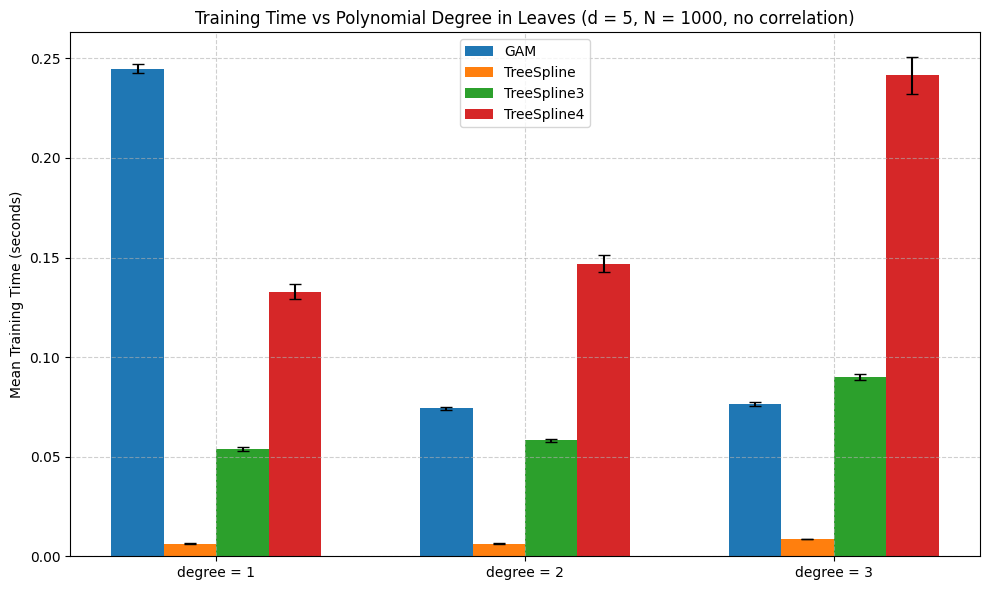

In [55]:
deg_values = [1, 2, 3]
deg_labels = [r'degree = 1', r'degree = 2', r'degree = 3']
x = np.arange(len(deg_labels))

model_labels = [
    'GAM',
    'TreeSpline',
    'TreeSpline3',
    'TreeSpline4',
]

n_models = len(model_labels)
width = 0.17  # bar width

all_time_vars = [
    # GAM
    [gam_time_hist10005,  gam_time_hist100052,  gam_time_hist100053],
    # TreeSpline
    [tree_time_hist10005, tree_time_hist100052, tree_time_hist100053],
    # TreeSpline3
    [tree3_time_hist10005, tree3_time_hist100052, tree3_time_hist100053],
    # TreeSpline4
    [tree4_time_hist10005, tree4_time_hist100052, tree4_time_hist100053],
]

fig, ax = plt.subplots(figsize=(10, 6))

offsets = np.linspace(
    -((n_models - 1) / 2) * width,
    ((n_models - 1) / 2) * width,
    n_models
)

for m_idx, model_name in enumerate(model_labels):
    time_lists = all_time_vars[m_idx]  # list of 3 arrays: per degree

    # stack into shape (n_deg, n_replications)
    data = np.array([np.ravel(a) for a in time_lists])
    means, cis = mean_ci(data)

    ax.bar(x + offsets[m_idx], means, width,
           yerr=cis, capsize=4,
           label=model_name)

ax.set_xticks(x)
ax.set_xticklabels(deg_labels)
ax.set_ylabel('Mean Training Time (seconds)')
ax.set_title('Training Time vs Polynomial Degree in Leaves (d = 5, N = 1000, no correlation)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

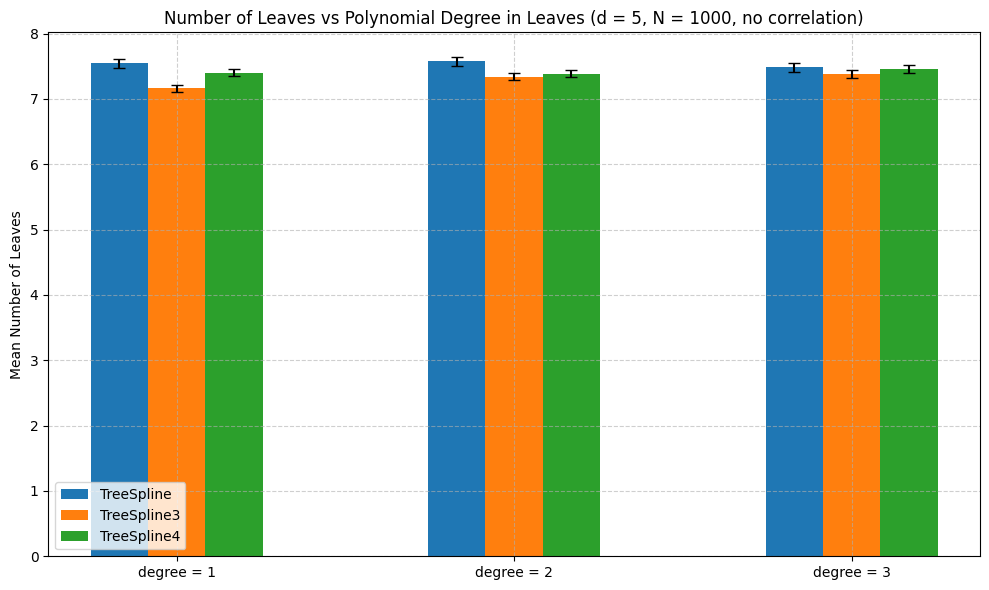

In [56]:
deg_values = [1, 2, 3]
deg_labels = [r'degree = 1', r'degree = 2', r'degree = 3']
x = np.arange(len(deg_labels))

labels = [
    'TreeSpline',
    'TreeSpline3',
    'TreeSpline4',
]

n_models = len(labels)
width = 0.17  # bar width

all_leaf_vars = [
    # TreeSpline
    [leaf_hist10005,  leaf_hist100052,  leaf_hist100053],
    # TreeSpline3
    [leaf3_hist10005, leaf3_hist100052, leaf3_hist100053],
    # TreeSpline4
    [leaf4_hist10005, leaf4_hist100052, leaf4_hist100053],
]

fig, ax = plt.subplots(figsize=(10, 6))

offsets = np.linspace(
    -((n_models - 1) / 2) * width,
    ((n_models - 1) / 2) * width,
    n_models
)

for m_idx, model_name in enumerate(labels):
    leaf_lists = all_leaf_vars[m_idx]  # list of 3 arrays: per degree

    # stack into shape (n_deg, n_replications)
    data = np.array([np.ravel(a) for a in leaf_lists])
    means, cis = mean_ci(data)

    ax.bar(x + offsets[m_idx], means, width,
           yerr=cis, capsize=4,
           label=model_name)

ax.set_xticks(x)
ax.set_xticklabels(deg_labels)
ax.set_ylabel('Mean Number of Leaves')
ax.set_title('Number of Leaves vs Polynomial Degree in Leaves (d = 5, N = 1000, no correlation)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

## Correlated features

### deg = 2

In [58]:
n_samples = 1000
repeats = 100
degree = 2

gam_mse_corr1hist100052 = np.zeros((4, repeats))
gam_time_corr1hist100052 = np.zeros((4, repeats))

leaf_corr1hist100052 = np.zeros((4, repeats))
tree_mse_corr1hist100052 = np.zeros((4, repeats))
tree_time_corr1hist100052 = np.zeros((4, repeats))

tree3_mse_corr1hist100052 = np.zeros((4, repeats))
tree3_time_corr1hist100052 = np.zeros((4, repeats))
leaf3_corr1hist100052 = np.zeros((4, repeats))

tree4_mse_corr1hist100052 = np.zeros((4, repeats))
tree4_time_corr1hist100052 = np.zeros((4, repeats))
leaf4_corr1hist100052 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, n_features=5, rho=0.1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr1hist100052[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr1hist100052[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22, poly_degree=degree)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr1hist100052[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr1hist100052[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr1hist100052[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22, poly_degree=degree)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr1hist100052[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr1hist100052[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr1hist100052[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22, poly_degree=degree)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr1hist100052[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr1hist100052[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr1hist100052[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [59]:
n_samples = 1000
repeats = 100
degree = 2

gam_mse_corr3hist100052 = np.zeros((4, repeats))
gam_time_corr3hist100052 = np.zeros((4, repeats))

leaf_corr3hist100052 = np.zeros((4, repeats))
tree_mse_corr3hist100052 = np.zeros((4, repeats))
tree_time_corr3hist100052 = np.zeros((4, repeats))

tree3_mse_corr3hist100052 = np.zeros((4, repeats))
tree3_time_corr3hist100052 = np.zeros((4, repeats))
leaf3_corr3hist100052 = np.zeros((4, repeats))

tree4_mse_corr3hist100052 = np.zeros((4, repeats))
tree4_time_corr3hist100052 = np.zeros((4, repeats))
leaf4_corr3hist100052 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, n_features=5, rho=0.3)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr3hist100052[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr3hist100052[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22, poly_degree=degree)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr3hist100052[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr3hist100052[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr3hist100052[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22, poly_degree=degree)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr3hist100052[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr3hist100052[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr3hist100052[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22, poly_degree=degree)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr3hist100052[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr3hist100052[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr3hist100052[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [60]:
n_samples = 1000
repeats = 100
degree = 2

gam_mse_corr5hist100052 = np.zeros((4, repeats))
gam_time_corr5hist100052 = np.zeros((4, repeats))

leaf_corr5hist100052 = np.zeros((4, repeats))
tree_mse_corr5hist100052 = np.zeros((4, repeats))
tree_time_corr5hist100052 = np.zeros((4, repeats))

tree3_mse_corr5hist100052 = np.zeros((4, repeats))
tree3_time_corr5hist100052 = np.zeros((4, repeats))
leaf3_corr5hist100052 = np.zeros((4, repeats))

tree4_mse_corr5hist100052 = np.zeros((4, repeats))
tree4_time_corr5hist100052 = np.zeros((4, repeats))
leaf4_corr5hist100052 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, n_features=5, rho=0.5)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr5hist100052[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr5hist100052[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22, poly_degree=degree)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr5hist100052[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr5hist100052[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr5hist100052[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22, poly_degree=degree)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr5hist100052[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr5hist100052[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr5hist100052[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22, poly_degree=degree)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr5hist100052[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr5hist100052[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr5hist100052[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



### deg=3

In [61]:
n_samples = 1000
repeats = 100
degree = 3

gam_mse_corr1hist100053 = np.zeros((4, repeats))
gam_time_corr1hist100053 = np.zeros((4, repeats))

leaf_corr1hist100053 = np.zeros((4, repeats))
tree_mse_corr1hist100053 = np.zeros((4, repeats))
tree_time_corr1hist100053 = np.zeros((4, repeats))

tree3_mse_corr1hist100053 = np.zeros((4, repeats))
tree3_time_corr1hist100053 = np.zeros((4, repeats))
leaf3_corr1hist100053 = np.zeros((4, repeats))

tree4_mse_corr1hist100053 = np.zeros((4, repeats))
tree4_time_corr1hist100053 = np.zeros((4, repeats))
leaf4_corr1hist100053 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, n_features=5, rho=0.1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr1hist100053[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr1hist100053[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22, poly_degree=degree)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr1hist100053[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr1hist100053[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr1hist100053[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22, poly_degree=degree)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr1hist100053[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr1hist100053[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr1hist100053[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22, poly_degree=degree)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr1hist100053[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr1hist100053[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr1hist100053[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [63]:
n_samples = 1000
repeats = 100
degree = 3

gam_mse_corr3hist100053 = np.zeros((4, repeats))
gam_time_corr3hist100053 = np.zeros((4, repeats))

leaf_corr3hist100053 = np.zeros((4, repeats))
tree_mse_corr3hist100053 = np.zeros((4, repeats))
tree_time_corr3hist100053 = np.zeros((4, repeats))

tree3_mse_corr3hist100053 = np.zeros((4, repeats))
tree3_time_corr3hist100053 = np.zeros((4, repeats))
leaf3_corr3hist100053 = np.zeros((4, repeats))

tree4_mse_corr3hist100053 = np.zeros((4, repeats))
tree4_time_corr3hist100053 = np.zeros((4, repeats))
leaf4_corr3hist100053 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, n_features=5, rho=0.3)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr3hist100053[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr3hist100053[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22, poly_degree=degree)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr3hist100053[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr3hist100053[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr3hist100053[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22, poly_degree=degree)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr3hist100053[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr3hist100053[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr3hist100053[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22, poly_degree=degree)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr3hist100053[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr3hist100053[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr3hist100053[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



In [64]:
n_samples = 1000
repeats = 100
degree = 3

gam_mse_corr5hist100053 = np.zeros((4, repeats))
gam_time_corr5hist100053 = np.zeros((4, repeats))

leaf_corr5hist100053 = np.zeros((4, repeats))
tree_mse_corr5hist100053 = np.zeros((4, repeats))
tree_time_corr5hist100053 = np.zeros((4, repeats))

tree3_mse_corr5hist100053 = np.zeros((4, repeats))
tree3_time_corr5hist100053 = np.zeros((4, repeats))
leaf3_corr5hist100053 = np.zeros((4, repeats))

tree4_mse_corr5hist100053 = np.zeros((4, repeats))
tree4_time_corr5hist100053 = np.zeros((4, repeats))
leaf4_corr5hist100053 = np.zeros((4, repeats))

for j in range(repeats):
    for i in range(1, 5):
        X, y = generate_correlated_data(n_samples, i, n_features=5, rho=0.5)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # GAM
        gam_start = time.time()
        gam = LinearGAM(s(0) + s(1)).gridsearch(X_train_scaled, y_train_scaled)
        gam_end = time.time()
        gam_time_corr5hist100053[i-1, j] = gam_end - gam_start
        y_pred = gam.predict(X_test_scaled)
        gam_mse_corr5hist100053[i-1, j] = mean_squared_error(y_test_scaled, y_pred)

        # TreeSpline
        model = TreeSpline(random_state=22, poly_degree=degree)
        tree_start = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        tree_end = time.time()
        tree_time_corr5hist100053[i-1, j] = tree_end - tree_start
        y_pred = model.predict(X_test_scaled)
        tree_mse_corr5hist100053[i-1, j] = mean_squared_error(y_test_scaled, y_pred)
        leaf_corr5hist100053[i-1, j] = model.get_leaf_count()

        # TreeSpline3
        model3 = TreeSpline3(random_state=22, poly_degree=degree)
        t3_start = time.time()
        model3.fit(X_train_scaled, y_train_scaled)
        t3_end = time.time()
        tree3_time_corr5hist100053[i-1, j] = t3_end - t3_start
        y_pred3 = model3.predict(X_test_scaled)
        tree3_mse_corr5hist100053[i-1, j] = mean_squared_error(y_test_scaled, y_pred3)
        leaf3_corr5hist100053[i-1, j] = model3.get_leaf_count()

        # TreeSpline4
        model4 = TreeSpline4(random_state=22, poly_degree=degree)
        t4_start = time.time()
        model4.fit(X_train_scaled, y_train_scaled)
        t4_end = time.time()
        tree4_time_corr5hist100053[i-1, j] = t4_end - t4_start
        y_pred4 = model4.predict(X_test_scaled)
        tree4_mse_corr5hist100053[i-1, j] = mean_squared_error(y_test_scaled, y_pred4)
        leaf4_corr5hist100053[i-1, j] = model4.get_leaf_count() 

    print(f"\n--- Repetition no. {j+1} done! ---\n")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        


--- Repetition no. 1 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 2 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 3 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 4 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 5 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 6 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 7 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 8 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 9 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 10 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 11 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 12 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 13 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 14 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 15 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 16 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 17 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 18 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 19 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 20 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 21 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 22 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 23 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 24 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 25 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 26 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 27 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 28 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 29 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 30 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 31 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 32 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 33 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 34 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 35 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 36 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 37 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 38 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 39 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 40 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 41 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 42 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 43 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 44 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 45 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 46 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 47 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 48 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 49 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 50 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 51 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 52 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################


--- Repetition no. 53 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 54 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 55 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 56 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 57 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 58 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 59 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 60 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 61 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 62 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 63 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 64 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 65 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 66 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 67 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 68 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 69 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 70 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 71 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 72 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 73 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 74 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 75 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 76 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 77 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 78 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 79 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 80 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 81 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 82 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 83 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 84 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 85 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 86 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 87 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 88 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 89 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 90 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 91 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 92 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 93 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 94 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 95 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 96 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 97 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 98 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 99 done! ---



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



--- Repetition no. 100 done! ---



### Save, Load and Visualize

In [65]:
np.save('nparrs/gam_mse_corr1hist100052.npy', gam_mse_corr1hist100052)
np.save('nparrs/gam_time_corr1hist100052.npy', gam_time_corr1hist100052)
np.save('nparrs/tree_time_corr1hist100052.npy', tree_time_corr1hist100052)
np.save('nparrs/tree_mse_corr1hist100052.npy', tree_mse_corr1hist100052)
np.save('nparrs/leaf_corr1hist100052.npy', leaf_corr1hist100052)
np.save('nparrs/tree3_time_corr1hist100052.npy', tree3_time_corr1hist100052)
np.save('nparrs/tree3_mse_corr1hist100052.npy', tree3_mse_corr1hist100052)
np.save('nparrs/leaf3_corr1hist100052.npy', leaf3_corr1hist100052)
np.save('nparrs/tree4_time_corr1hist100052.npy', tree4_time_corr1hist100052)
np.save('nparrs/tree4_mse_corr1hist100052.npy', tree4_mse_corr1hist100052)
np.save('nparrs/leaf4_corr1hist100052.npy', leaf4_corr1hist100052)

np.save('nparrs/gam_mse_corr3hist100052.npy', gam_mse_corr3hist100052)
np.save('nparrs/gam_time_corr3hist100052.npy', gam_time_corr3hist100052)
np.save('nparrs/tree_time_corr3hist100052.npy', tree_time_corr3hist100052)
np.save('nparrs/tree_mse_corr3hist100052.npy', tree_mse_corr3hist100052)
np.save('nparrs/leaf_corr3hist100052.npy', leaf_corr3hist100052)
np.save('nparrs/tree3_time_corr3hist100052.npy', tree3_time_corr3hist100052)
np.save('nparrs/tree3_mse_corr3hist100052.npy', tree3_mse_corr3hist100052)
np.save('nparrs/leaf3_corr3hist100052.npy', leaf3_corr3hist100052)
np.save('nparrs/tree4_time_corr3hist100052.npy', tree4_time_corr3hist100052)
np.save('nparrs/tree4_mse_corr3hist100052.npy', tree4_mse_corr3hist100052)
np.save('nparrs/leaf4_corr3hist100052.npy', leaf4_corr3hist100052)

np.save('nparrs/gam_mse_corr5hist100052.npy', gam_mse_corr5hist100052)
np.save('nparrs/gam_time_corr5hist100052.npy', gam_time_corr5hist100052)
np.save('nparrs/tree_time_corr5hist100052.npy', tree_time_corr5hist100052)
np.save('nparrs/tree_mse_corr5hist100052.npy', tree_mse_corr5hist100052)
np.save('nparrs/leaf_corr5hist100052.npy', leaf_corr5hist100052)
np.save('nparrs/tree3_time_corr5hist100052.npy', tree3_time_corr5hist100052)
np.save('nparrs/tree3_mse_corr5hist100052.npy', tree3_mse_corr5hist100052)
np.save('nparrs/leaf3_corr5hist100052.npy', leaf3_corr5hist100052)
np.save('nparrs/tree4_time_corr5hist100052.npy', tree4_time_corr5hist100052)
np.save('nparrs/tree4_mse_corr5hist100052.npy', tree4_mse_corr5hist100052)
np.save('nparrs/leaf4_corr5hist100052.npy', leaf4_corr5hist100052)

# ----------------------------------------------------------------

np.save('nparrs/gam_mse_corr1hist100053.npy', gam_mse_corr1hist100053)
np.save('nparrs/gam_time_corr1hist100053.npy', gam_time_corr1hist100053)
np.save('nparrs/tree_time_corr1hist100053.npy', tree_time_corr1hist100053)
np.save('nparrs/tree_mse_corr1hist100053.npy', tree_mse_corr1hist100053)
np.save('nparrs/leaf_corr1hist100053.npy', leaf_corr1hist100053)
np.save('nparrs/tree3_time_corr1hist100053.npy', tree3_time_corr1hist100053)
np.save('nparrs/tree3_mse_corr1hist100053.npy', tree3_mse_corr1hist100053)
np.save('nparrs/leaf3_corr1hist100053.npy', leaf3_corr1hist100053)
np.save('nparrs/tree4_time_corr1hist100053.npy', tree4_time_corr1hist100053)
np.save('nparrs/tree4_mse_corr1hist100053.npy', tree4_mse_corr1hist100053)
np.save('nparrs/leaf4_corr1hist100053.npy', leaf4_corr1hist100053)

np.save('nparrs/gam_mse_corr3hist100053.npy', gam_mse_corr3hist100053)
np.save('nparrs/gam_time_corr3hist100053.npy', gam_time_corr3hist100053)
np.save('nparrs/tree_time_corr3hist100053.npy', tree_time_corr3hist100053)
np.save('nparrs/tree_mse_corr3hist100053.npy', tree_mse_corr3hist100053)
np.save('nparrs/leaf_corr3hist100053.npy', leaf_corr3hist100053)
np.save('nparrs/tree3_time_corr3hist100053.npy', tree3_time_corr3hist100053)
np.save('nparrs/tree3_mse_corr3hist100053.npy', tree3_mse_corr3hist100053)
np.save('nparrs/leaf3_corr3hist100053.npy', leaf3_corr3hist100053)
np.save('nparrs/tree4_time_corr3hist100053.npy', tree4_time_corr3hist100053)
np.save('nparrs/tree4_mse_corr3hist100053.npy', tree4_mse_corr3hist100053)
np.save('nparrs/leaf4_corr3hist100053.npy', leaf4_corr3hist100053)

np.save('nparrs/gam_mse_corr5hist100053.npy', gam_mse_corr5hist100053)
np.save('nparrs/gam_time_corr5hist100053.npy', gam_time_corr5hist100053)
np.save('nparrs/tree_time_corr5hist100053.npy', tree_time_corr5hist100053)
np.save('nparrs/tree_mse_corr5hist100053.npy', tree_mse_corr5hist100053)
np.save('nparrs/leaf_corr5hist100053.npy', leaf_corr5hist100053)
np.save('nparrs/tree3_time_corr5hist100053.npy', tree3_time_corr5hist100053)
np.save('nparrs/tree3_mse_corr5hist100053.npy', tree3_mse_corr5hist100053)
np.save('nparrs/leaf3_corr5hist100053.npy', leaf3_corr5hist100053)
np.save('nparrs/tree4_time_corr5hist100053.npy', tree4_time_corr5hist100053)
np.save('nparrs/tree4_mse_corr5hist100053.npy', tree4_mse_corr5hist100053)
np.save('nparrs/leaf4_corr5hist100053.npy', leaf4_corr5hist100053)

In [66]:
gam_mse_corr1hist100052 = np.load('nparrs/gam_mse_corr1hist100052.npy')
gam_time_corr1hist100052 = np.load('nparrs/gam_time_corr1hist100052.npy')
tree_time_corr1hist100052 = np.load('nparrs/tree_time_corr1hist100052.npy')
tree_mse_corr1hist100052 = np.load('nparrs/tree_mse_corr1hist100052.npy')
leaf_corr1hist100052 = np.load('nparrs/leaf_corr1hist100052.npy')
tree3_time_corr1hist100052 = np.load('nparrs/tree3_time_corr1hist100052.npy')
tree3_mse_corr1hist100052 = np.load('nparrs/tree3_mse_corr1hist100052.npy')
leaf3_corr1hist100052 = np.load('nparrs/leaf3_corr1hist100052.npy')
tree4_time_corr1hist100052 = np.load('nparrs/tree4_time_corr1hist100052.npy')
tree4_mse_corr1hist100052 = np.load('nparrs/tree4_mse_corr1hist100052.npy')
leaf4_corr1hist100052 = np.load('nparrs/leaf4_corr1hist100052.npy')

gam_mse_corr3hist100052 = np.load('nparrs/gam_mse_corr3hist100052.npy')
gam_time_corr3hist100052 = np.load('nparrs/gam_time_corr3hist100052.npy')
tree_time_corr3hist100052 = np.load('nparrs/tree_time_corr3hist100052.npy')
tree_mse_corr3hist100052 = np.load('nparrs/tree_mse_corr3hist100052.npy')
leaf_corr3hist100052 = np.load('nparrs/leaf_corr3hist100052.npy')
tree3_time_corr3hist100052 = np.load('nparrs/tree3_time_corr3hist100052.npy')
tree3_mse_corr3hist100052 = np.load('nparrs/tree3_mse_corr3hist100052.npy')
leaf3_corr3hist100052 = np.load('nparrs/leaf3_corr3hist100052.npy')
tree4_time_corr3hist100052 = np.load('nparrs/tree4_time_corr3hist100052.npy')
tree4_mse_corr3hist100052 = np.load('nparrs/tree4_mse_corr3hist100052.npy')
leaf4_corr3hist100052 = np.load('nparrs/leaf4_corr3hist100052.npy')

gam_mse_corr5hist100052 = np.load('nparrs/gam_mse_corr5hist100052.npy')
gam_time_corr5hist100052 = np.load('nparrs/gam_time_corr5hist100052.npy')
tree_time_corr5hist100052 = np.load('nparrs/tree_time_corr5hist100052.npy')
tree_mse_corr5hist100052 = np.load('nparrs/tree_mse_corr5hist100052.npy')
leaf_corr5hist100052 = np.load('nparrs/leaf_corr5hist100052.npy')
tree3_time_corr5hist100052 = np.load('nparrs/tree3_time_corr5hist100052.npy')
tree3_mse_corr5hist100052 = np.load('nparrs/tree3_mse_corr5hist100052.npy')
leaf3_corr5hist100052 = np.load('nparrs/leaf3_corr5hist100052.npy')
tree4_time_corr5hist100052 = np.load('nparrs/tree4_time_corr5hist100052.npy')
tree4_mse_corr5hist100052 = np.load('nparrs/tree4_mse_corr5hist100052.npy')
leaf4_corr5hist100052 = np.load('nparrs/leaf4_corr5hist100052.npy')

# --------------------------------------------------------------

gam_mse_corr1hist100053 = np.load('nparrs/gam_mse_corr1hist100053.npy')
gam_time_corr1hist100053 = np.load('nparrs/gam_time_corr1hist100053.npy')
tree_time_corr1hist100053 = np.load('nparrs/tree_time_corr1hist100053.npy')
tree_mse_corr1hist100053 = np.load('nparrs/tree_mse_corr1hist100053.npy')
leaf_corr1hist100053 = np.load('nparrs/leaf_corr1hist100053.npy')
tree3_time_corr1hist100053 = np.load('nparrs/tree3_time_corr1hist100053.npy')
tree3_mse_corr1hist100053 = np.load('nparrs/tree3_mse_corr1hist100053.npy')
leaf3_corr1hist100053 = np.load('nparrs/leaf3_corr1hist100053.npy')
tree4_time_corr1hist100053 = np.load('nparrs/tree4_time_corr1hist100053.npy')
tree4_mse_corr1hist100053 = np.load('nparrs/tree4_mse_corr1hist100053.npy')
leaf4_corr1hist100053 = np.load('nparrs/leaf4_corr1hist100053.npy')

gam_mse_corr3hist100053 = np.load('nparrs/gam_mse_corr3hist100053.npy')
gam_time_corr3hist100053 = np.load('nparrs/gam_time_corr3hist100053.npy')
tree_time_corr3hist100053 = np.load('nparrs/tree_time_corr3hist100053.npy')
tree_mse_corr3hist100053 = np.load('nparrs/tree_mse_corr3hist100053.npy')
leaf_corr3hist100053 = np.load('nparrs/leaf_corr3hist100053.npy')
tree3_time_corr3hist100053 = np.load('nparrs/tree3_time_corr3hist100053.npy')
tree3_mse_corr3hist100053 = np.load('nparrs/tree3_mse_corr3hist100053.npy')
leaf3_corr3hist100053 = np.load('nparrs/leaf3_corr3hist100053.npy')
tree4_time_corr3hist100053 = np.load('nparrs/tree4_time_corr3hist100053.npy')
tree4_mse_corr3hist100053 = np.load('nparrs/tree4_mse_corr3hist100053.npy')
leaf4_corr3hist100053 = np.load('nparrs/leaf4_corr3hist100053.npy')

gam_mse_corr5hist100053 = np.load('nparrs/gam_mse_corr5hist100053.npy')
gam_time_corr5hist100053 = np.load('nparrs/gam_time_corr5hist100053.npy')
tree_time_corr5hist100053 = np.load('nparrs/tree_time_corr5hist100053.npy')
tree_mse_corr5hist100053 = np.load('nparrs/tree_mse_corr5hist100053.npy')
leaf_corr5hist100053 = np.load('nparrs/leaf_corr5hist100053.npy')
tree3_time_corr5hist100053 = np.load('nparrs/tree3_time_corr5hist100053.npy')
tree3_mse_corr5hist100053 = np.load('nparrs/tree3_mse_corr5hist100053.npy')
leaf3_corr5hist100053 = np.load('nparrs/leaf3_corr5hist100053.npy')
tree4_time_corr5hist100053 = np.load('nparrs/tree4_time_corr5hist100053.npy')
tree4_mse_corr5hist100053 = np.load('nparrs/tree4_mse_corr5hist100053.npy')
leaf4_corr5hist100053 = np.load('nparrs/leaf4_corr5hist100053.npy')

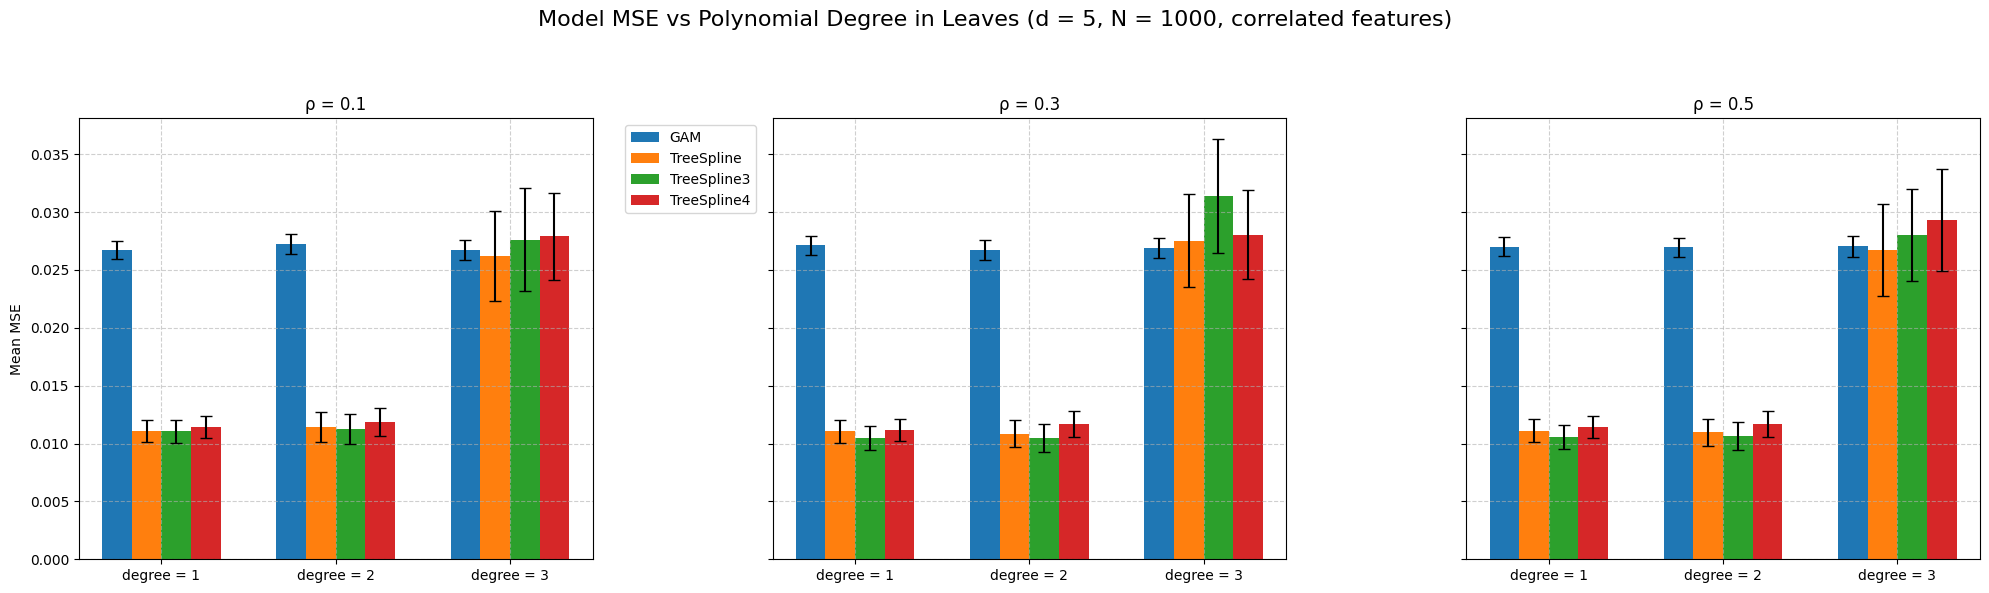

In [68]:
deg_values = [1, 2, 3]
deg_labels = [r'degree = 1', r'degree = 2', r'degree = 3']
x = np.arange(len(deg_labels))

rho_labels = [r'ρ = 0.1', r'ρ = 0.3', r'ρ = 0.5']

model_labels = [
    'GAM',
    'TreeSpline',
    'TreeSpline3',
    'TreeSpline4',
]

n_models = len(model_labels)
width = 0.17  # bar width

all_mse_vars = [
    # GAM
    [
        [gam_mse_corr1hist10005,  gam_mse_corr1hist100052,  gam_mse_corr1hist100053],
        [gam_mse_corr3hist10005,  gam_mse_corr3hist100052,  gam_mse_corr3hist100053],
        [gam_mse_corr5hist10005,  gam_mse_corr5hist100052,  gam_mse_corr5hist100053],
    ],
    # TreeSpline
    [
        [tree_mse_corr1hist10005, tree_mse_corr1hist100052, tree_mse_corr1hist100053],
        [tree_mse_corr3hist10005, tree_mse_corr3hist100052, tree_mse_corr3hist100053],
        [tree_mse_corr5hist10005, tree_mse_corr5hist100052, tree_mse_corr5hist100053],
    ],
    # TreeSpline3
    [
        [tree3_mse_corr1hist10005, tree3_mse_corr1hist100052, tree3_mse_corr1hist100053],
        [tree3_mse_corr3hist10005, tree3_mse_corr3hist100052, tree3_mse_corr3hist100053],
        [tree3_mse_corr5hist10005, tree3_mse_corr5hist100052, tree3_mse_corr5hist100053],
    ],
    # TreeSpline4
    [
        [tree4_mse_corr1hist10005, tree4_mse_corr1hist100052, tree4_mse_corr1hist100053],
        [tree4_mse_corr3hist10005, tree4_mse_corr3hist100052, tree4_mse_corr3hist100053],
        [tree4_mse_corr5hist10005, tree4_mse_corr5hist100052, tree4_mse_corr5hist100053],
    ],
]

# ----------------------------------------
# Plotting
# ----------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
offsets = np.linspace(
    -((n_models - 1) / 2) * width,
    ((n_models - 1) / 2) * width,
    n_models
)

for rho_idx, rho_label in enumerate(rho_labels):
    ax = axs[rho_idx]
    for m_idx, model_name in enumerate(model_labels):
        # list of 3 arrays: [deg=1, deg=2, deg=3] for this (model, rho)
        mse_lists = all_mse_vars[m_idx][rho_idx]

        # stack into shape (n_deg, n_replications)
        data = np.array([np.ravel(a) for a in mse_lists])
        means, cis = mean_ci(data)

        ax.bar(x + offsets[m_idx], means, width,
               yerr=cis, capsize=4,
               label=model_name if rho_idx == 0 else "")

    ax.set_xticks(x)
    ax.set_xticklabels(deg_labels)
    ax.set_title(rho_label)
    ax.grid(True, linestyle='--', alpha=0.6)
    if rho_idx == 0:
        ax.set_ylabel('Mean MSE')

# Legend only once
axs[0].legend(ncol=1, fontsize=10, bbox_to_anchor=(1.05, 1.0))

fig.suptitle('Model MSE vs Polynomial Degree in Leaves (d = 5, N = 1000, correlated features)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

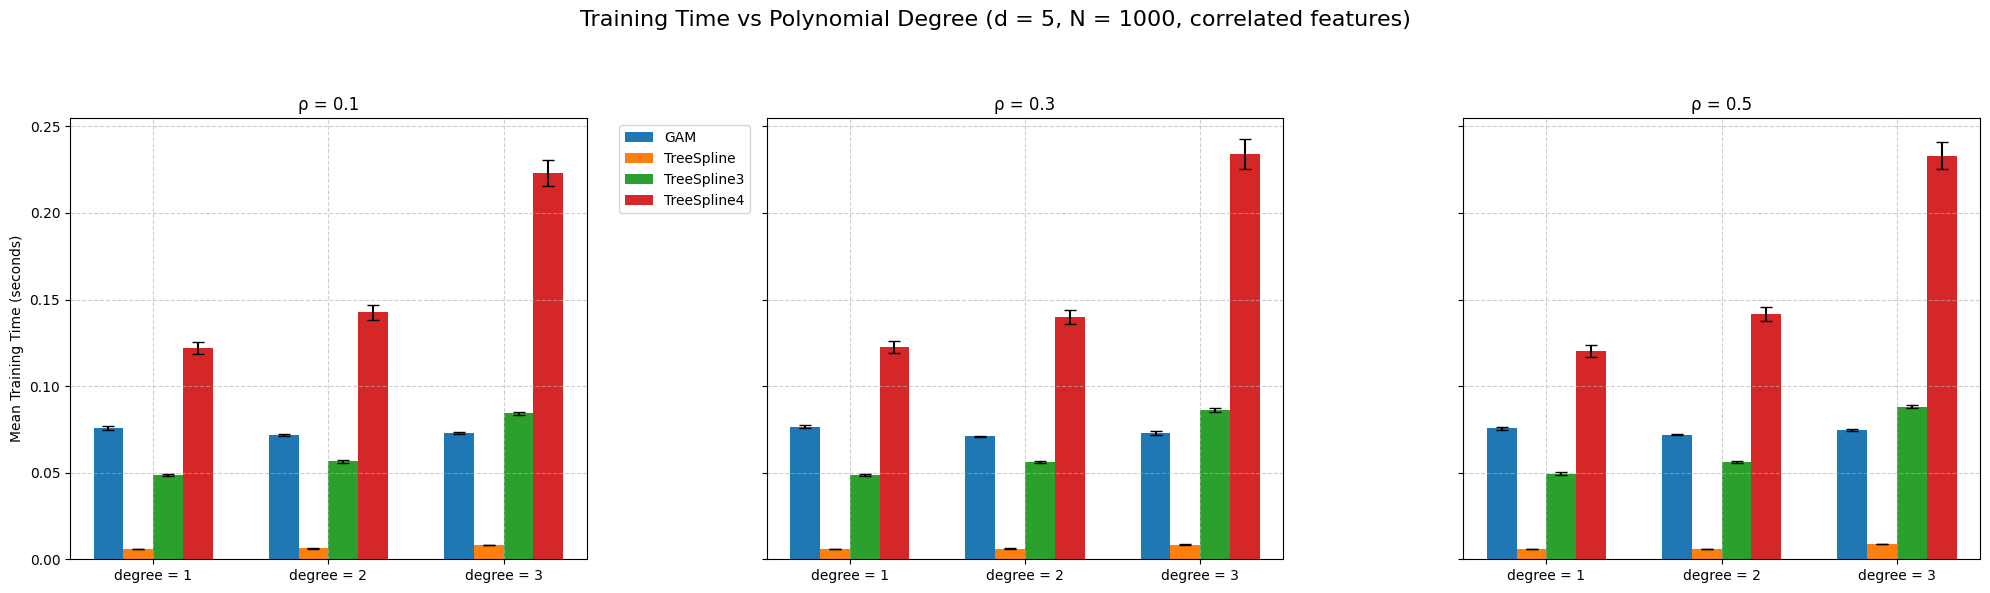

In [69]:
def mean_ci_deg(data, confidence=0.95):
    data = np.atleast_2d(data)
    if data.shape[0] != len(deg_labels):
        data = data.T  # ensure rows = degrees
    mean = np.mean(data, axis=1)
    sd = stats.sem(data, axis=1)
    h = sd * stats.t.ppf((1 + confidence) / 2.0, data.shape[1] - 1)
    return mean, h

deg_labels = [r'degree = 1', r'degree = 2', r'degree = 3']
x = np.arange(len(deg_labels))

rho_labels = [r'ρ = 0.1', r'ρ = 0.3', r'ρ = 0.5']

model_labels = [
    'GAM',
    'TreeSpline',
    'TreeSpline3',
    'TreeSpline4',
]

n_models = len(model_labels)
width = 0.17  # bar width

all_time_vars = [
    # GAM
    [
        [gam_time_corr1hist10005,  gam_time_corr1hist100052,  gam_time_corr1hist100053],
        [gam_time_corr3hist10005,  gam_time_corr3hist100052,  gam_time_corr3hist100053],
        [gam_time_corr5hist10005,  gam_time_corr5hist100052,  gam_time_corr5hist100053],
    ],
    # TreeSpline
    [
        [tree_time_corr1hist10005, tree_time_corr1hist100052, tree_time_corr1hist100053],
        [tree_time_corr3hist10005, tree_time_corr3hist100052, tree_time_corr3hist100053],
        [tree_time_corr5hist10005, tree_time_corr5hist100052, tree_time_corr5hist100053],
    ],
    # TreeSpline3
    [
        [tree3_time_corr1hist10005, tree3_time_corr1hist100052, tree3_time_corr1hist100053],
        [tree3_time_corr3hist10005, tree3_time_corr3hist100052, tree3_time_corr3hist100053],
        [tree3_time_corr5hist10005, tree3_time_corr5hist100052, tree3_time_corr5hist100053],
    ],
    # TreeSpline4
    [
        [tree4_time_corr1hist10005, tree4_time_corr1hist100052, tree4_time_corr1hist100053],
        [tree4_time_corr3hist10005, tree4_time_corr3hist100052, tree4_time_corr3hist100053],
        [tree4_time_corr5hist10005, tree4_time_corr5hist100052, tree4_time_corr5hist100053],
    ],
]

# -------------------------------
# Plotting: training time
# -------------------------------
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
offsets = np.linspace(
    -((n_models - 1) / 2) * width,
    ((n_models - 1) / 2) * width,
    n_models
)

for rho_idx, rho_label in enumerate(rho_labels):
    ax = axs[rho_idx]
    for m_idx, model_name in enumerate(model_labels):
        time_lists = all_time_vars[m_idx][rho_idx]  # [deg=1,2,3] arrays

        data = np.array([np.ravel(a) for a in time_lists])  # (n_deg, n_rep)
        means, cis = mean_ci_deg(data)

        ax.bar(x + offsets[m_idx], means, width,
               yerr=cis, capsize=4,
               label=model_name if rho_idx == 0 else "")

    ax.set_xticks(x)
    ax.set_xticklabels(deg_labels)
    ax.set_title(rho_label)
    ax.grid(True, linestyle='--', alpha=0.6)
    if rho_idx == 0:
        ax.set_ylabel('Mean Training Time (seconds)')

axs[0].legend(ncol=1, fontsize=10, bbox_to_anchor=(1.05, 1.0))

fig.suptitle('Training Time vs Polynomial Degree (d = 5, N = 1000, correlated features)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

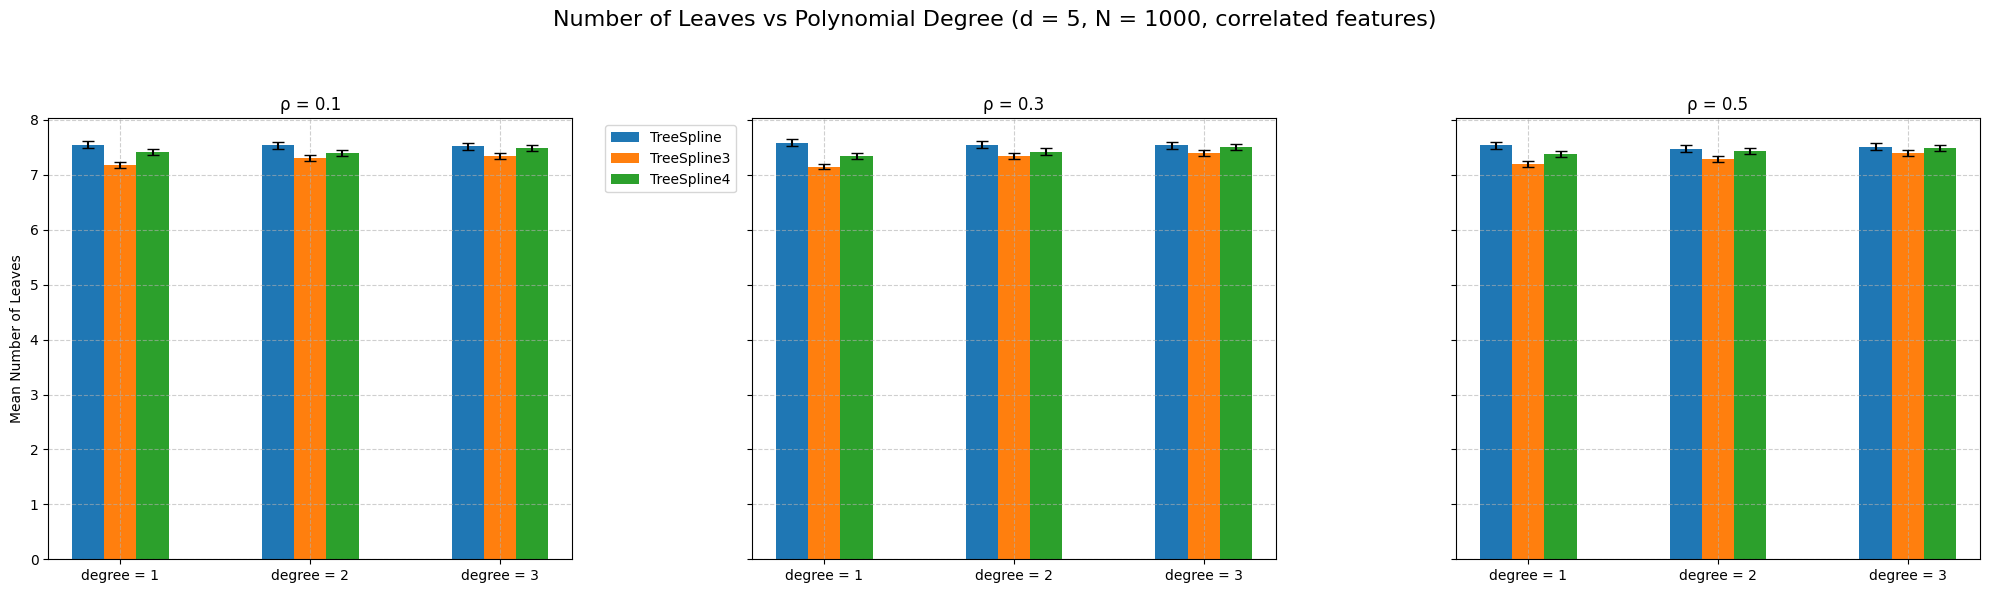

In [70]:
deg_labels = [r'degree = 1', r'degree = 2', r'degree = 3']
x = np.arange(len(deg_labels))

rho_labels = [r'ρ = 0.1', r'ρ = 0.3', r'ρ = 0.5']

labels = [
    'TreeSpline',
    'TreeSpline3',
    'TreeSpline4',
]

n_models = len(labels)
width = 0.17  # bar width

all_leaf_vars = [
    # TreeSpline
    [
        [leaf_corr1hist10005,  leaf_corr1hist100052,  leaf_corr1hist100053],
        [leaf_corr3hist10005,  leaf_corr3hist100052,  leaf_corr3hist100053],
        [leaf_corr5hist10005,  leaf_corr5hist100052,  leaf_corr5hist100053],
    ],
    # TreeSpline3
    [
        [leaf3_corr1hist10005, leaf3_corr1hist100052, leaf3_corr1hist100053],
        [leaf3_corr3hist10005, leaf3_corr3hist100052, leaf3_corr3hist100053],
        [leaf3_corr5hist10005, leaf3_corr5hist100052, leaf3_corr5hist100053],
    ],
    # TreeSpline4
    [
        [leaf4_corr1hist10005, leaf4_corr1hist100052, leaf4_corr1hist100053],
        [leaf4_corr3hist10005, leaf4_corr3hist100052, leaf4_corr3hist100053],
        [leaf4_corr5hist10005, leaf4_corr5hist100052, leaf4_corr5hist100053],
    ],
]

# -------------------------------
# Plotting: number of leaves
# -------------------------------
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
offsets = np.linspace(
    -((n_models - 1) / 2) * width,
    ((n_models - 1) / 2) * width,
    n_models
)

for rho_idx, rho_label in enumerate(rho_labels):
    ax = axs[rho_idx]
    for m_idx, model_name in enumerate(labels):
        leaf_lists = all_leaf_vars[m_idx][rho_idx]  # [deg=1,2,3] arrays

        data = np.array([np.ravel(a) for a in leaf_lists])  # (n_deg, n_rep)
        means, cis = mean_ci_deg(data)

        ax.bar(x + offsets[m_idx], means, width,
               yerr=cis, capsize=4,
               label=model_name if rho_idx == 0 else "")

    ax.set_xticks(x)
    ax.set_xticklabels(deg_labels)
    ax.set_title(rho_label)
    ax.grid(True, linestyle='--', alpha=0.6)
    if rho_idx == 0:
        ax.set_ylabel('Mean Number of Leaves')

axs[0].legend(ncol=1, fontsize=10, bbox_to_anchor=(1.05, 1.0))

fig.suptitle('Number of Leaves vs Polynomial Degree (d = 5, N = 1000, correlated features)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

## Comparison on real-world data